![Egeria Logo](https://raw.githubusercontent.com/odpi/egeria/master/assets/img/ODPi_Egeria_Logo_color.png)

### Performance Suite Results
# Crux Plugin Repository Connector

## Introduction

Following are detailed results for the Crux Connector's performance at various scales. In each set of results, the Crux Connector was tested under the following conditions (full details are available in the each results directory's `deployment` file):

- Running through a Kubernetes pod with a single OMAG Platform running both the Performance Test Suite server and the Crux Plugin Repository
- Running a co-located Bitnami Kafka (and Zookeeper) pod on the same Kubernetes node running the OMAG Platform
- Resources allocated are a minimum of 2 cores to a maximum of 4 cores, and a minimum of 8GB memory to a maximum of 16GB memory

### Versions

Component | Version | Notes
---|---|---
Egeria | 2.8 | OMAG Platform, CTS, PTS
Crux Plugin Repository Connector | 2.8 |
Crux | 21.04-1.16.0-beta | Embedded in Crux Plugin Repository Connector
RocksDB | 6.15.2 | Used for transaction log, document store and index store for Crux
Kafka | 2.3.1 | Used for cohort event bus
Lucene | 8.8.2 | Used for text indexing in Crux

## Setup

### Results locations

Locations for the results (see subdirectories in the same location where this notebook resides to review the raw results themselves):

In [1]:
results = [
    "pts-05-02",
    "pts-10-05",
    "janus-05-02"
]

### Analysis and visualization methods

The following defines methods necessary to parse, process and visualize the results, and must be run prior to the subsequent cells.

In [2]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

def validateProfileResultsLocation(location):
    profile_details_location = location + os.path.sep + "profile-details"
    print("Validating profile-details location:", profile_details_location)
    if os.path.isdir(profile_details_location):
        print(" ... directory exists.")
    else:
        print(" ... ERROR: could not find this directory. Is the location specified correct?")

# Define the profile ordering
profile_order=[
    'Entity creation', 'Entity search', 'Relationship creation', 'Relationship search',
    'Entity classification', 'Classification search', 'Entity update', 'Relationship update',
    'Classification update', 'Entity undo', 'Relationship undo', 'Entity retrieval', 'Entity history retrieval',
    'Relationship retrieval', 'Relationship history retrieval', 'Entity history search', 'Relationship history search',
    'Graph queries', 'Graph history queries', 'Entity re-home', 'Relationship re-home', 'Entity declassify',
    'Entity re-type', 'Relationship re-type', 'Entity re-identify', 'Relationship re-identify',
    'Relationship delete', 'Entity delete', 'Entity restore', 'Relationship restore', 'Relationship purge',
    'Entity purge'
]

# Given a profileResult.requirementResults object, parse all of its positiveTestEvidence
# for discovered properties
def parseProperties(df, repositoryName, requirementResults):
    if (requirementResults is not None and 'positiveTestEvidence' in requirementResults):
        print("Parsing properties for:", requirementResults['name'], "(" + repositoryName + ")")
        data_array = []
        for evidence in requirementResults['positiveTestEvidence']:
            if ('propertyName' in evidence and 'propertyValue' in evidence):
                data = {
                    'repo': repositoryName,
                    'property_name': evidence['propertyName'],
                    'property_value': evidence['propertyValue']
                }
                data_array.append(data)
        df = df.append(pd.read_json(json.dumps(data_array), orient='records'), ignore_index=True)
    return df

# Given a profileResult.requirementResults object, parse all of its positiveTestEvidence
# and group the results by methodName
def parseEvidence(df, repositoryName, requirementResults):
    if (requirementResults is not None and 'positiveTestEvidence' in requirementResults):
        print("Parsing evidence for:", requirementResults['name'], "(" + repositoryName + ")")
        data_array = []
        for evidence in requirementResults['positiveTestEvidence']:
            if ('methodName' in evidence and 'elapsedTime' in evidence):
                data = {
                    'repo': repositoryName,
                    'method_name': evidence['methodName'],
                    'elapsed_time': evidence['elapsedTime'],
                    'profile_name': requirementResults['name'],
                    'test_case_id': evidence['testCaseId'],
                    'assertion_id': evidence['assertionId']
                }
                data_array.append(data)
        df = df.append(pd.read_json(json.dumps(data_array), orient='records'), ignore_index=True)
    return df

# Given a profile detail JSON file, retrieve all of its profileResult.requirementResults[] objects
def parseRequirementResults(profileFile):
    with open(profileFile) as f:
        profile = json.load(f)
    # This first case covers files retrieved via API
    if ('profileResult' in profile and 'requirementResults' in profile['profileResult']):
        return profile['profileResult']['requirementResults']
    # This second case covers files created by the CLI client
    elif ('requirementResults' in profile):
        return profile['requirementResults']
    else:
        return None

def getEnvironmentProfile(profileLocation):
    detailsLocation = profileLocation + os.path.sep + "profile-details"
    return detailsLocation + os.path.sep + "Environment.json"

def parseEnvironmentDetailsIntoDF(df, profileFile, qualifier):
    profileResults = parseRequirementResults(profileFile)
    if profileResults is not None:
        for result in profileResults:
            df = parseProperties(df, qualifier, result)
    return df

# Retrieve a listing of all of the profile detail JSON files
def getAllProfiles(profileLocation):
    detailsLocation = profileLocation + os.path.sep + "profile-details"
    _, _, filenames = next(os.walk(detailsLocation))
    full_filenames = []
    for filename in filenames:
        full_filenames.append(detailsLocation + os.path.sep + filename)
    return full_filenames

# Parse all of the provided profile file's details into the provided dataframe
def parseProfileDetailsIntoDF(df, profileFile, qualifier):
    profileResults = parseRequirementResults(profileFile)
    if profileResults is not None:
        for result in profileResults:
            df = parseEvidence(df, qualifier, result)
    return df

def plotMethod(df, methodName, remove_outliers=False, by_repo=False, by_assertion=False):
    dfX = df[df['method_name'] == methodName]
    if not dfX.empty:
        if remove_outliers:
            dfX = dfX[dfX['elapsed_time'].between(dfX['elapsed_time'].quantile(.00), dfX['elapsed_time'].quantile(.99))]
        sns.set(font_scale=1.2)
        sns.set_style("whitegrid")
        fix, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,9))
        if by_repo:
            # Display the repos within the method in alphabetical order for consistency
            repos = dfX['repo'].unique()
            figure = sns.histplot(ax=axs, data=dfX, x="elapsed_time", hue="repo",
                                  hue_order=sorted(repos), kde=True, discrete=False)
        if by_assertion:
            # Display the assertions within the method in alphabetical order for consistency
            assertions = dfX['assertion_id'].unique()
            figure = sns.histplot(ax=axs, data=dfX, x="elapsed_time", hue="assertion_id",
                                  hue_order=sorted(assertions), kde=True, discrete=False)
        else:
            figure = sns.histplot(ax=axs, data=dfX, x="elapsed_time",
                                  kde=True, discrete=False)
        figure.set(xlabel="Elapsed time (ms)")
        figure.set_title(methodName)
        display(fix)
        plt.close(fix)

def plotProfile(df, profileName, remove_outliers=False):
    dfX = df[df['profile_name'] == profileName]
    # Only attempt to plot if there is anything left in the dataframe
    if not dfX.empty:
        if remove_outliers:
            # If we have been asked to remove outliers, drop anything outside the 2nd and 98th percentiles
            dfX = dfX[dfX['elapsed_time'].between(dfX['elapsed_time'].quantile(.02), dfX['elapsed_time'].quantile(.98))]
        sns.set(font_scale=1.2)
        sns.set_style("whitegrid")
        fix, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,9))
        # Display the methods within the profile in alphabetical order for consistency
        methods = dfX['method_name'].unique()
        figure = sns.histplot(ax=axs, data=dfX, x="elapsed_time", hue="method_name",
                              hue_order=sorted(methods), kde=True, discrete=False)
        figure.set(xlabel="Elapsed time (ms)")
        figure.set_title(profileName)
        figure.get_legend().set(title='Method')
        display(fix)
        plt.close(fix)

def slowestRunning(df, num=10, methodName=None):
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', None)
    if methodName:
        df = df[df['method_name'] == methodName]
    display(df.sort_values(by=['elapsed_time'], ascending=False).groupby('method_name').head(num))

def compareProfiles(df, profileName, left, right, remove_outliers=False):
    dfX = df[df['profile_name'] == profileName]
    # Only attempt to plot if there is anything left in the dataframe
    if not dfX.empty:
        if remove_outliers:
            # If we have been asked to remove outliers, drop anything outside the 2nd and 98th percentiles
            dfX = dfX[dfX['elapsed_time'].between(dfX['elapsed_time'].quantile(.02), dfX['elapsed_time'].quantile(.98))]
        sns.set(font_scale=1.2)
        sns.set_style("whitegrid")
        fix, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,9))
        # Display the methods within the profile in alphabetical order for consistency
        methods = dfX['method_name'].unique()
        figure = sns.violinplot(x="method_name", y="elapsed_time", ax=axs, hue="repo",
                                hue_order=[left, right], split=True, scale='count',
                                inner='quartile', cut=0, data=dfX)
        # If there are more than 4 methods in the profile, rotate them so they are still readable
        if (len(methods) > 4):
            figure.set_xticklabels(figure.get_xticklabels(), rotation=10)
        figure.set(xlabel="Method name", ylabel="Elapsed time (ms)")
        figure.set_title(profileName + ' comparison')
        figure.get_legend().set(title='Test')
        display(fix)
        plt.close(fix)

# The results

## instancesPerType=5, maxSearchResults=2

In [3]:
results0 = results[0]

validateProfileResultsLocation(results0)
files = getAllProfiles(results0)

df1 = pd.DataFrame({'repo': [], 'method_name': [], 'elapsed_time': [], 'profile_name': [], 'test_case_id': [], 'assertion_id': []})
dfEnv = None

for profile_file in files:
    df1 = parseProfileDetailsIntoDF(df1, profile_file, results0)

Validating profile-details location: pts-05-02/profile-details
 ... directory exists.
Parsing evidence for: Relationship undo (pts-05-02)
Parsing evidence for: Relationship history search (pts-05-02)
Parsing evidence for: Classification update (pts-05-02)
Parsing evidence for: Entity update (pts-05-02)
Parsing evidence for: Graph queries (pts-05-02)
Parsing evidence for: Relationship purge (pts-05-02)
Parsing evidence for: Entity history retrieval (pts-05-02)
Parsing evidence for: Entity re-identify (pts-05-02)
Parsing evidence for: Relationship update (pts-05-02)
Parsing evidence for: Entity creation (pts-05-02)
Parsing evidence for: Relationship creation (pts-05-02)
Parsing evidence for: Entity history search (pts-05-02)
Parsing evidence for: Entity classification (pts-05-02)
Parsing evidence for: Entity retrieval (pts-05-02)
Parsing evidence for: Relationship delete (pts-05-02)
Parsing evidence for: Relationship history retrieval (pts-05-02)
Parsing evidence for: Relationship search

### Environment details

In [4]:
results0_env = getEnvironmentProfile(results0)
env0 = pd.DataFrame({'repo': [], 'property_name': [], 'property_value': []})
env0 = parseEnvironmentDetailsIntoDF(env0, results0_env, results0)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(env0)

Parsing properties for: Environment (pts-05-02)


repo                       property_name  \
0   pts-05-02                    instancesPerType   
1   pts-05-02                    maxSearchResults   
2   pts-05-02                waitBetweenScenarios   
3   pts-05-02                totalEntitiesCreated   
4   pts-05-02                  totalEntitiesFound   
5   pts-05-02           totalRelationshipsCreated   
6   pts-05-02             totalRelationshipsFound   
7   pts-05-02                     operatingSystem   
8   pts-05-02         operatingSystemArchitecture   
9   pts-05-02  operatingSystemAvailableProcessors   
10  pts-05-02          operatingSystemLoadAverage   
11  pts-05-02                           heapUsage   
12  pts-05-02                        nonHeapUsage   
13  pts-05-02                             jvmSpec   
14  pts-05-02                   jvmImplementation   

                                              property_value  
0                                                          5  
1                                                          2  
2                                                          0  
3                                                       2380  
4                                                       2380  
5                                                       2030  
6                                                       2030  
7                        Linux (3.10.0-1160.24.1.el7.x86_64)  
8                                                      amd64  
9                                                          4  
10                                                      2.06  
11                                     1470810032/7635730432  
12                                      251224168/2390753280  
13  Java Virtual Machine Specification Oracle Corporation 11  
14      OpenJDK 64-Bit Server VM Red Hat, Inc. 11.0.10+9-LTS

### Full response time profiles

The following plots the response times of each method within each profile in full, including any extreme / outlying values. (As this is rendering 30+ detailed visualizations it may take a little time to complete.)

From these visualizations, we can quickly see the range of response times for a given method and where there values are more typical (high peaks) than not (long tails). This allows us to quickly assess two important areas:

1. Any methods that appear to consistently run for a longer time than we may want or expect.
1. Any particular combination of parameters that may cause a method that in most cases runs quickly to in certain cases run particularly slowly.

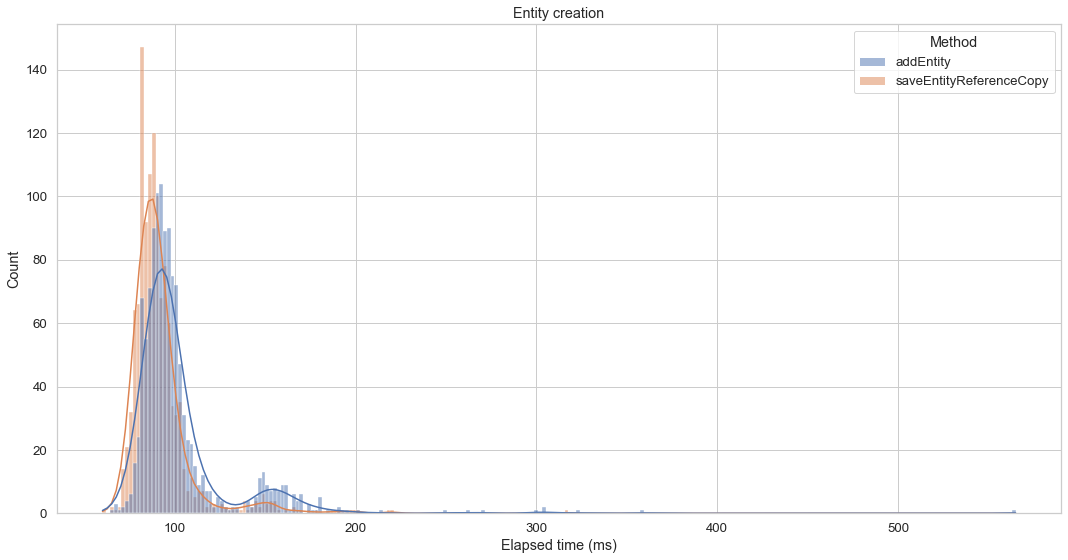

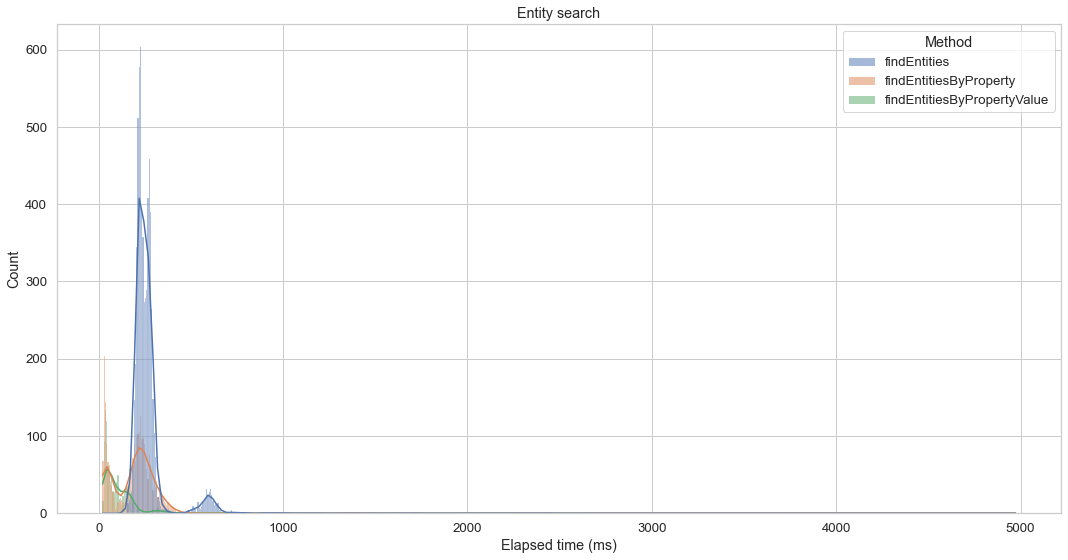

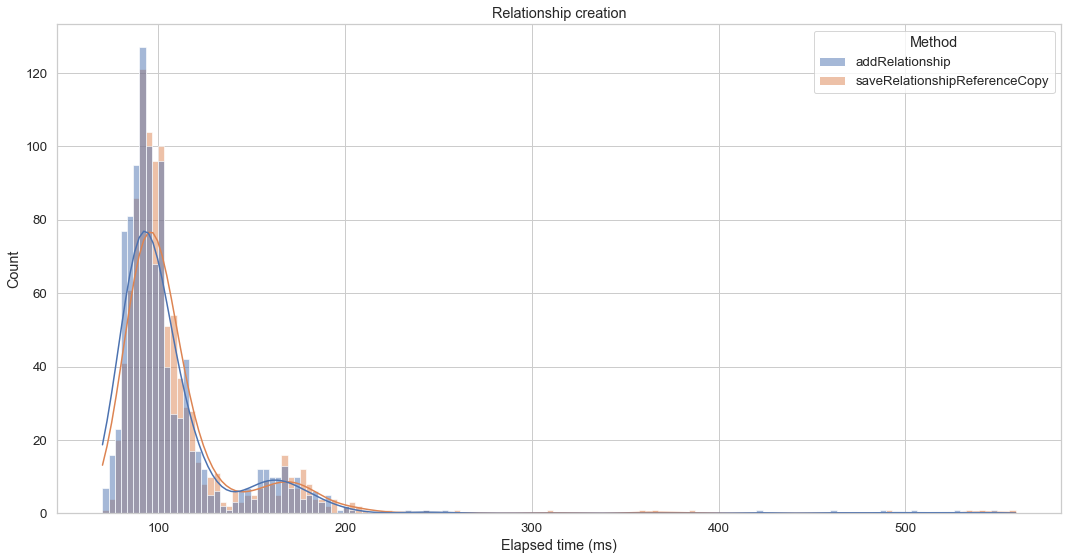

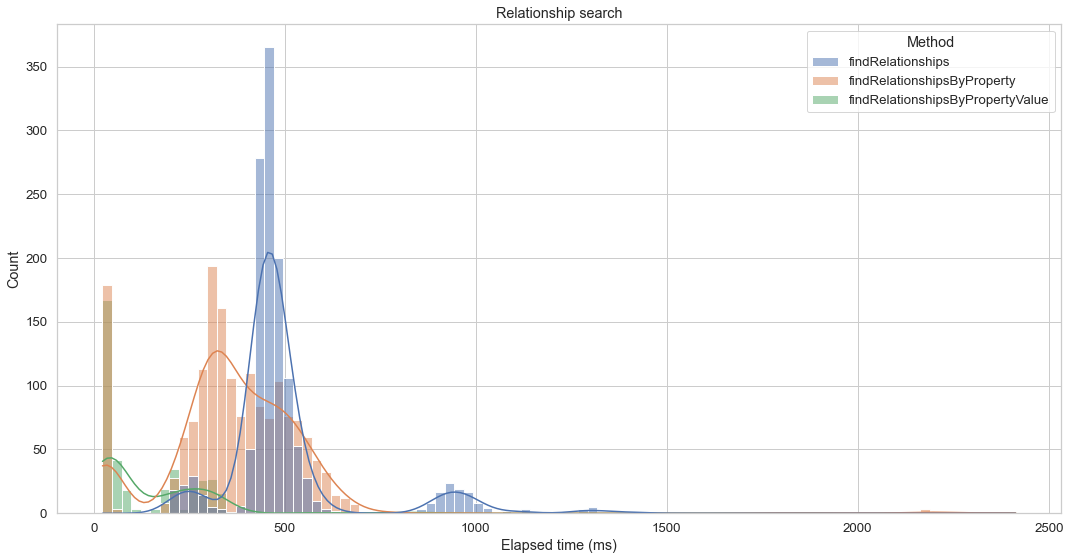

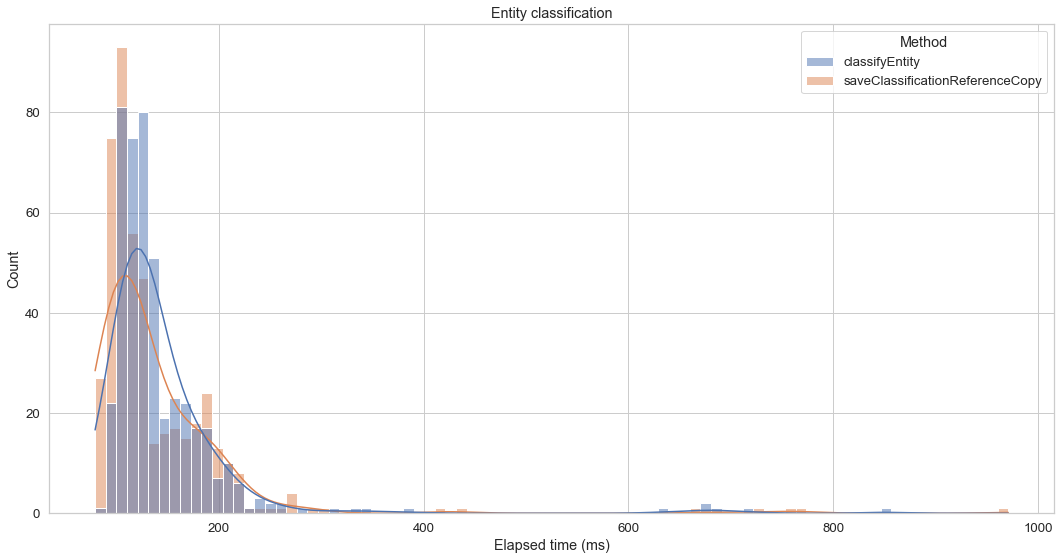

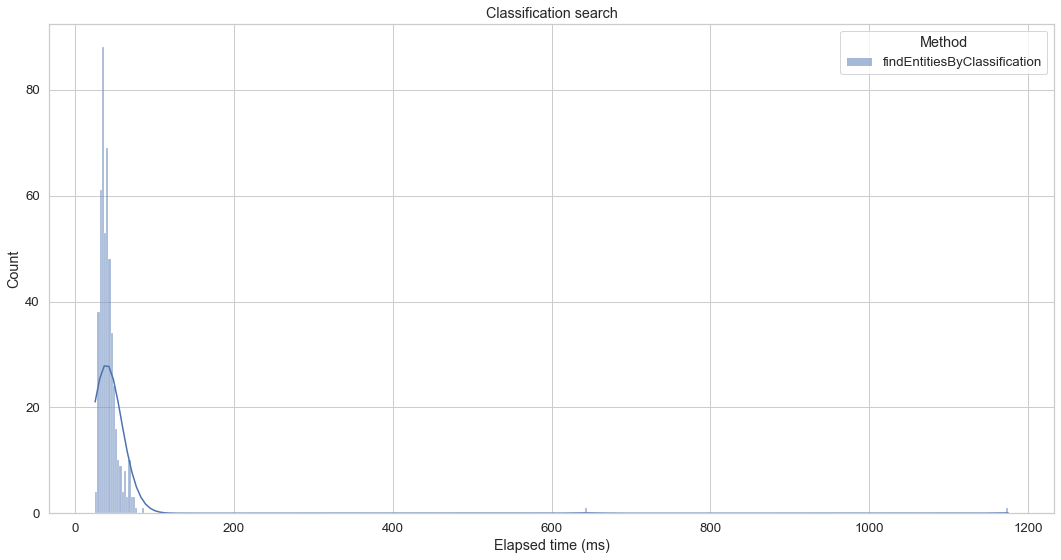

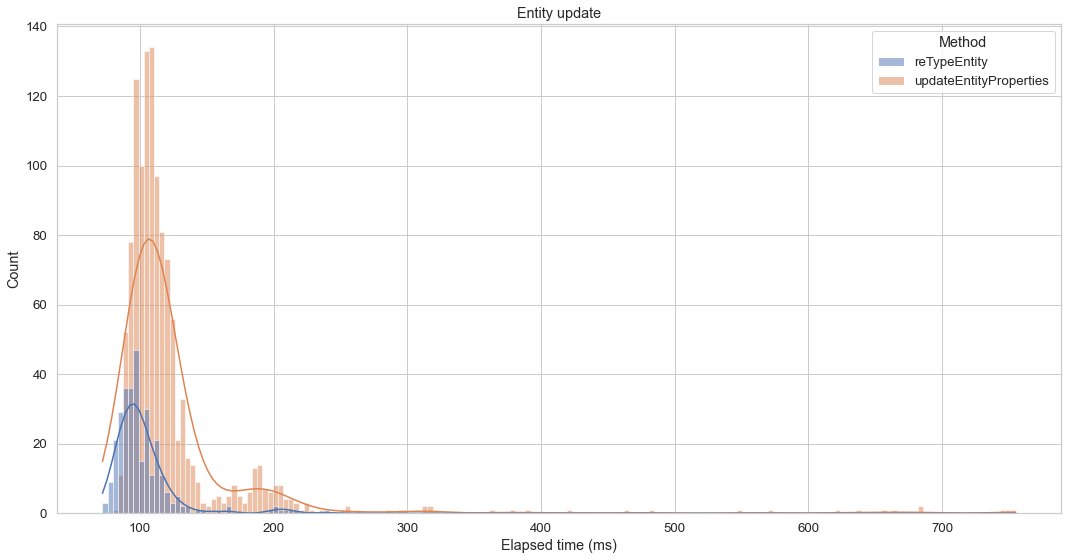

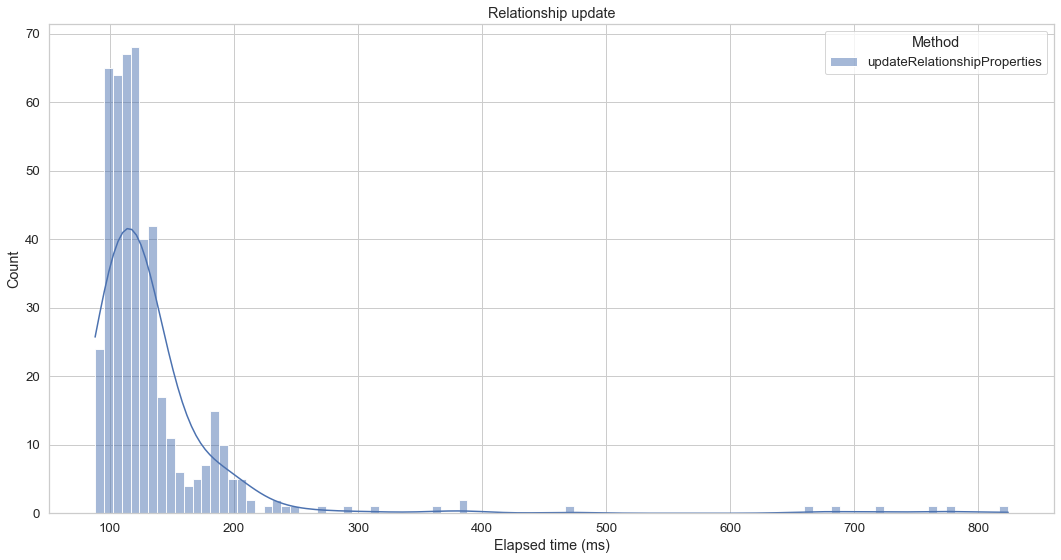

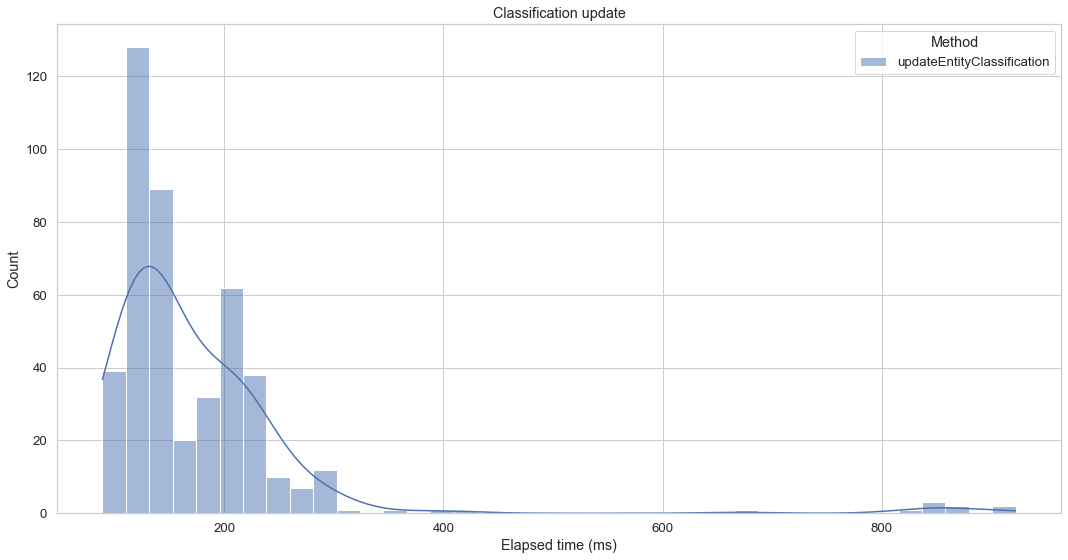

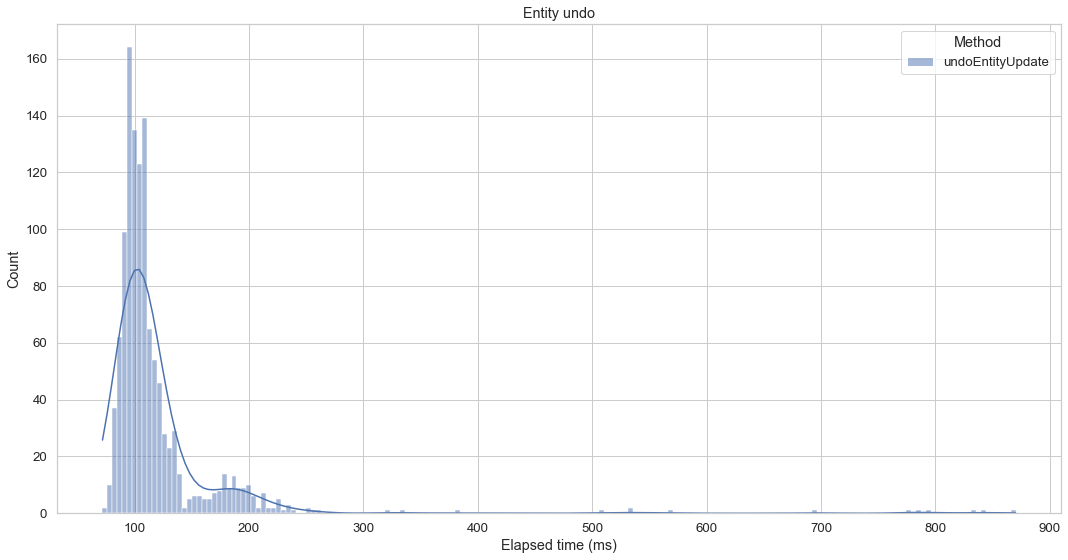

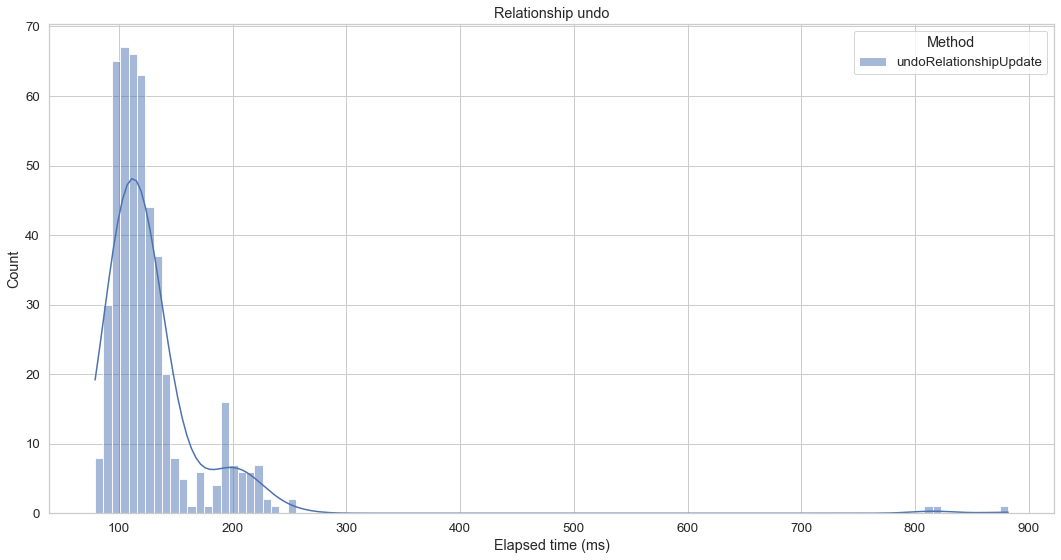

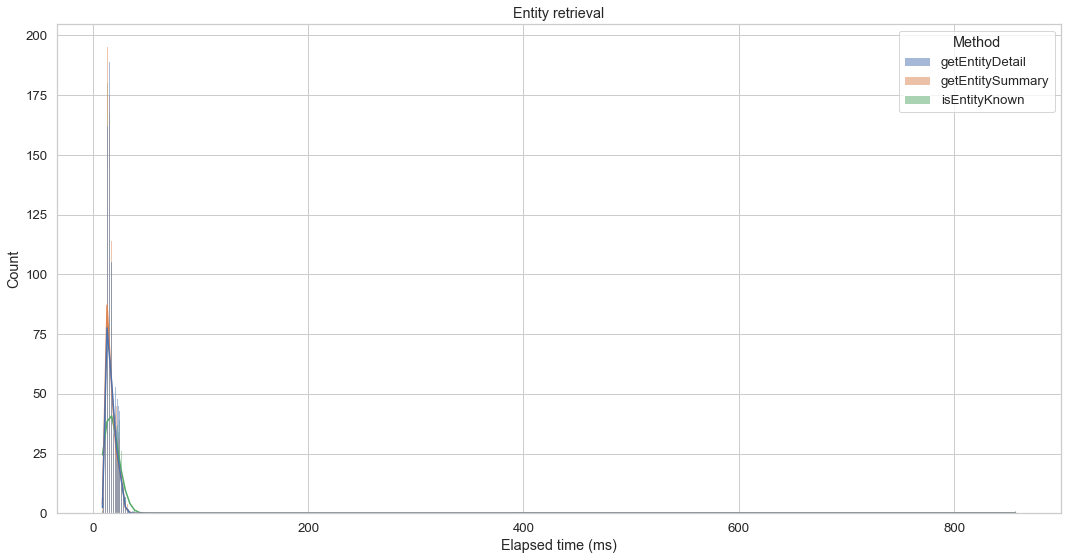

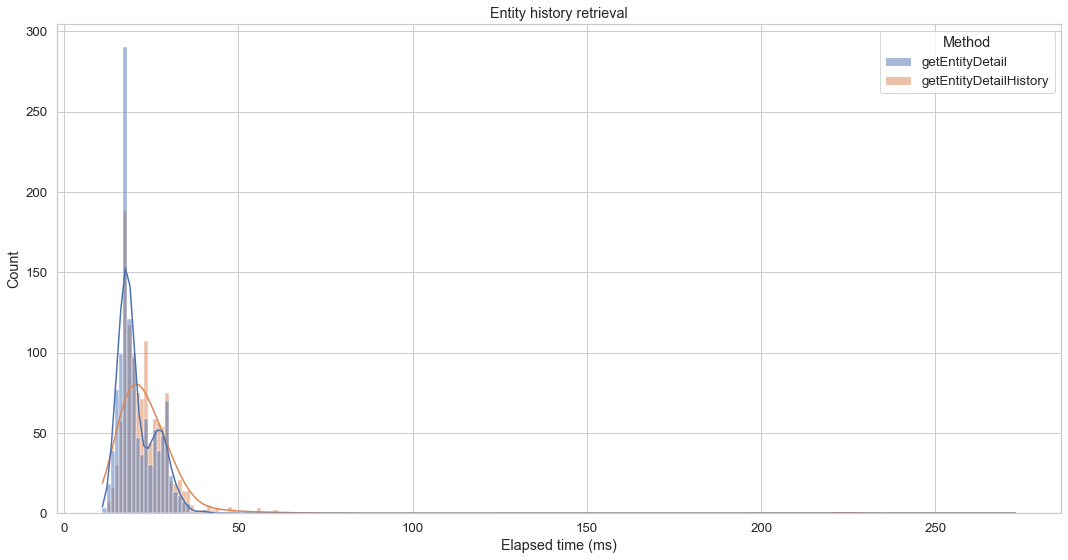

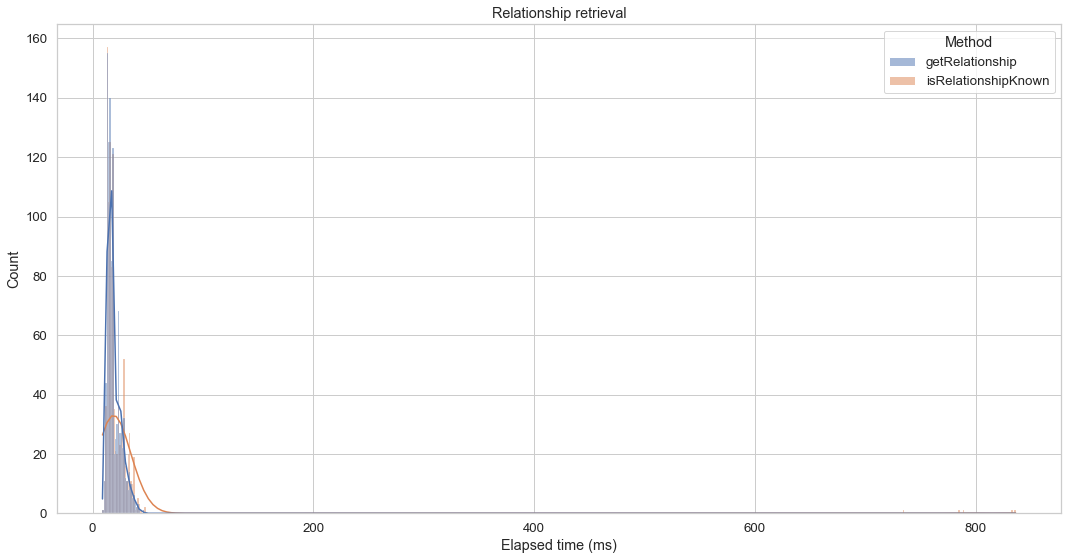

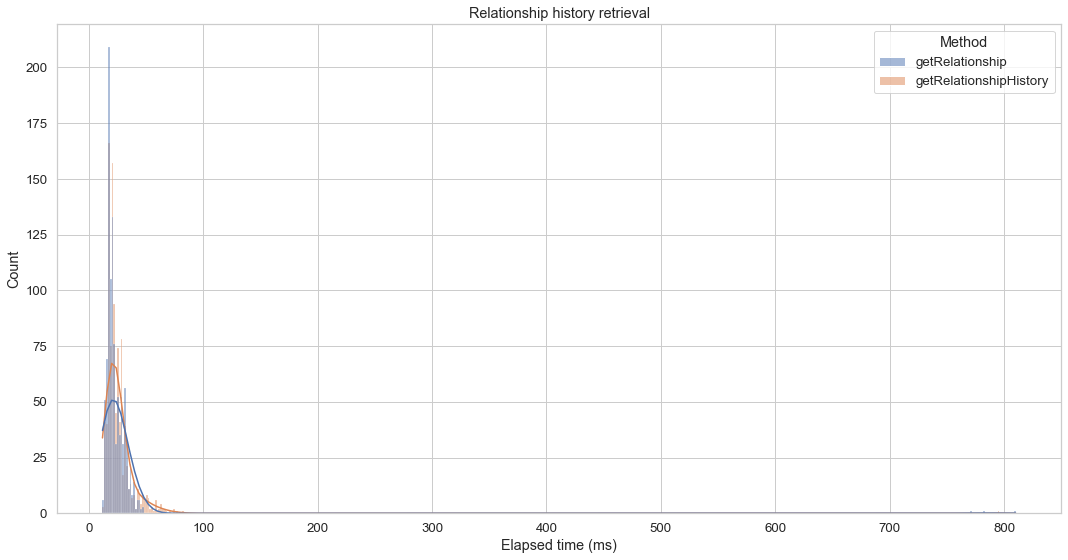

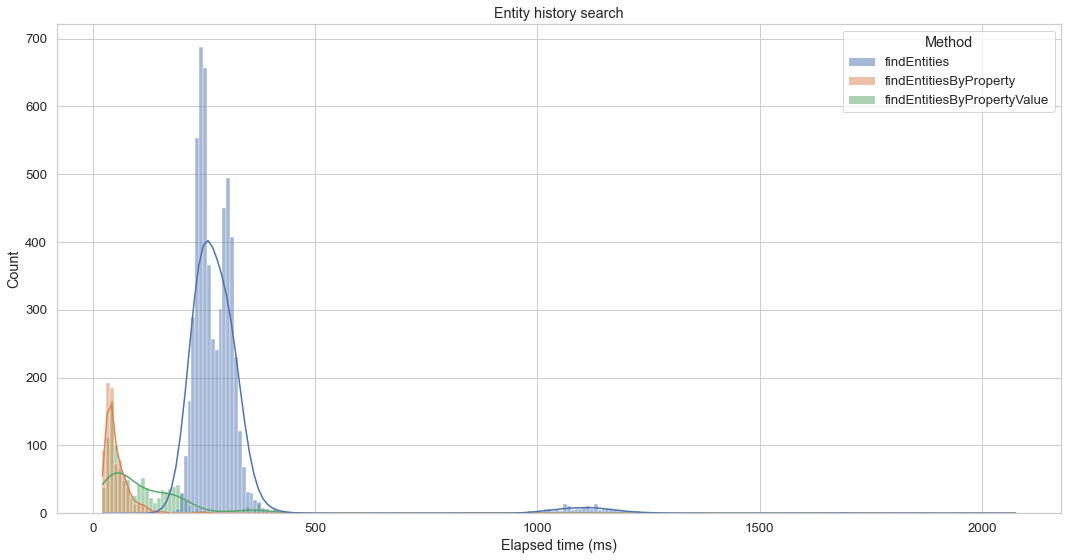

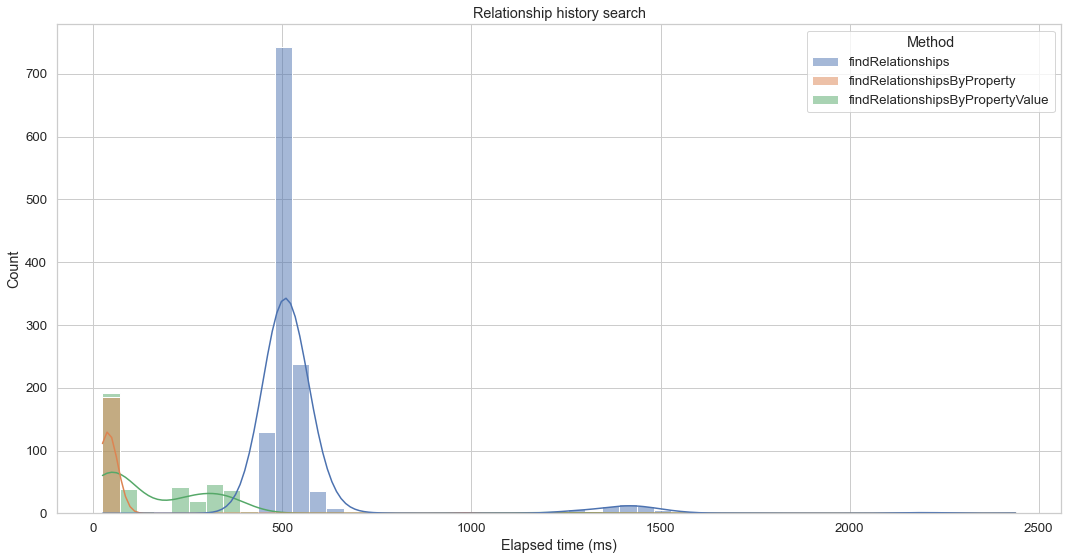

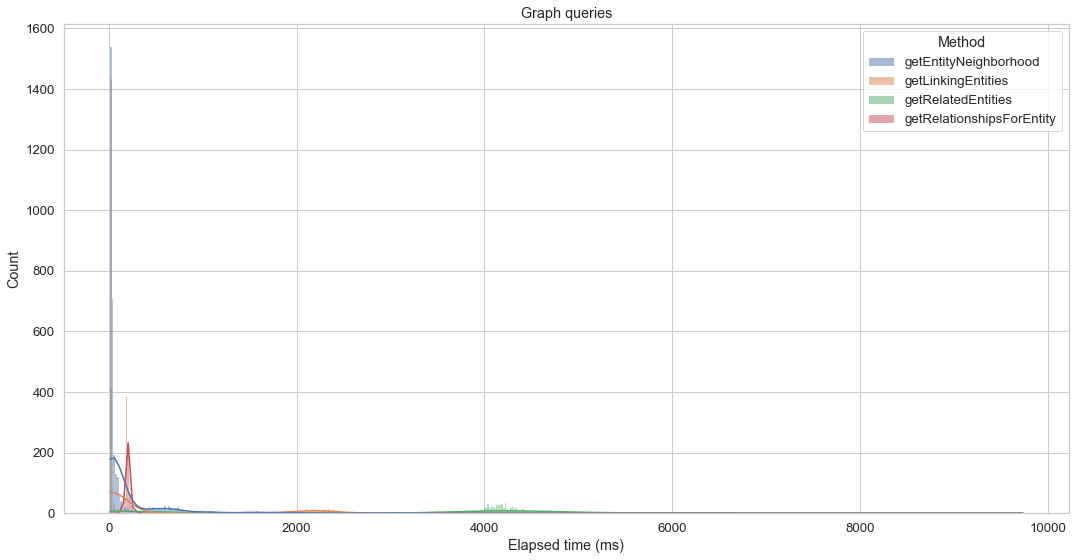

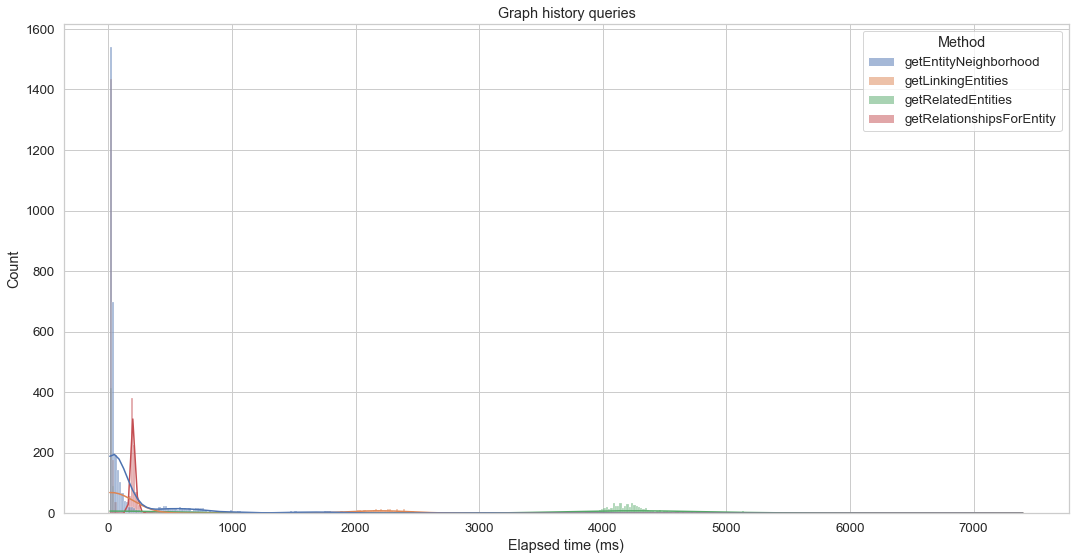

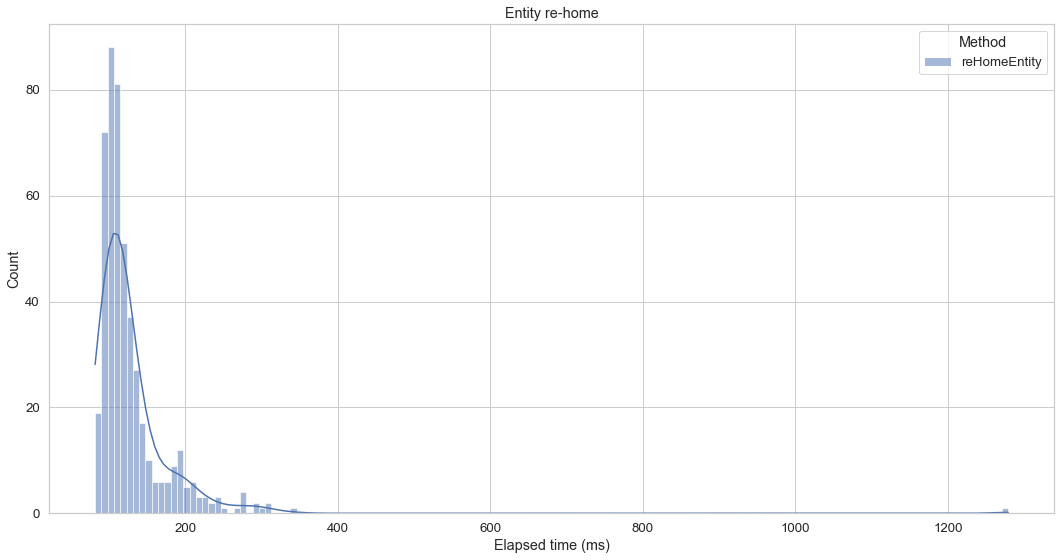

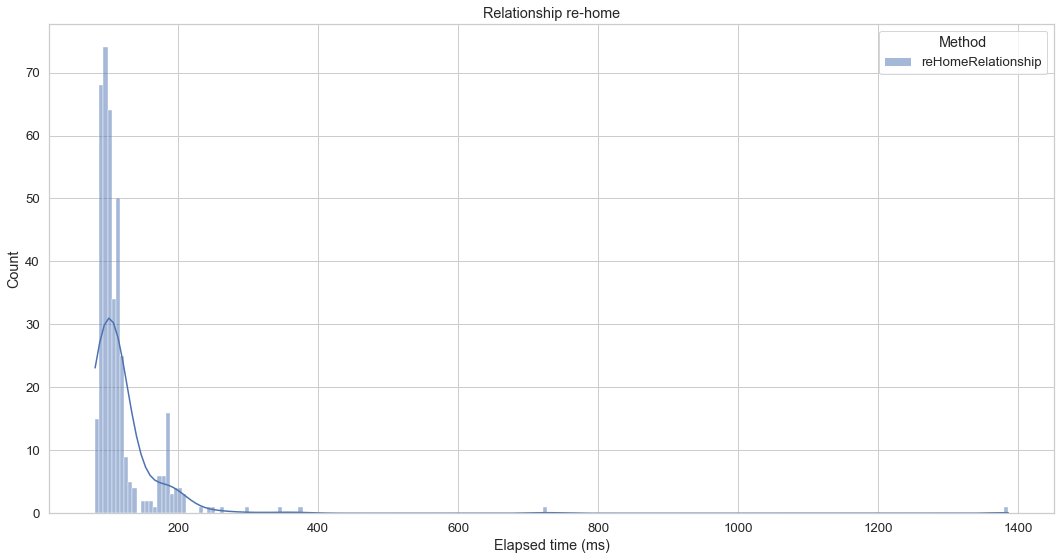

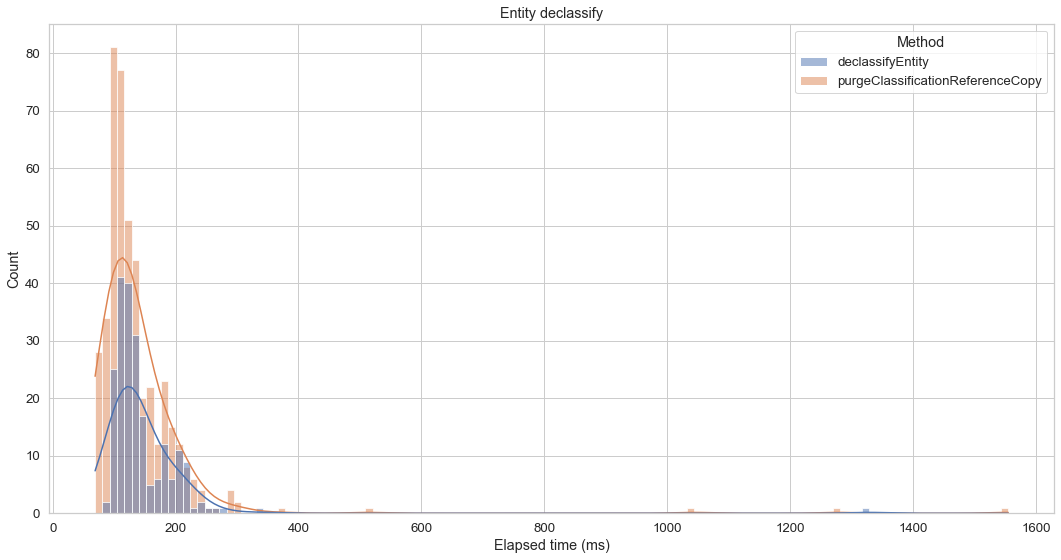

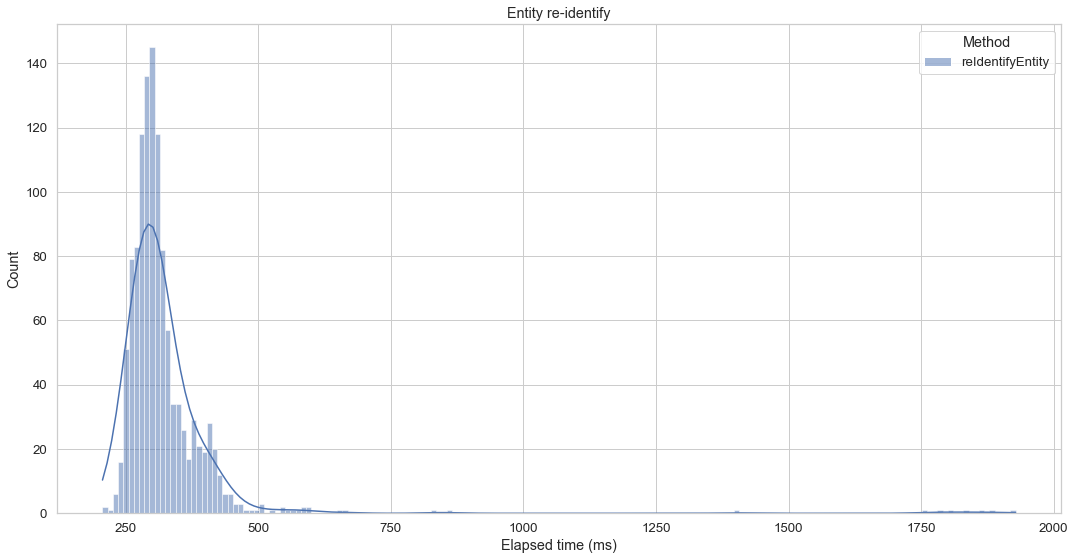

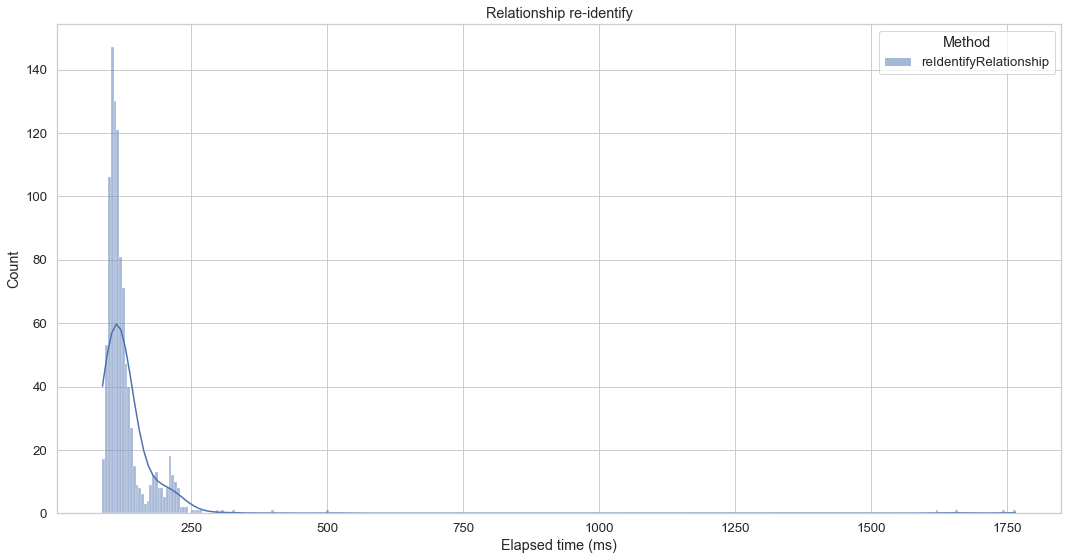

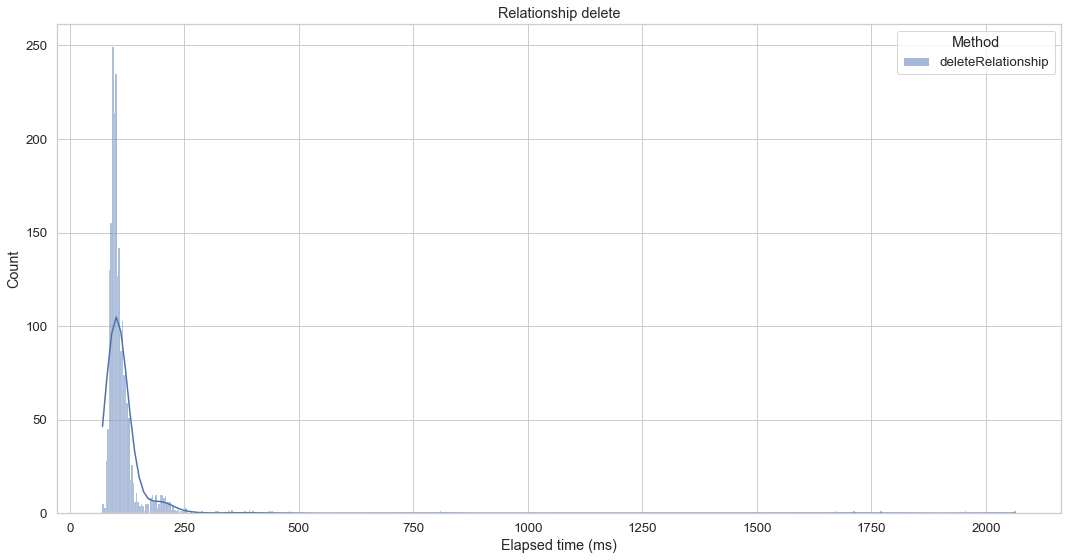

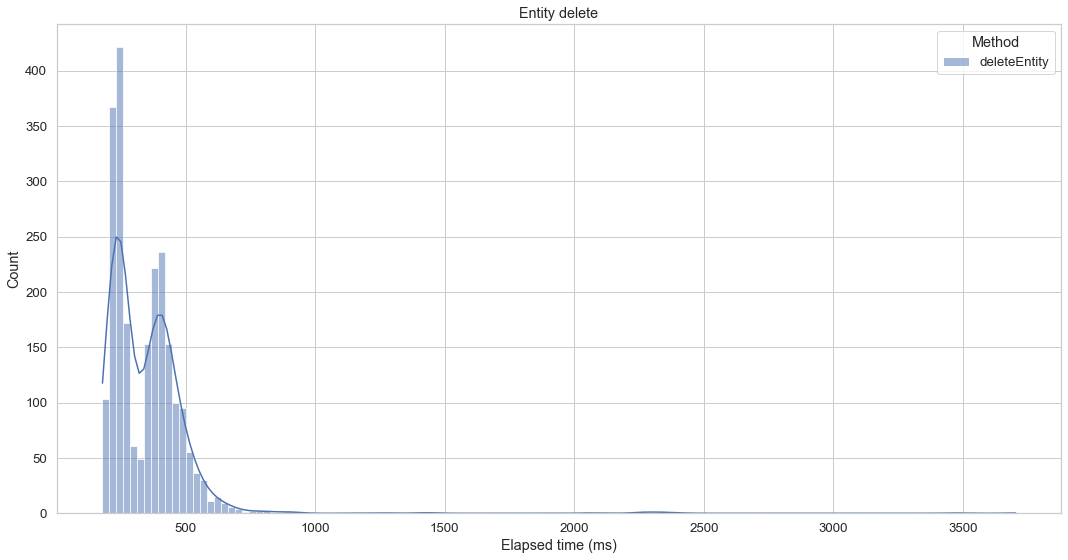

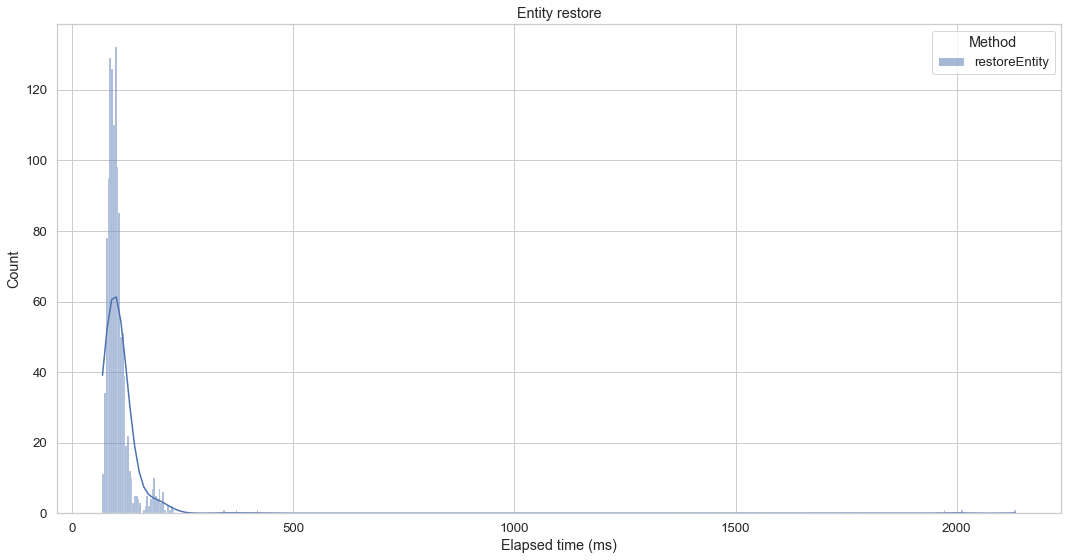

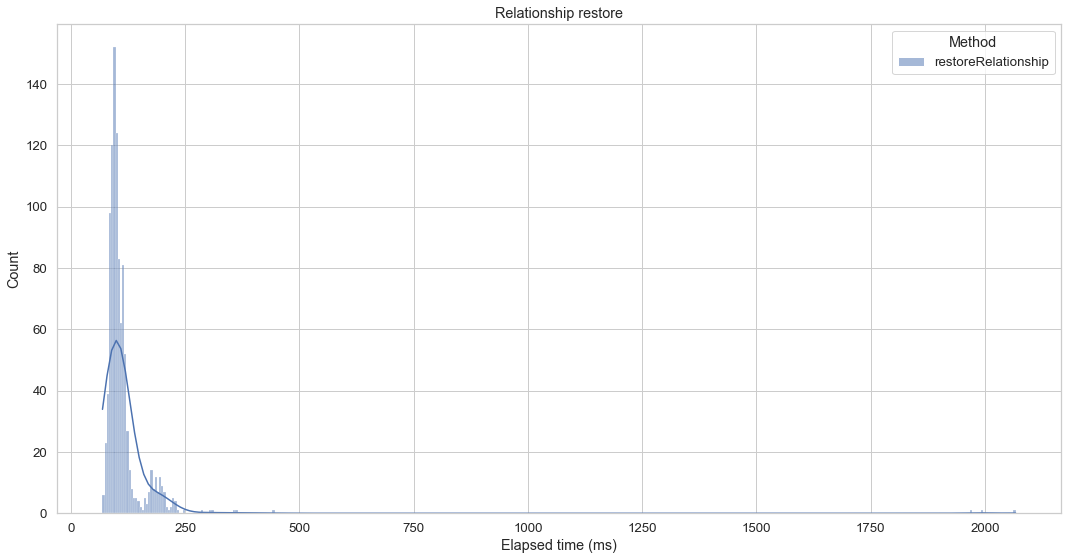

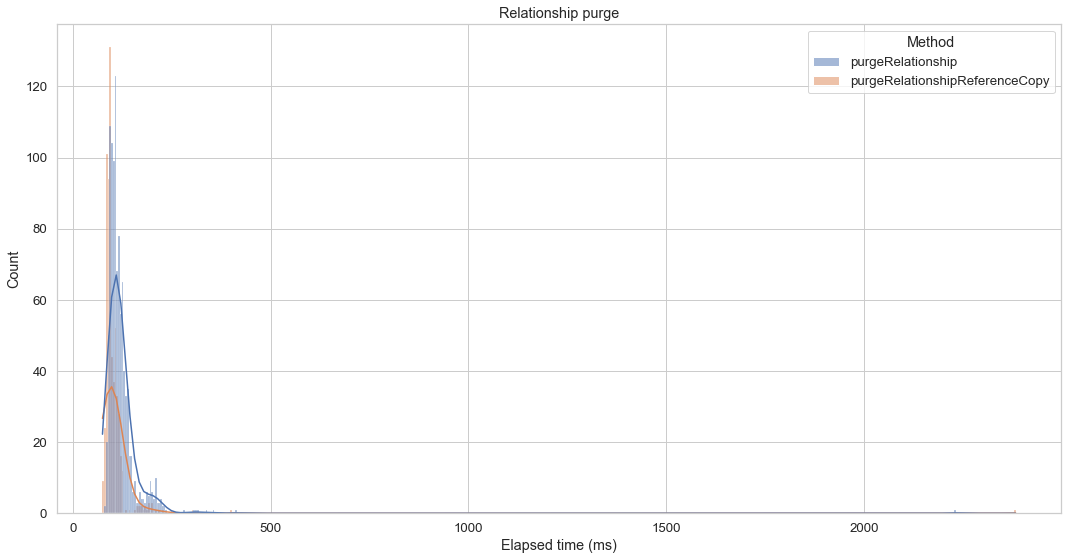

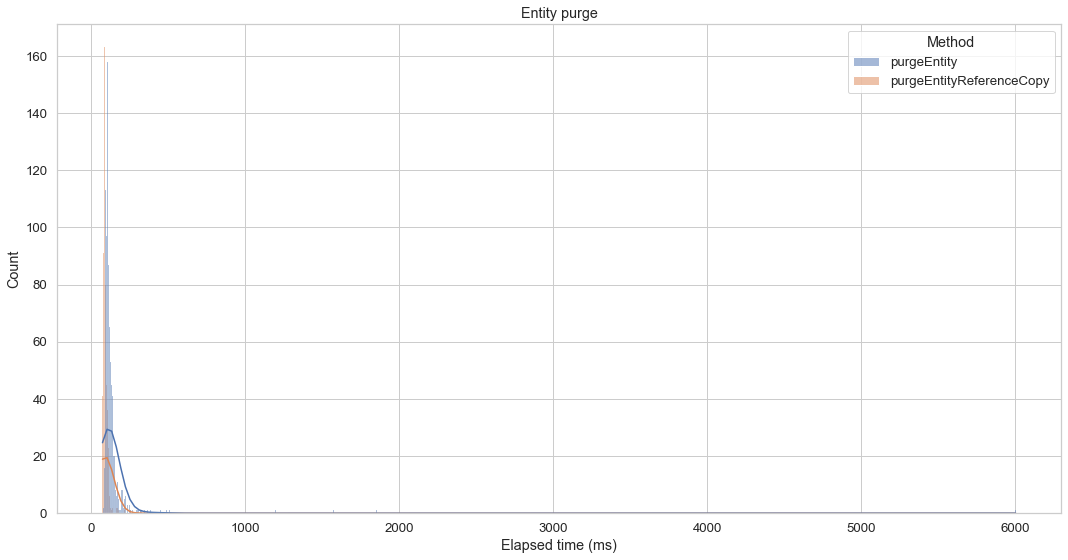

In [5]:
for profile in profile_order:
    plotProfile(df1, profile)

#### Analysis

From the plots above we can see that most methods have very high peaks towards the left of the graph: indicating that the vast majority of the executions of that method have response times in that range. However, there are a number of cases where various methods run for much longer than this usual response time (even up to several seconds).

To see whether these are rare outliers, we may want to re-plot the profiles again: this time ignoring the slowest 1% of the values in the response times. Stated differently, this will show the response time of 99% of the method calls: if there is a consistently-slow combination of parameters, we will expect it to show up as part of this 99% cut-off point in these plots.

### "Typical" response time profiles

The following plots the response times of each method within each profile focusing only on the typical values -- specifically removing any outliers within the top and bottom 2% of the response times. From these visualizations, we can quickly see the "typical" response times for a given method, keeping in mind that we are ignoring the outlying extreme values here.

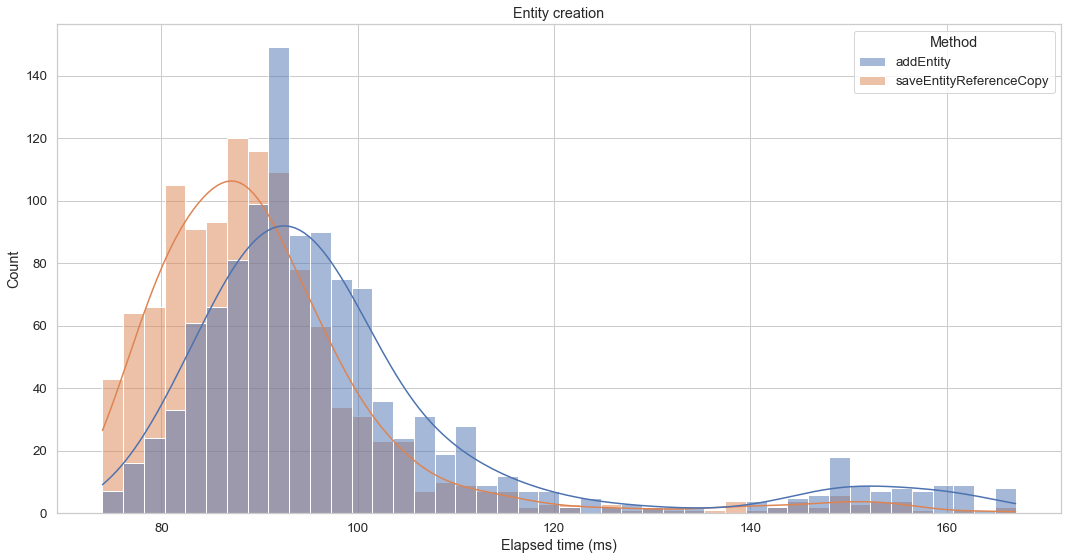

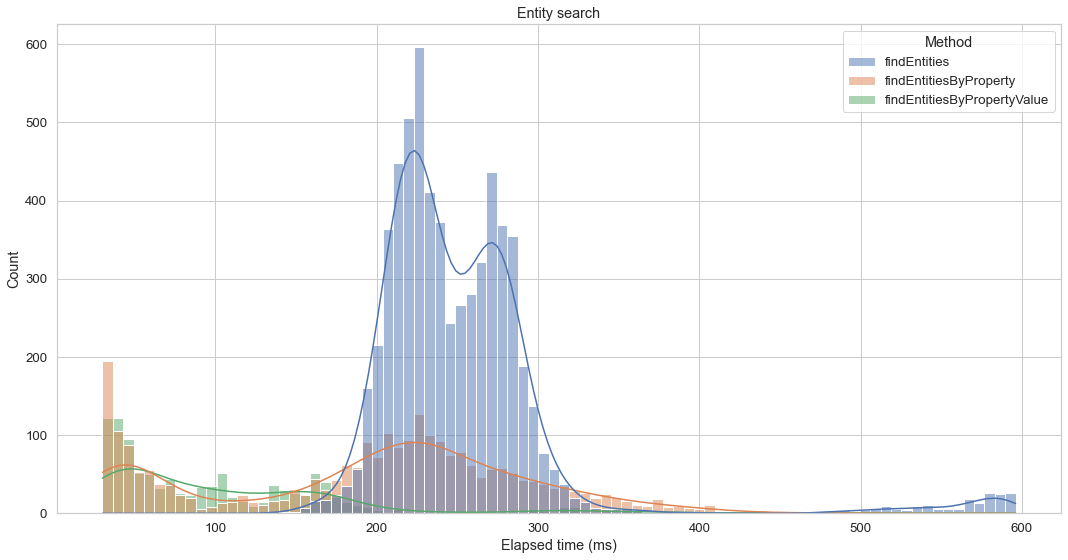

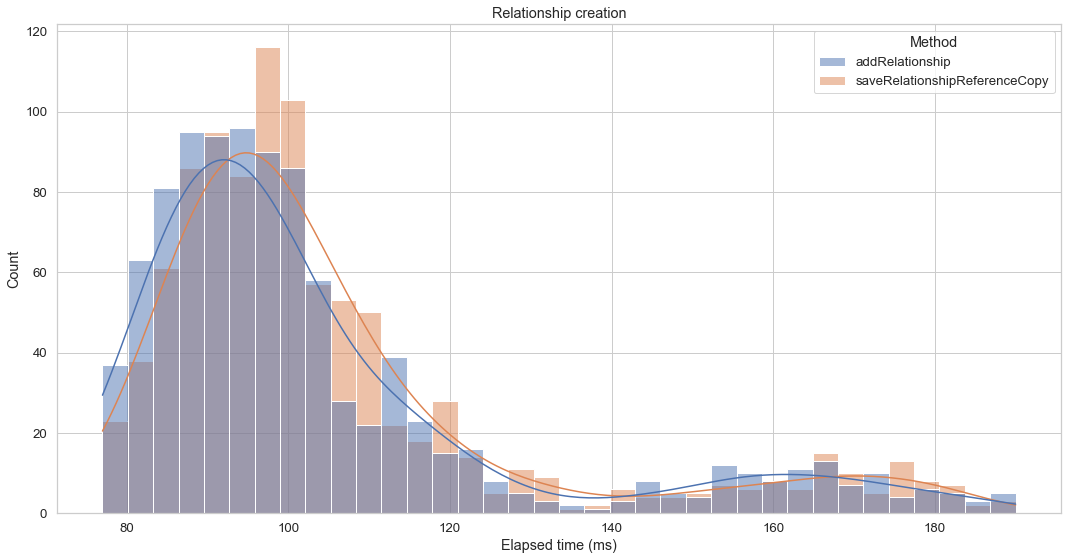

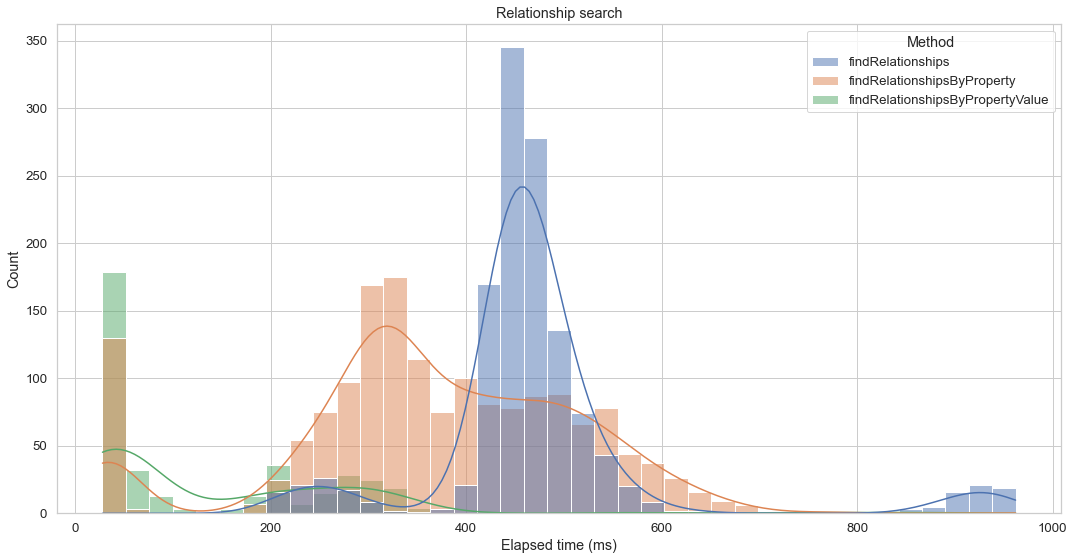

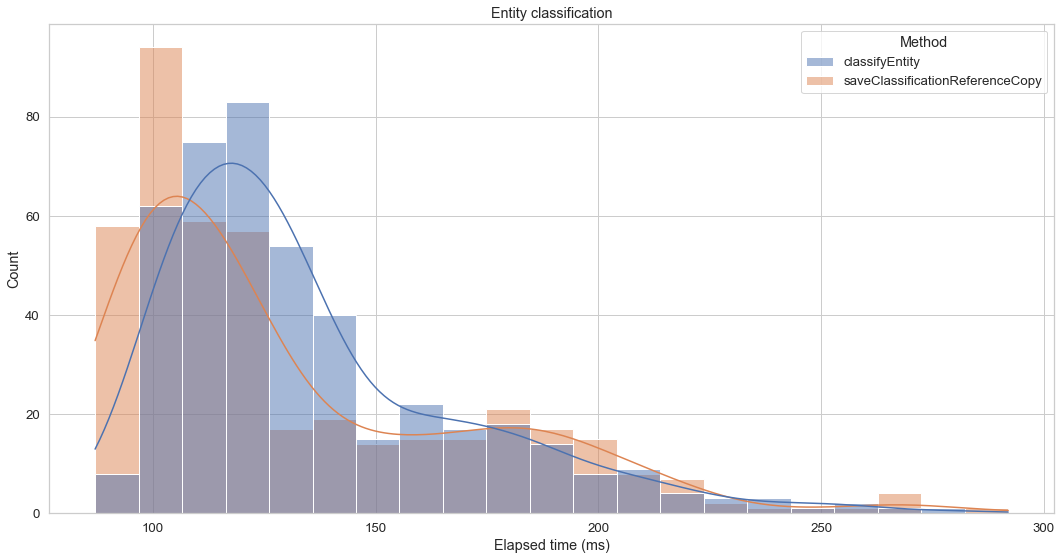

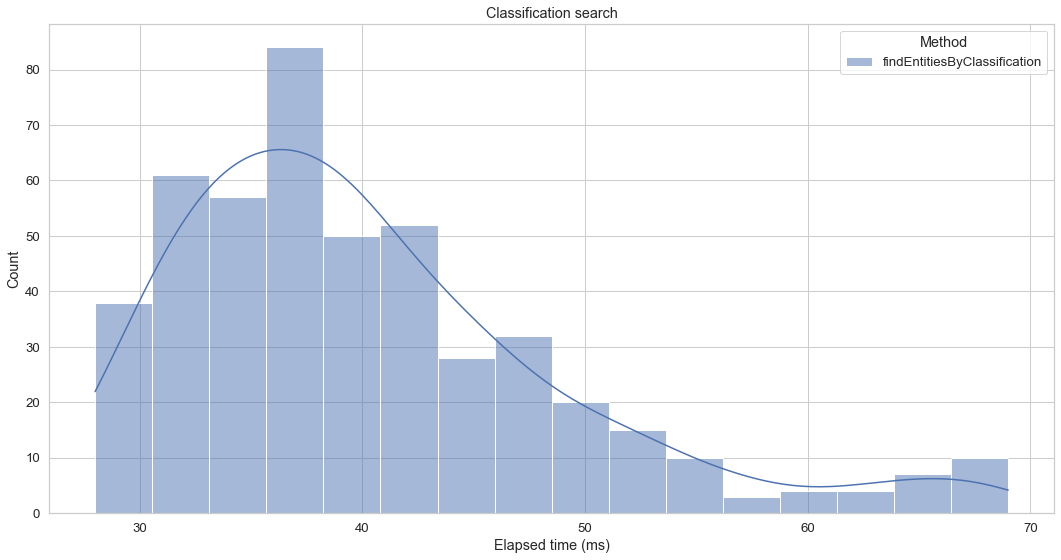

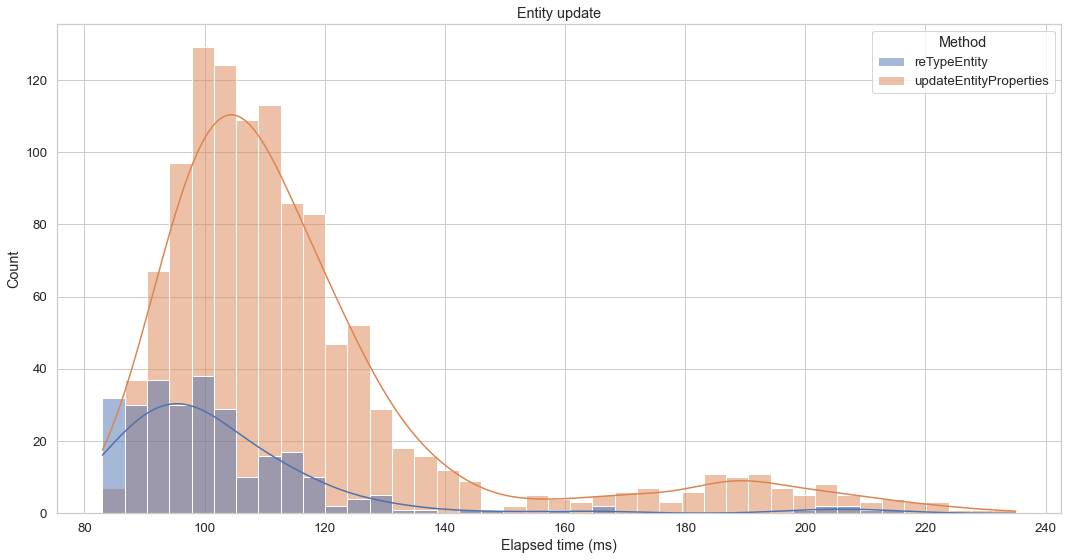

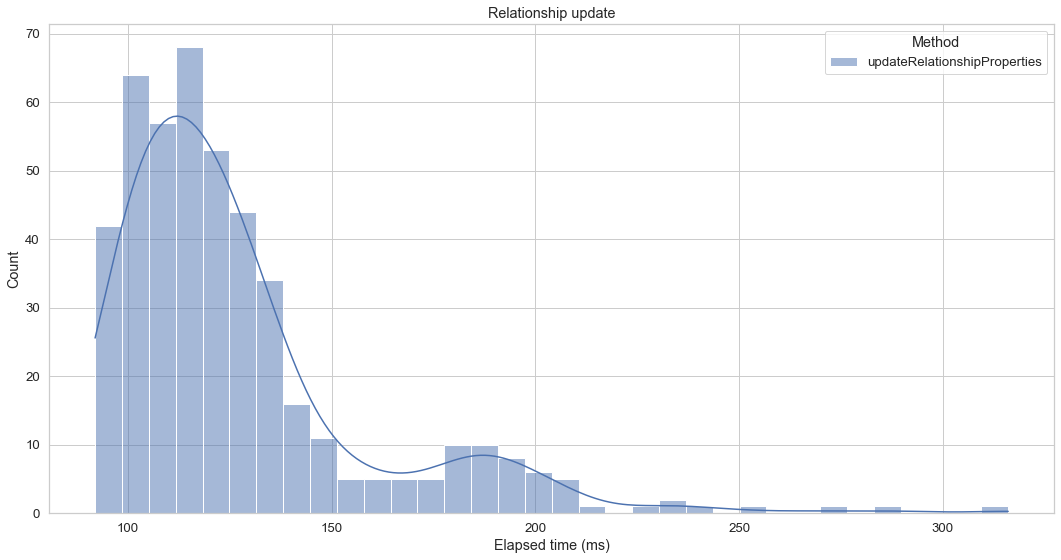

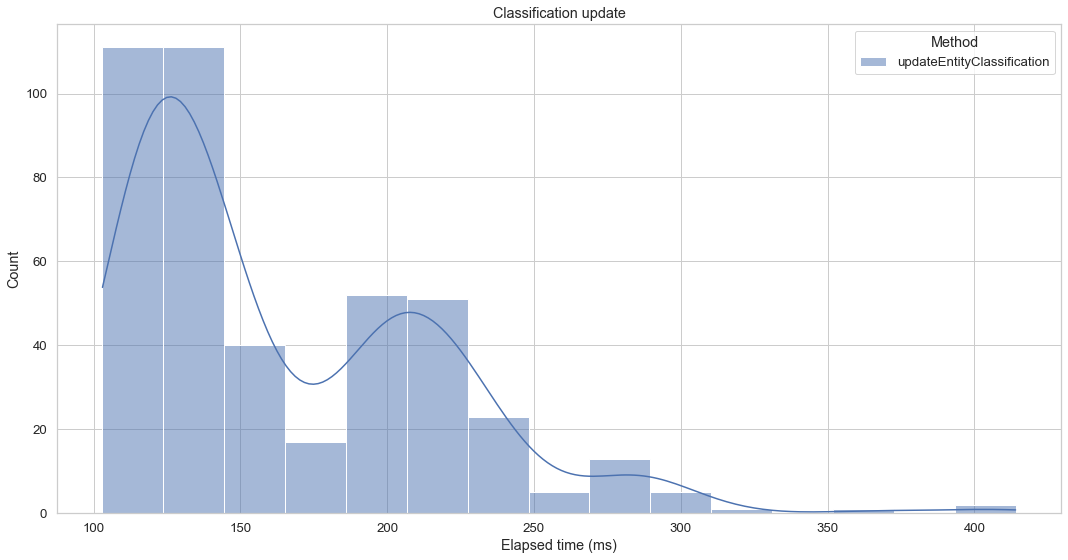

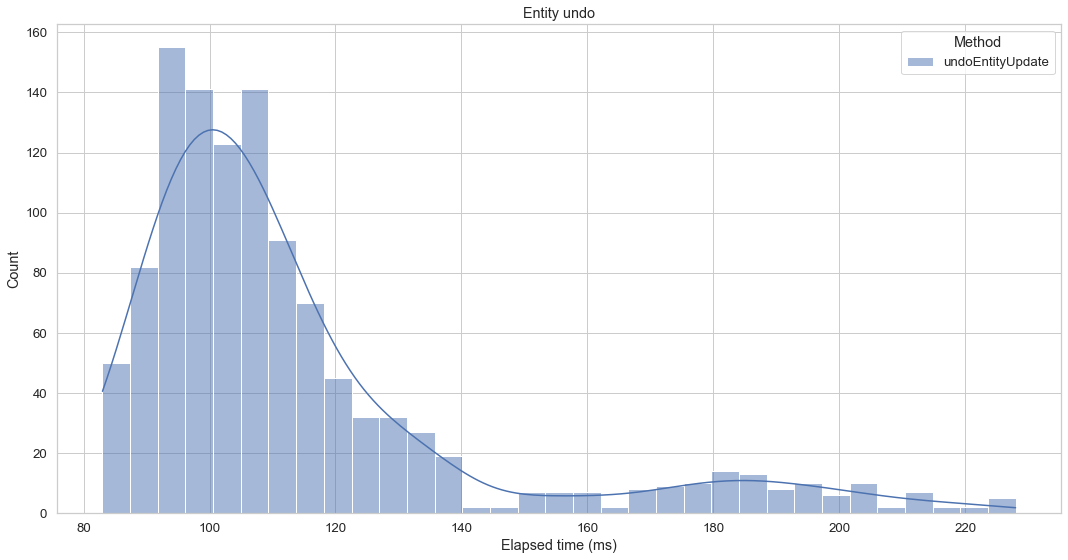

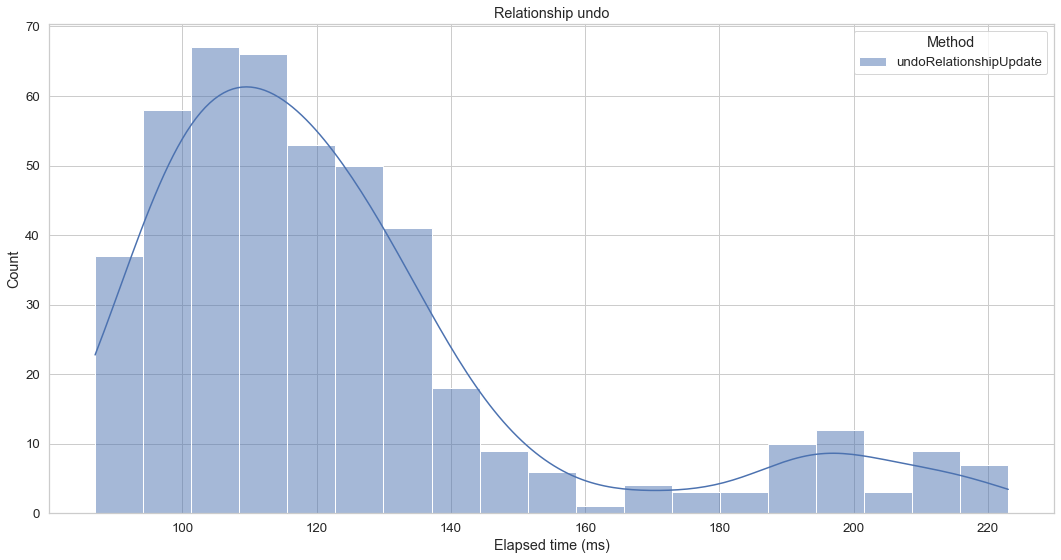

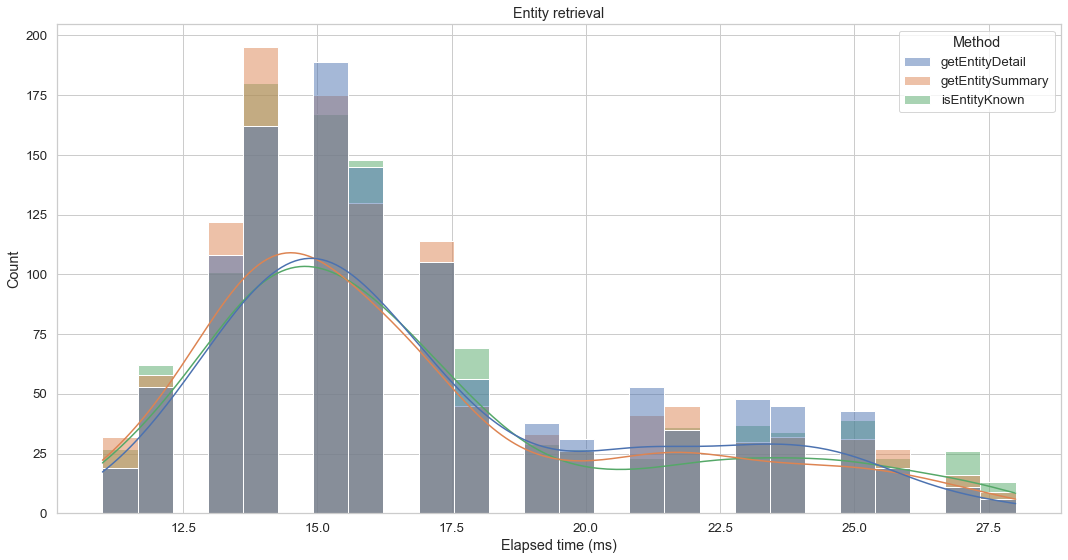

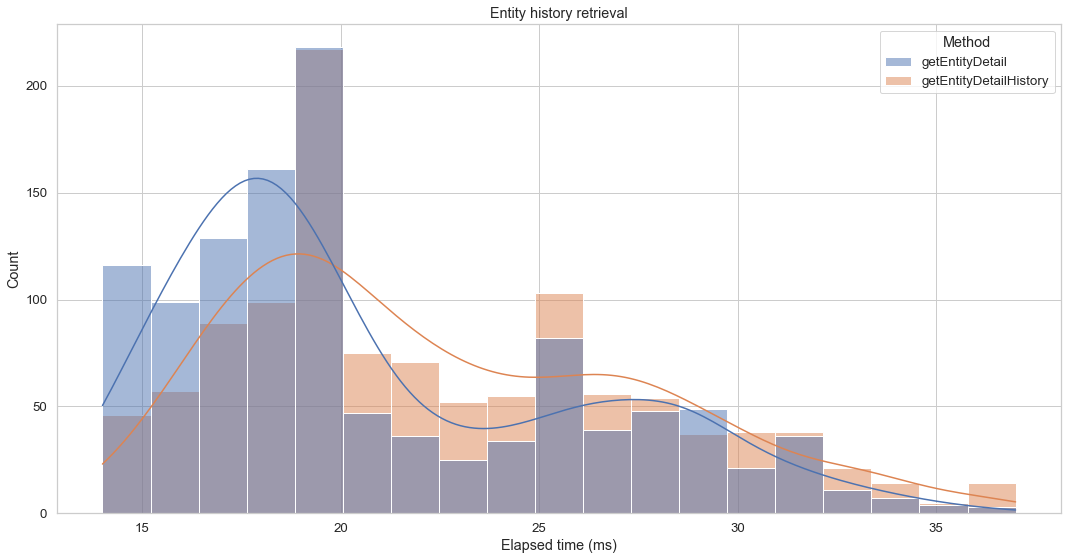

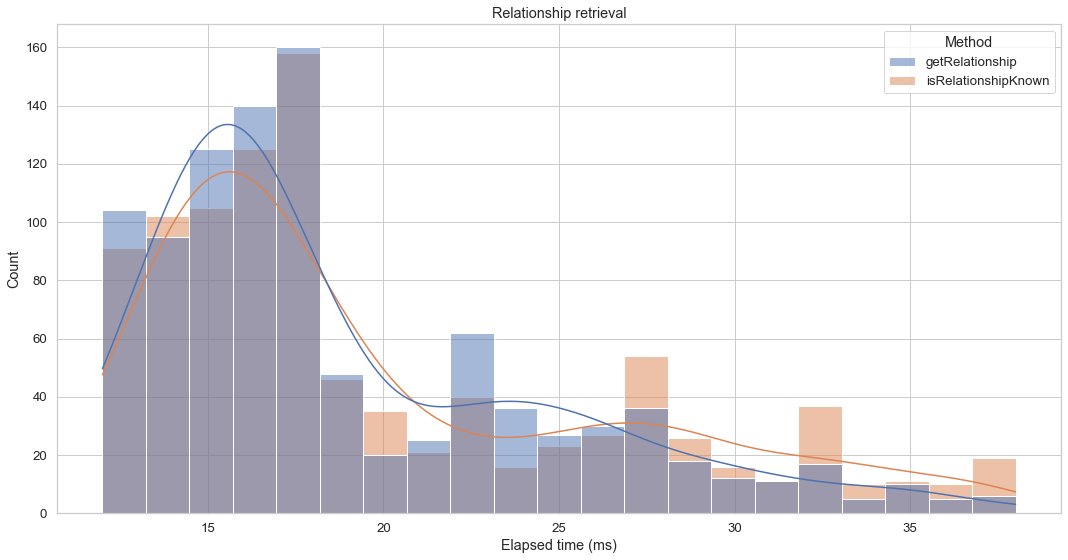

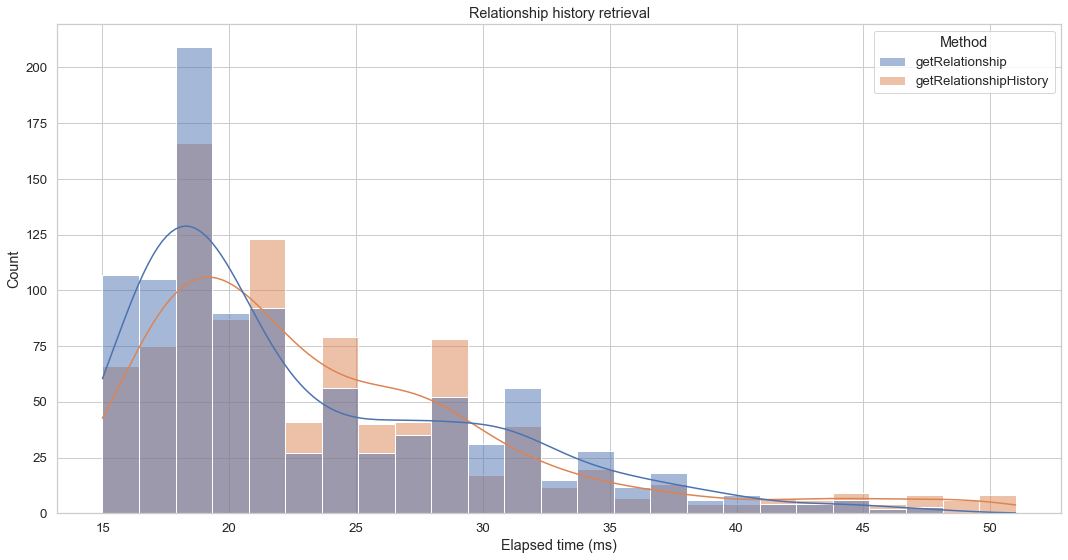

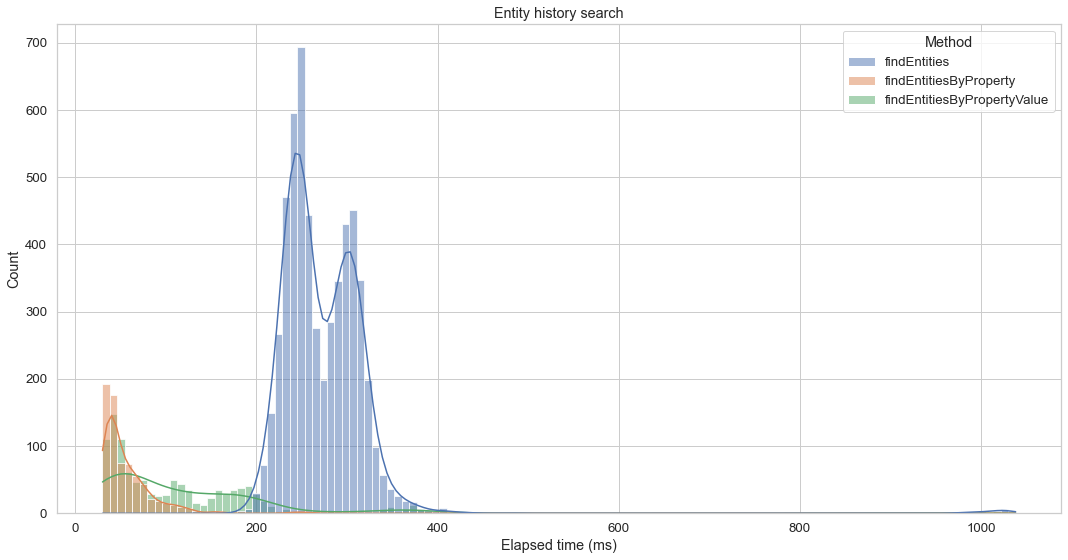

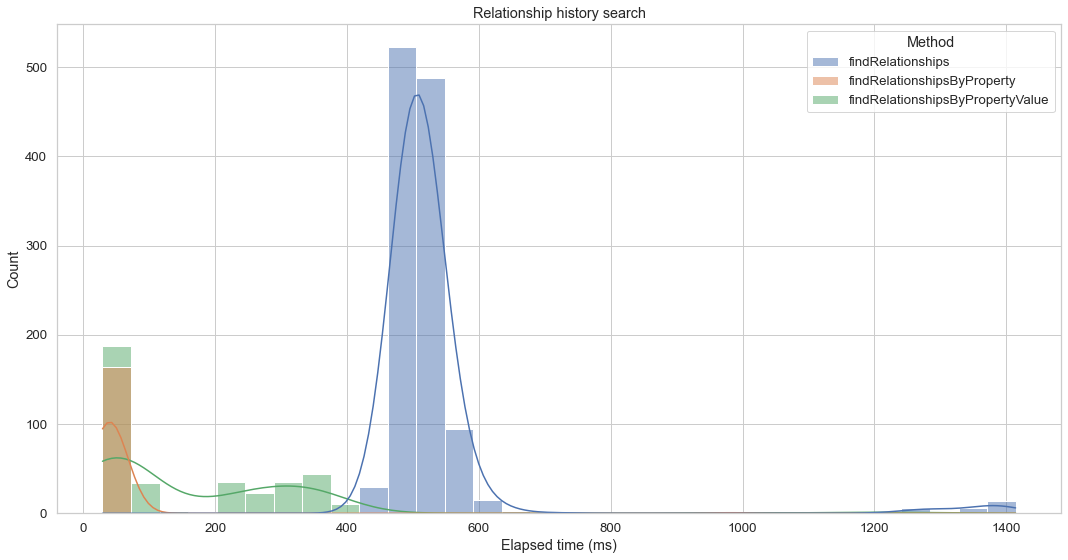

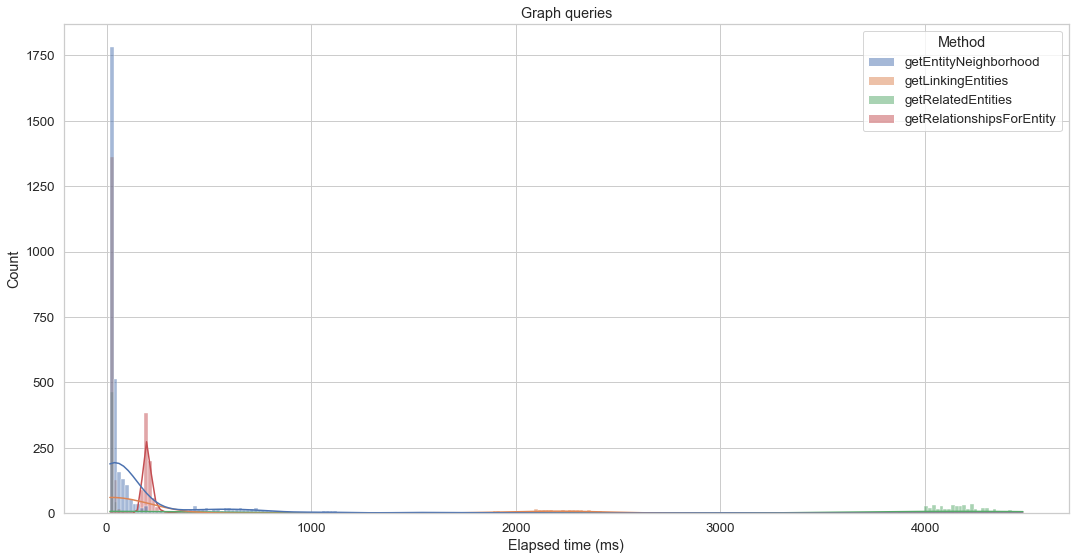

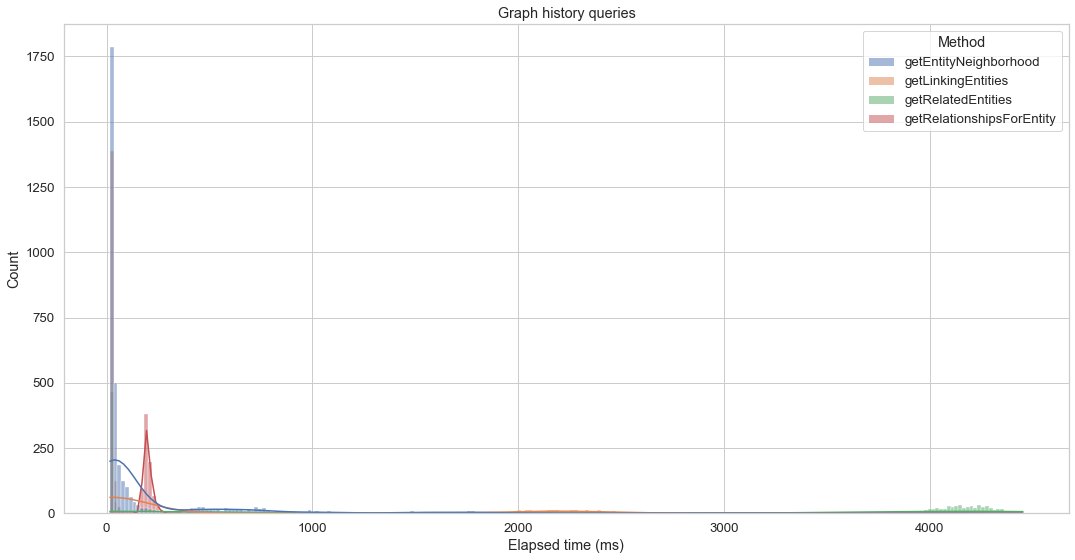

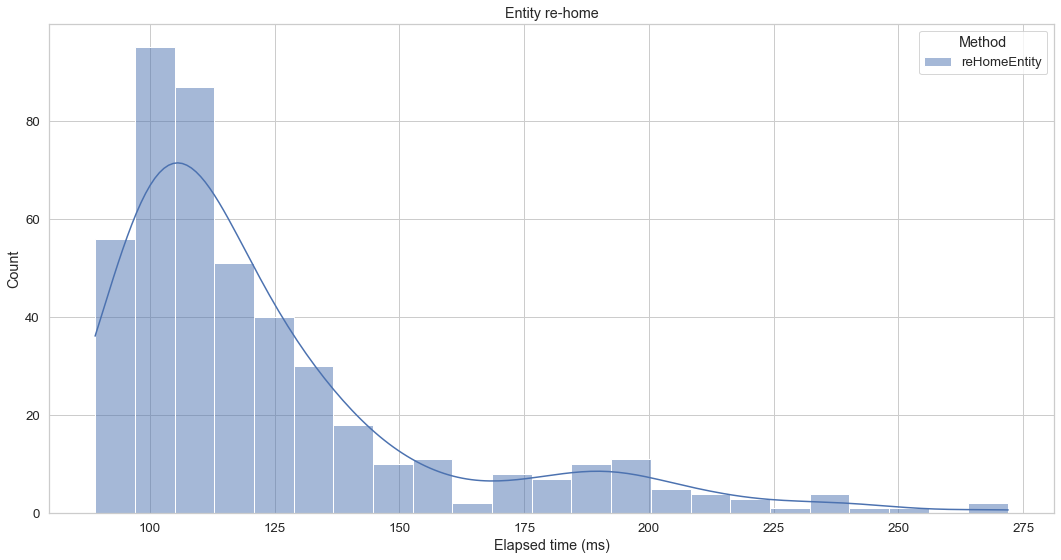

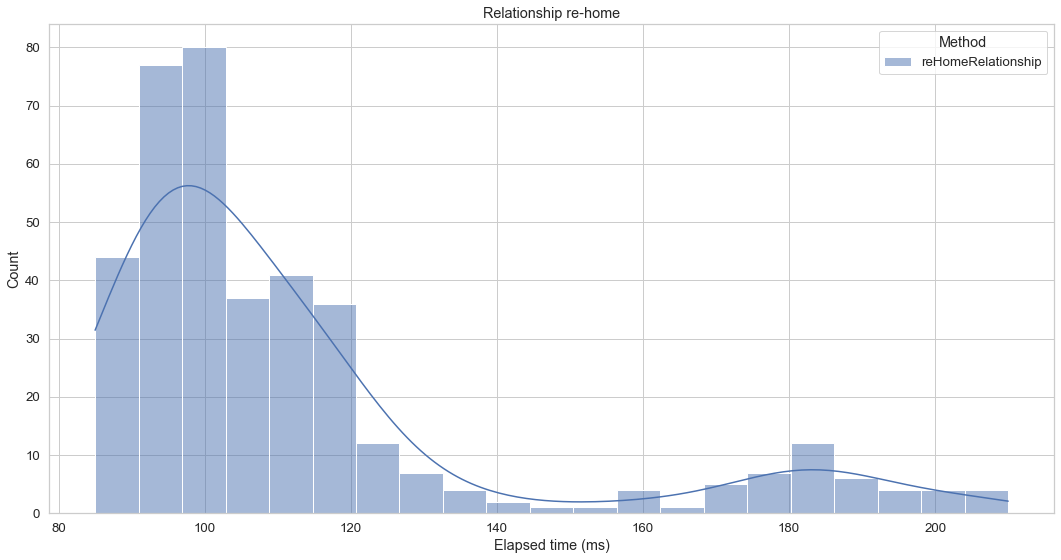

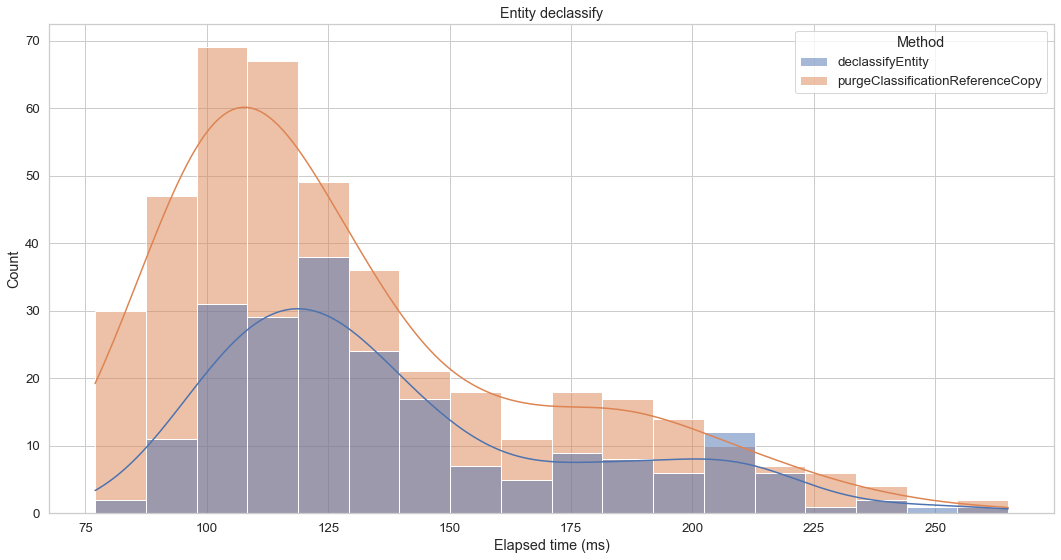

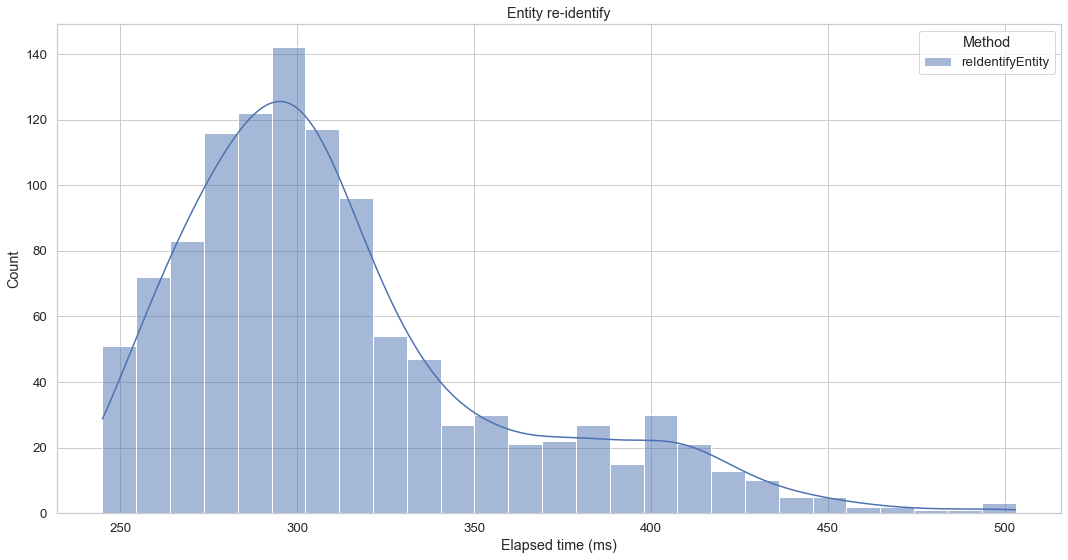

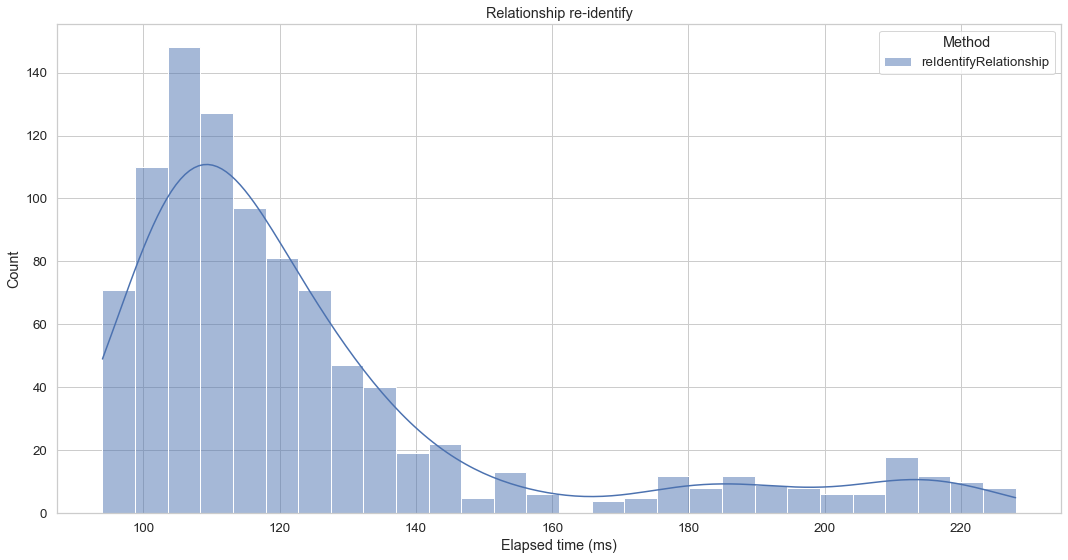

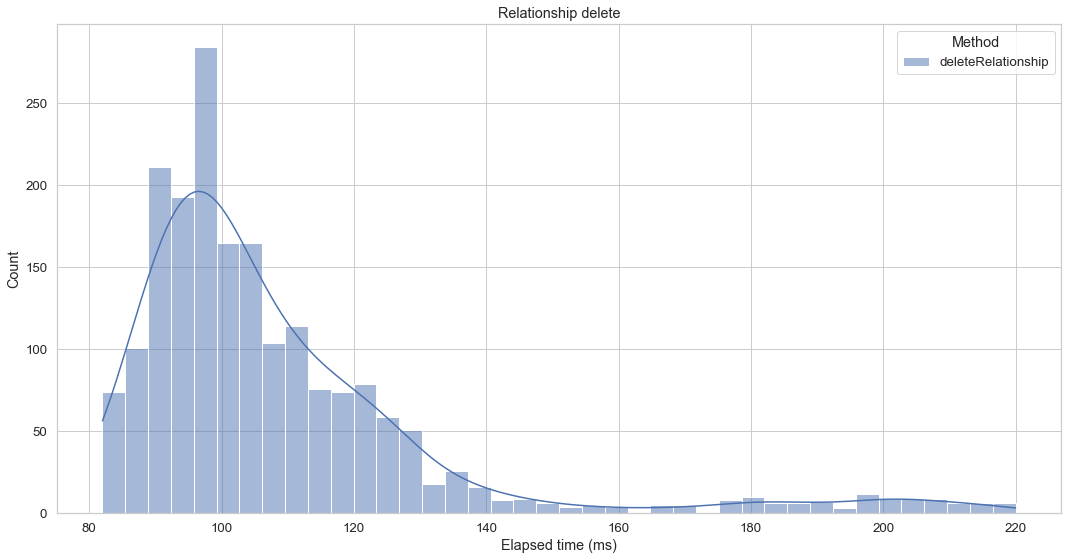

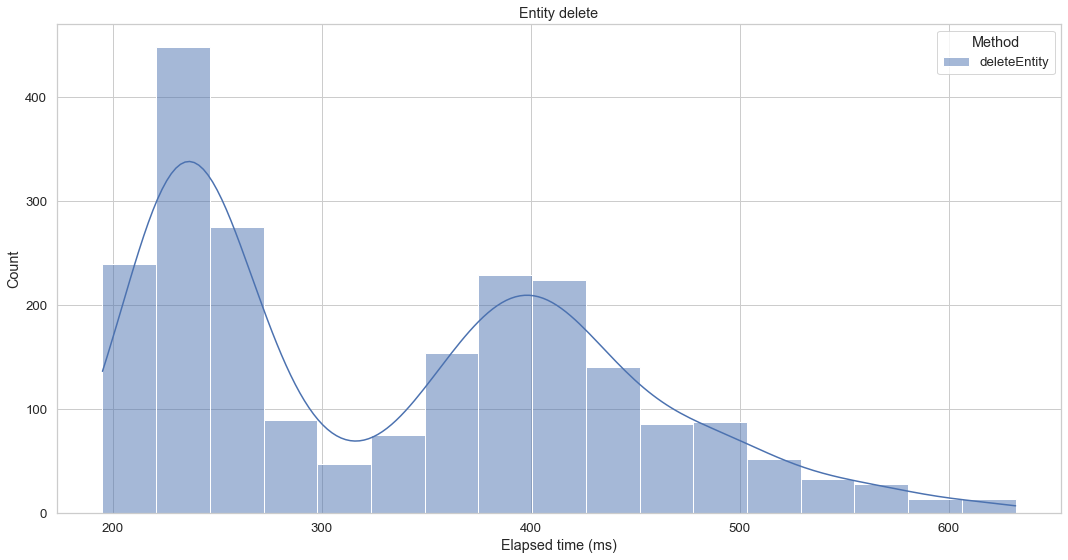

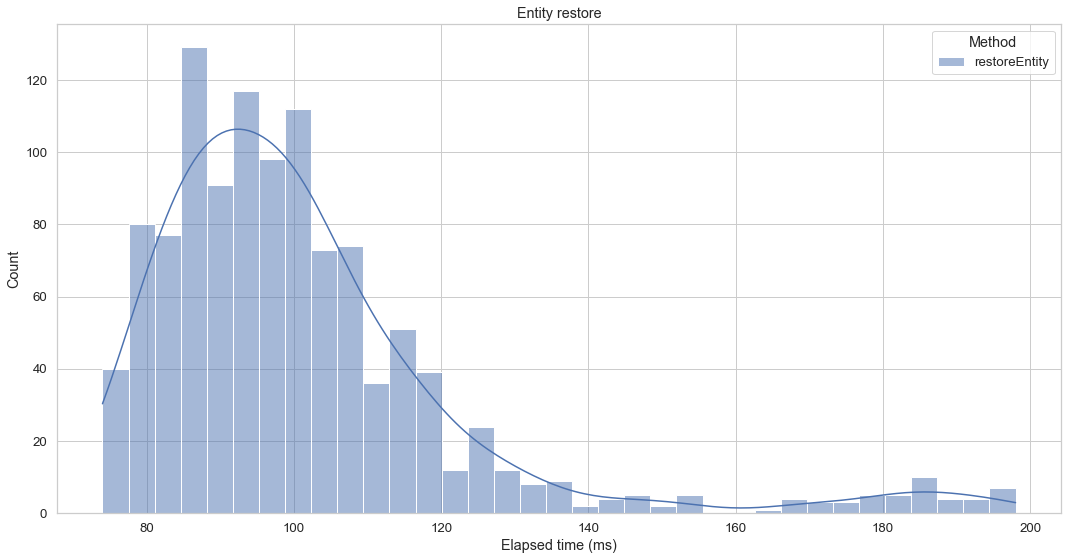

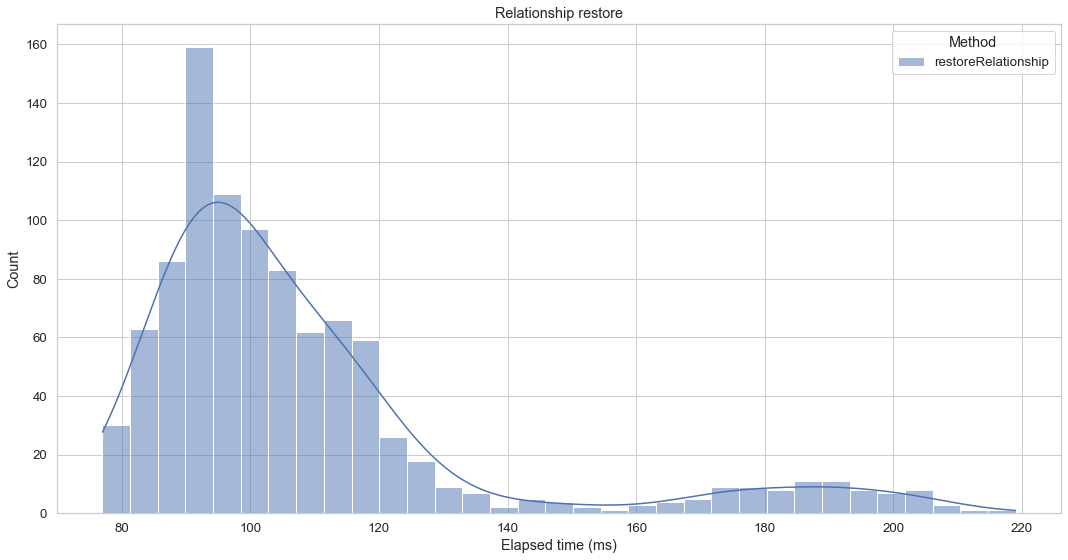

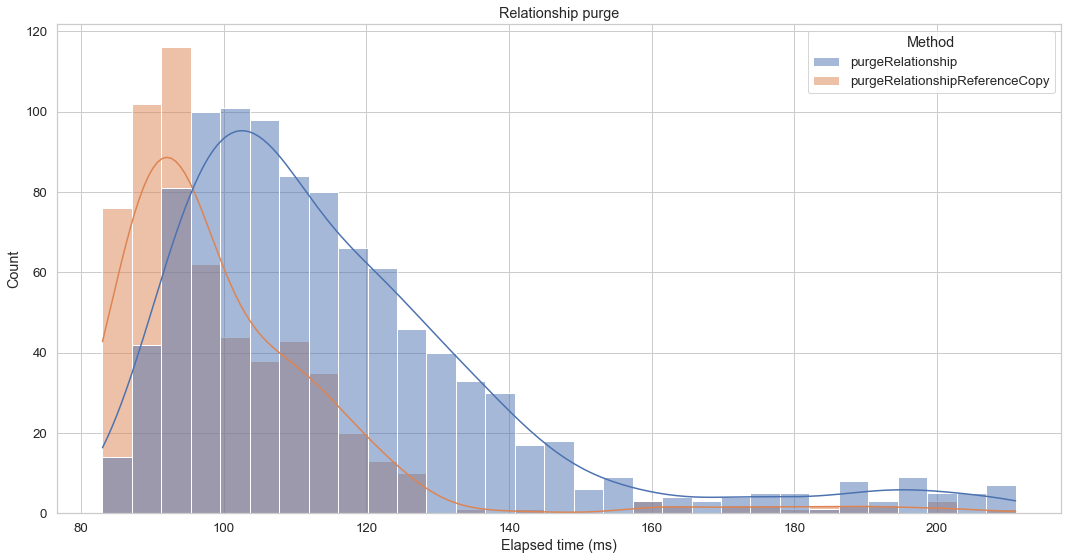

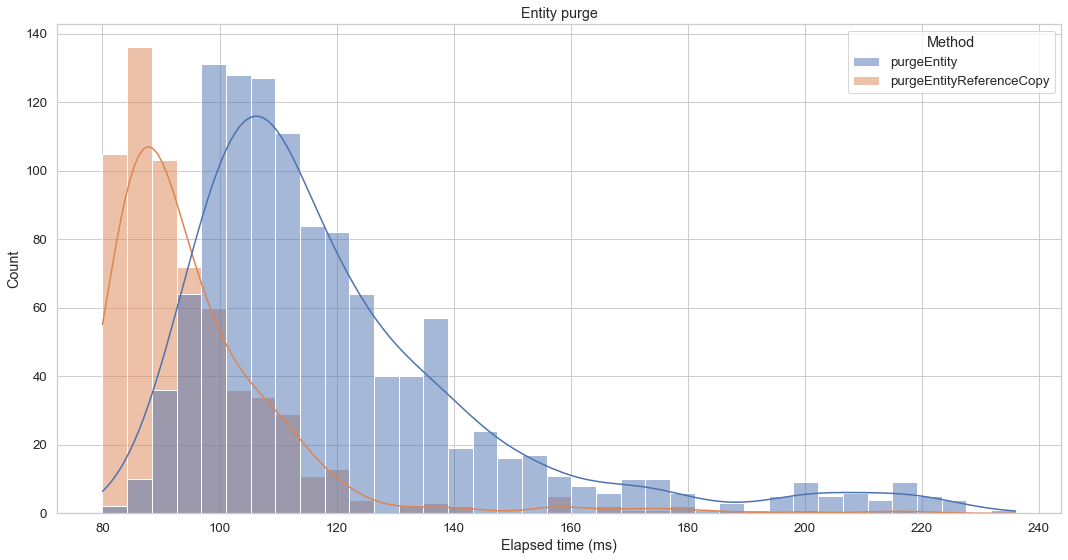

In [6]:
for profile in profile_order:
    plotProfile(df1, profile, remove_outliers=True)

Without the outliers, we can more clearly see the typical distribution of each method's response times: and that in most cases (99% of the methods' executions) the response times are all sub-second.

We can also see that there are however a few exceptions to this -- the various graph queries all have very long tails that suggest there are a number of examples of very long-running methods.

We can start by looking at the top-10 slowest response times for each of these individual methods:

In [7]:
slowest = ['getEntityNeighborhood', 'getLinkingEntities', 'getRelatedEntities', 'getRelationshipsForEntity']
for slow in slowest:
    slowestRunning(df1, num=10, methodName=slow)

repo            method_name  elapsed_time           profile_name  \
68486  pts-05-02  getEntityNeighborhood        7013.0  Graph history queries   
68172  pts-05-02  getEntityNeighborhood        6120.0  Graph history queries   
6540   pts-05-02  getEntityNeighborhood        5977.0          Graph queries   
10519  pts-05-02  getEntityNeighborhood        5769.0          Graph queries   
65375  pts-05-02  getEntityNeighborhood        5620.0  Graph history queries   
10449  pts-05-02  getEntityNeighborhood        5235.0          Graph queries   
4933   pts-05-02  getEntityNeighborhood        4969.0          Graph queries   
7681   pts-05-02  getEntityNeighborhood        4772.0          Graph queries   
7399   pts-05-02  getEntityNeighborhood        4674.0          Graph queries   
67708  pts-05-02  getEntityNeighborhood        4540.0  Graph history queries   

                                                         test_case_id  \
68486  repository-graph-history-query-performance-GovernanceProcedure   
68172    repository-graph-history-query-performance-GovernanceControl   
6540               repository-graph-query-performance-EmbeddedProcess   
10519                   repository-graph-query-performance-SchemaType   
65375    repository-graph-history-query-performance-BoundedSchemaType   
10449                repository-graph-query-performance-SchemaElement   
4933             repository-graph-query-performance-ComplexSchemaType   
7681           repository-graph-query-performance-GovernanceProcedure   
7399          repository-graph-query-performance-GovernanceDefinition   
67708    repository-graph-history-query-performance-ExternalReference   

                                                             assertion_id  
68486  repository-graph-history-query-performance-getEntityNeighborhood-3  
68172  repository-graph-history-query-performance-getEntityNeighborhood-3  
6540           repository-graph-query-performance-getEntityNeighborhood-3  
10519          repository-graph-query-performance-getEntityNeighborhood-3  
65375  repository-graph-history-query-performance-getEntityNeighborhood-3  
10449          repository-graph-query-performance-getEntityNeighborhood-3  
4933           repository-graph-query-performance-getEntityNeighborhood-3  
7681           repository-graph-query-performance-getEntityNeighborhood-3  
7399           repository-graph-query-performance-getEntityNeighborhood-3  
67708  repository-graph-history-query-performance-getEntityNeighborhood-3

repo         method_name  elapsed_time           profile_name  \
7696   pts-05-02  getLinkingEntities        6150.0          Graph queries   
68501  pts-05-02  getLinkingEntities        4202.0  Graph history queries   
7734   pts-05-02  getLinkingEntities        3993.0          Graph queries   
68503  pts-05-02  getLinkingEntities        3958.0  Graph history queries   
7698   pts-05-02  getLinkingEntities        3921.0          Graph queries   
11659  pts-05-02  getLinkingEntities        3757.0          Graph queries   
7767   pts-05-02  getLinkingEntities        3630.0          Graph queries   
72398  pts-05-02  getLinkingEntities        3429.0  Graph history queries   
68965  pts-05-02  getLinkingEntities        3330.0  Graph history queries   
68566  pts-05-02  getLinkingEntities        3285.0  Graph history queries   

                                                              test_case_id  \
7696                repository-graph-query-performance-GovernanceProcedure   
68501       repository-graph-history-query-performance-GovernanceProcedure   
7734                  repository-graph-query-performance-GovernanceProcess   
68503       repository-graph-history-query-performance-GovernanceProcedure   
7698                repository-graph-query-performance-GovernanceProcedure   
11659                 repository-graph-query-performance-VirtualConnection   
7767           repository-graph-query-performance-GovernanceResponsibility   
72398            repository-graph-history-query-performance-ValidValuesSet   
68965          repository-graph-history-query-performance-ITInfrastructure   
68566  repository-graph-history-query-performance-GovernanceResponsibility   

                                                        assertion_id  
7696           repository-graph-query-performance-getLinkingEntities  
68501  repository-graph-history-query-performance-getLinkingEntities  
7734           repository-graph-query-performance-getLinkingEntities  
68503  repository-graph-history-query-performance-getLinkingEntities  
7698           repository-graph-query-performance-getLinkingEntities  
11659          repository-graph-query-performance-getLinkingEntities  
7767           repository-graph-query-performance-getLinkingEntities  
72398  repository-graph-history-query-performance-getLinkingEntities  
68965  repository-graph-history-query-performance-getLinkingEntities  
68566  repository-graph-history-query-performance-getLinkingEntities

repo         method_name  elapsed_time           profile_name  \
7690   pts-05-02  getRelatedEntities        9737.0          Graph queries   
7691   pts-05-02  getRelatedEntities        8333.0          Graph queries   
68496  pts-05-02  getRelatedEntities        7400.0  Graph history queries   
68959  pts-05-02  getRelatedEntities        7219.0  Graph history queries   
68495  pts-05-02  getRelatedEntities        7142.0  Graph history queries   
7723   pts-05-02  getRelatedEntities        6406.0          Graph queries   
68528  pts-05-02  getRelatedEntities        6377.0  Graph history queries   
10965  pts-05-02  getRelatedEntities        6320.0          Graph queries   
68526  pts-05-02  getRelatedEntities        6292.0  Graph history queries   
7721   pts-05-02  getRelatedEntities        6216.0          Graph queries   

                                                         test_case_id  \
7690           repository-graph-query-performance-GovernanceProcedure   
7691           repository-graph-query-performance-GovernanceProcedure   
68496  repository-graph-history-query-performance-GovernanceProcedure   
68959     repository-graph-history-query-performance-ITInfrastructure   
68495  repository-graph-history-query-performance-GovernanceProcedure   
7723             repository-graph-query-performance-GovernanceProcess   
68528    repository-graph-history-query-performance-GovernanceProcess   
10965                 repository-graph-query-performance-SolutionPort   
68526    repository-graph-history-query-performance-GovernanceProcess   
7721             repository-graph-query-performance-GovernanceProcess   

                                                        assertion_id  
7690           repository-graph-query-performance-getRelatedEntities  
7691           repository-graph-query-performance-getRelatedEntities  
68496  repository-graph-history-query-performance-getRelatedEntities  
68959  repository-graph-history-query-performance-getRelatedEntities  
68495  repository-graph-history-query-performance-getRelatedEntities  
7723           repository-graph-query-performance-getRelatedEntities  
68528  repository-graph-history-query-performance-getRelatedEntities  
10965          repository-graph-query-performance-getRelatedEntities  
68526  repository-graph-history-query-performance-getRelatedEntities  
7721           repository-graph-query-performance-getRelatedEntities

repo                method_name  elapsed_time  \
4304   pts-05-02  getRelationshipsForEntity        1281.0   
66481  pts-05-02  getRelationshipsForEntity        1189.0   
7700   pts-05-02  getRelationshipsForEntity        1105.0   
4199   pts-05-02  getRelationshipsForEntity         410.0   
6019   pts-05-02  getRelationshipsForEntity         354.0   
67663  pts-05-02  getRelationshipsForEntity         345.0   
6021   pts-05-02  getRelationshipsForEntity         321.0   
10944  pts-05-02  getRelationshipsForEntity         316.0   
4851   pts-05-02  getRelationshipsForEntity         314.0   
6855   pts-05-02  getRelationshipsForEntity         310.0   

                profile_name  \
4304           Graph queries   
66481  Graph history queries   
7700           Graph queries   
4199           Graph queries   
6019           Graph queries   
67663  Graph history queries   
6021           Graph queries   
10944          Graph queries   
4851           Graph queries   
6855           Graph queries   

                                                test_case_id  \
4304           repository-graph-query-performance-Annotation   
66481   repository-graph-history-query-performance-DataStore   
7700    repository-graph-query-performance-GovernanceProcess   
4199         repository-graph-query-performance-APIOperation   
6019   repository-graph-query-performance-DesignModelElement   
67663  repository-graph-history-query-performance-ExternalId   
6021   repository-graph-query-performance-DesignModelElement   
10944        repository-graph-query-performance-SolutionPort   
4851            repository-graph-query-performance-Community   
6855           repository-graph-query-performance-ExternalId   

                                                               assertion_id  
4304           repository-graph-query-performance-getRelationshipsForEntity  
66481  repository-graph-history-query-performance-getRelationshipsForEntity  
7700           repository-graph-query-performance-getRelationshipsForEntity  
4199           repository-graph-query-performance-getRelationshipsForEntity  
6019           repository-graph-query-performance-getRelationshipsForEntity  
67663  repository-graph-history-query-performance-getRelationshipsForEntity  
6021           repository-graph-query-performance-getRelationshipsForEntity  
10944          repository-graph-query-performance-getRelationshipsForEntity  
4851           repository-graph-query-performance-getRelationshipsForEntity  
6855           repository-graph-query-performance-getRelationshipsForEntity

We can see that each of these top-10 slowest results for these various methods are similar, and the result of the method running against a different set of parameters (for example, against different types of instances). This would suggest that these response times were not simply a one-off or pseudo-random occurrence that could have been caused by something like a garbage collection pause, but that there is more likely to be some fundamental underlying reason for this particular performance. To find out more, we need to delve back into the repository connector itself with deeper profiling of these particular combinations of parameters for each method to see if there is some further optimization that can be done.

## Comparing results

Up to this point, we have done some analysis of the performance of a single set of volume parameters. However, we may also be interested in comparing and contrasting these results with additional volume parameters to investigate the scalability of the connector as the volume of metadata within the repository grows.

In [8]:
results1 = results[1]

validateProfileResultsLocation(results1)
files = getAllProfiles(results1)

for profile_file in files:
    df1 = parseProfileDetailsIntoDF(df1, profile_file, results1)

Validating profile-details location: pts-10-05/profile-details
 ... directory exists.
Parsing evidence for: Relationship undo (pts-10-05)
Parsing evidence for: Relationship history search (pts-10-05)
Parsing evidence for: Classification update (pts-10-05)
Parsing evidence for: Entity update (pts-10-05)
Parsing evidence for: Graph queries (pts-10-05)
Parsing evidence for: Relationship purge (pts-10-05)
Parsing evidence for: Entity history retrieval (pts-10-05)
Parsing evidence for: Entity re-identify (pts-10-05)
Parsing evidence for: Relationship update (pts-10-05)
Parsing evidence for: Entity creation (pts-10-05)
Parsing evidence for: Relationship creation (pts-10-05)
Parsing evidence for: Entity history search (pts-10-05)
Parsing evidence for: Entity classification (pts-10-05)
Parsing evidence for: Entity retrieval (pts-10-05)
Parsing evidence for: Relationship delete (pts-10-05)
Parsing evidence for: Relationship history retrieval (pts-10-05)
Parsing evidence for: Relationship search

### instancesPerType=10, maxSearchResults=5 details

In [9]:
results1_env = getEnvironmentProfile(results1)
env1 = pd.DataFrame({'repo': [], 'property_name': [], 'property_value': []})
env1 = parseEnvironmentDetailsIntoDF(env1, results1_env, results1)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(env1)

Parsing properties for: Environment (pts-10-05)


repo                       property_name  \
0   pts-10-05                    instancesPerType   
1   pts-10-05                    maxSearchResults   
2   pts-10-05                waitBetweenScenarios   
3   pts-10-05                totalEntitiesCreated   
4   pts-10-05                  totalEntitiesFound   
5   pts-10-05           totalRelationshipsCreated   
6   pts-10-05             totalRelationshipsFound   
7   pts-10-05                     operatingSystem   
8   pts-10-05         operatingSystemArchitecture   
9   pts-10-05  operatingSystemAvailableProcessors   
10  pts-10-05          operatingSystemLoadAverage   
11  pts-10-05                           heapUsage   
12  pts-10-05                        nonHeapUsage   
13  pts-10-05                             jvmSpec   
14  pts-10-05                   jvmImplementation   

                                              property_value  
0                                                         10  
1                                                          5  
2                                                          0  
3                                                       4760  
4                                                       4760  
5                                                       4060  
6                                                       4060  
7                        Linux (3.10.0-1160.24.1.el7.x86_64)  
8                                                      amd64  
9                                                          4  
10                                                      1.64  
11                                     2503214160/7635730432  
12                                      250315312/2390753280  
13  Java Virtual Machine Specification Oracle Corporation 11  
14      OpenJDK 64-Bit Server VM Red Hat, Inc. 11.0.10+9-LTS

### ipt=5, msr=2 compared to ipt=10, msr=5

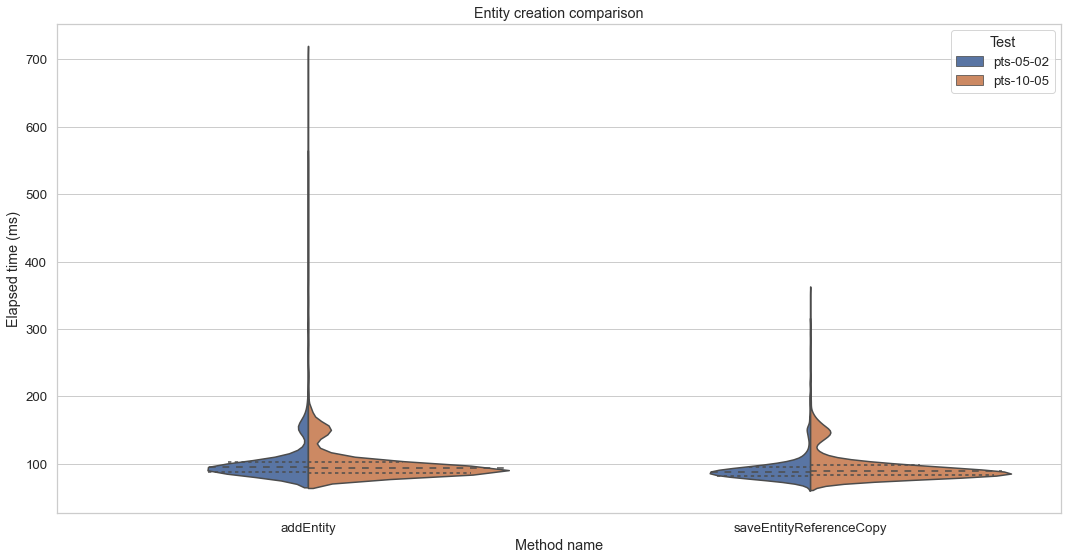

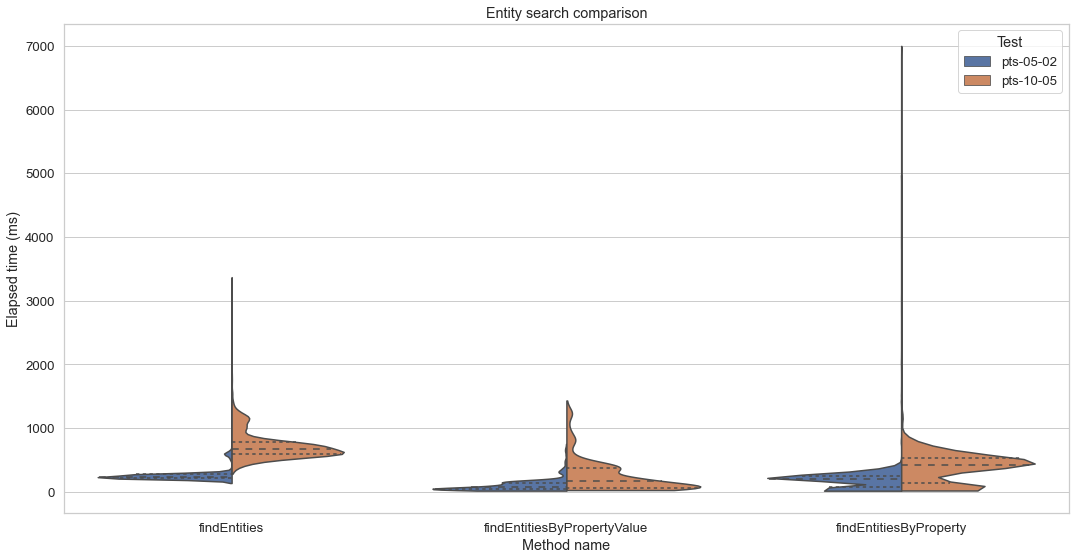

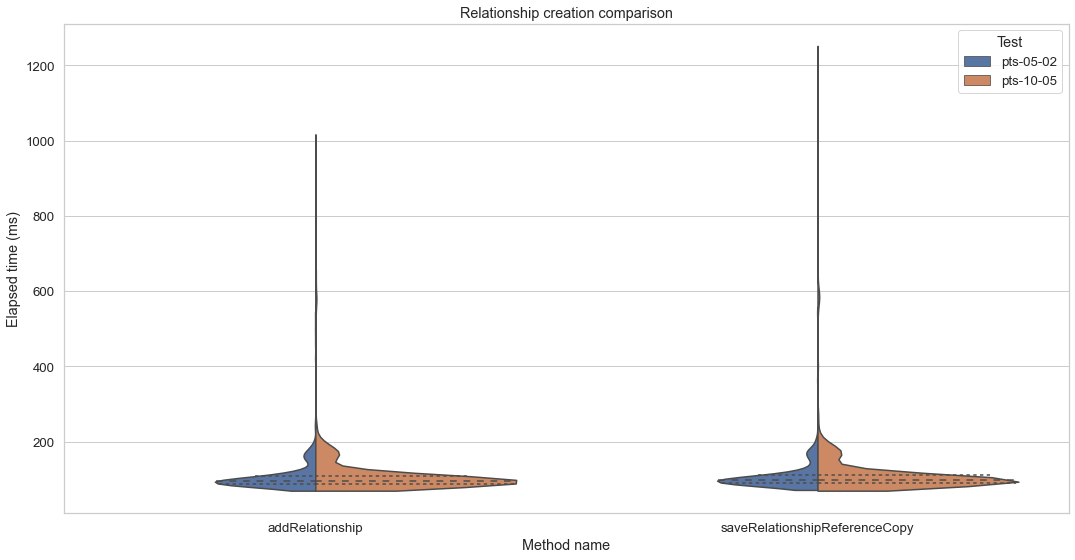

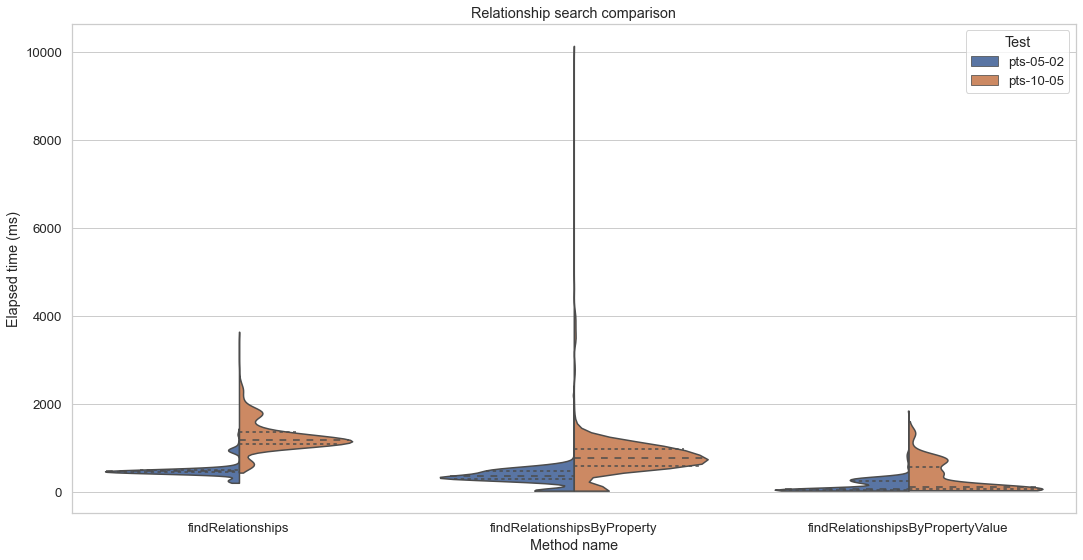

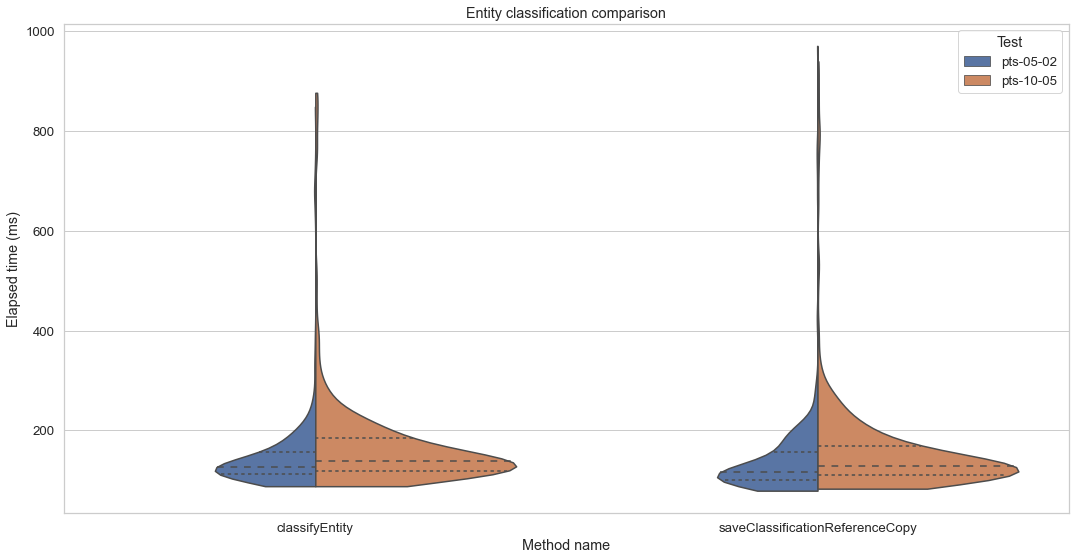

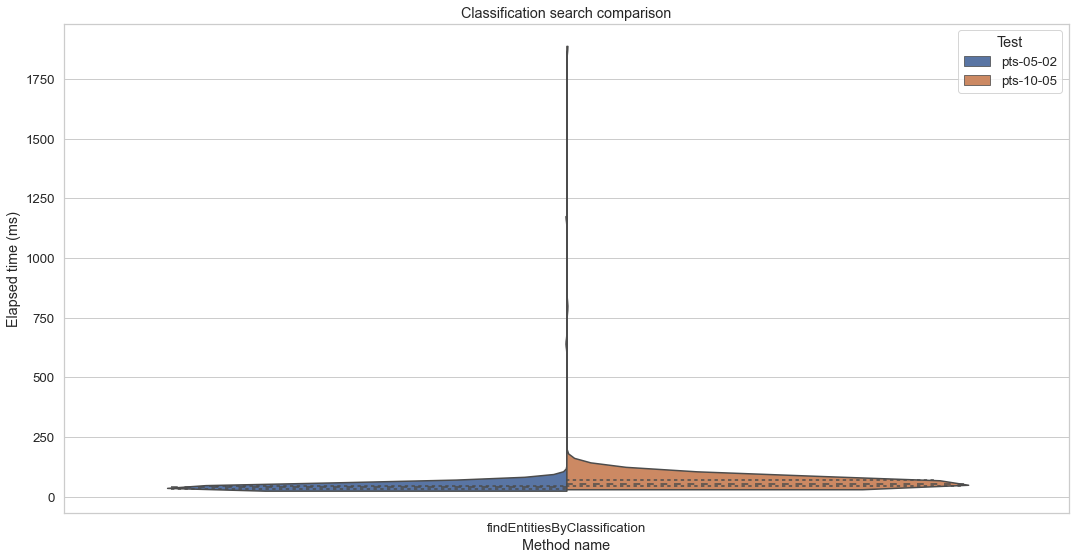

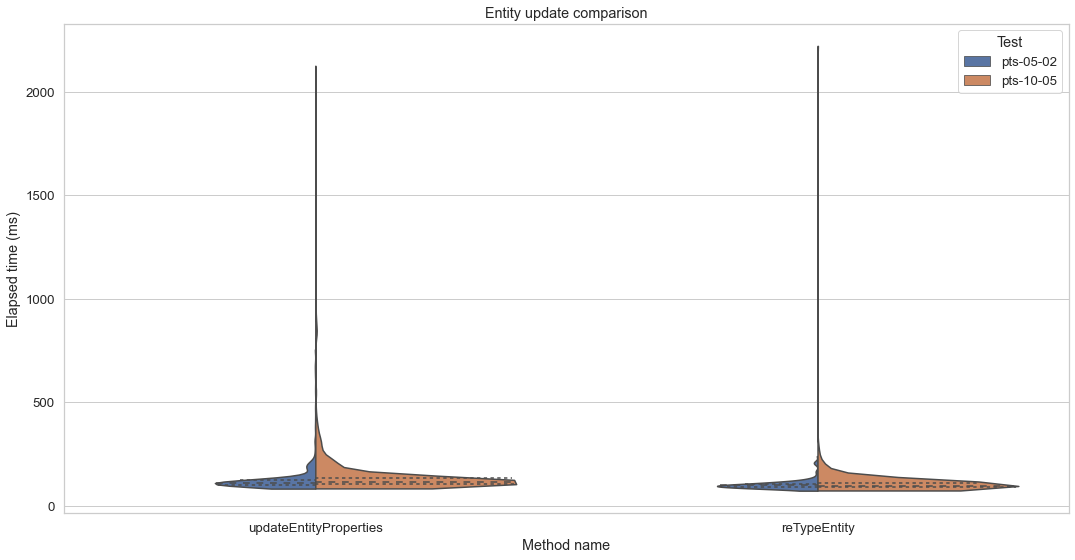

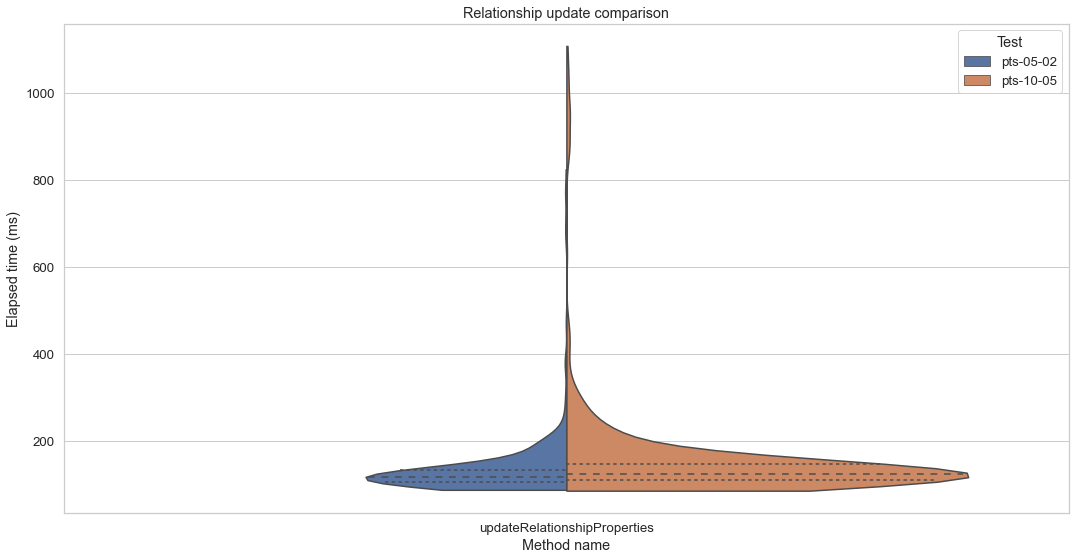

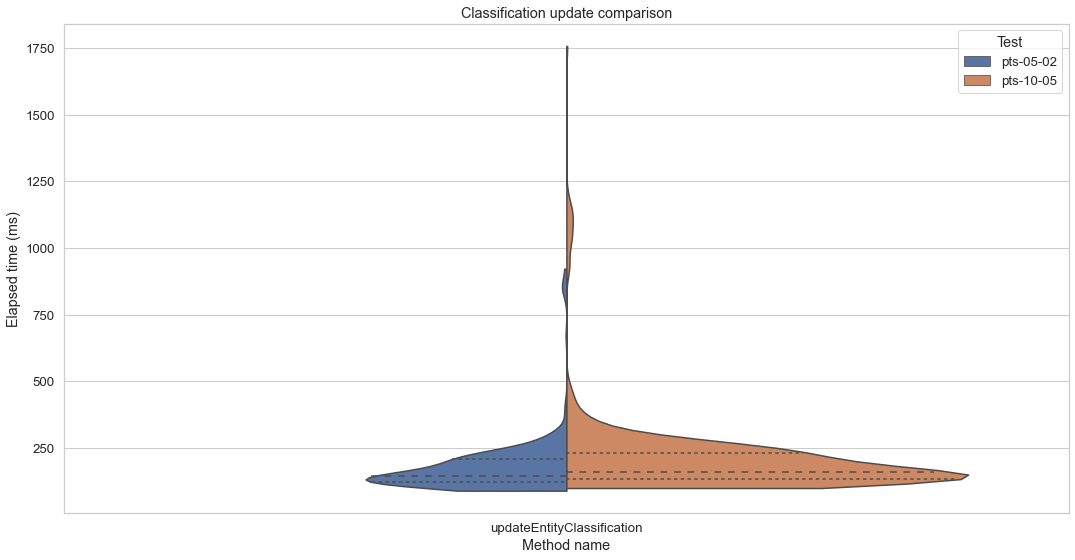

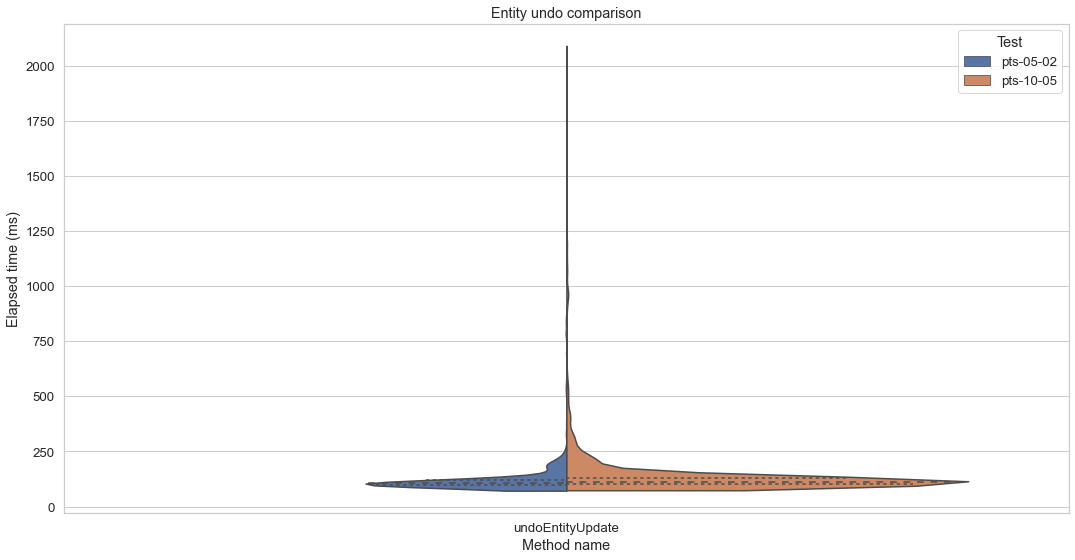

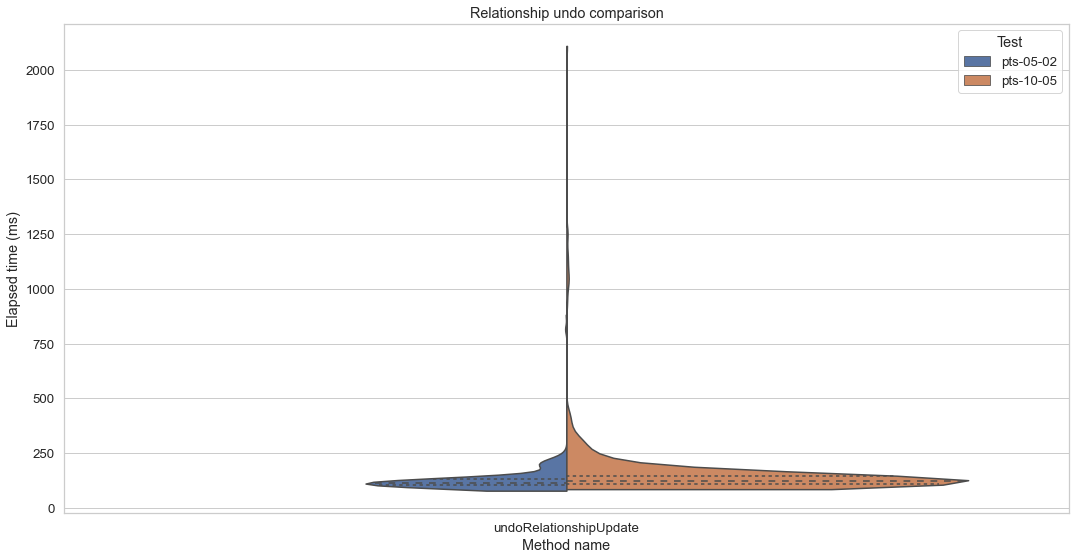

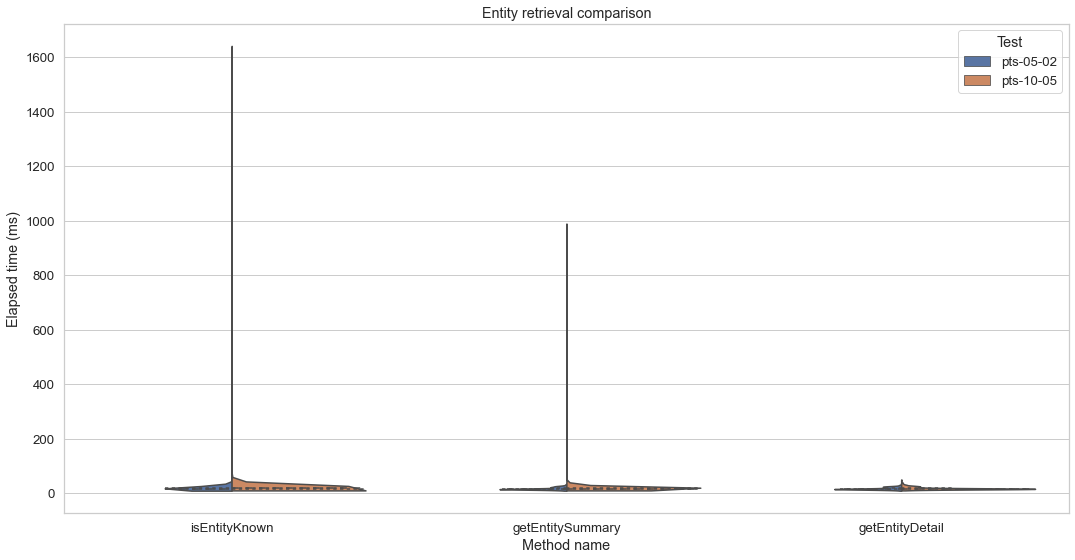

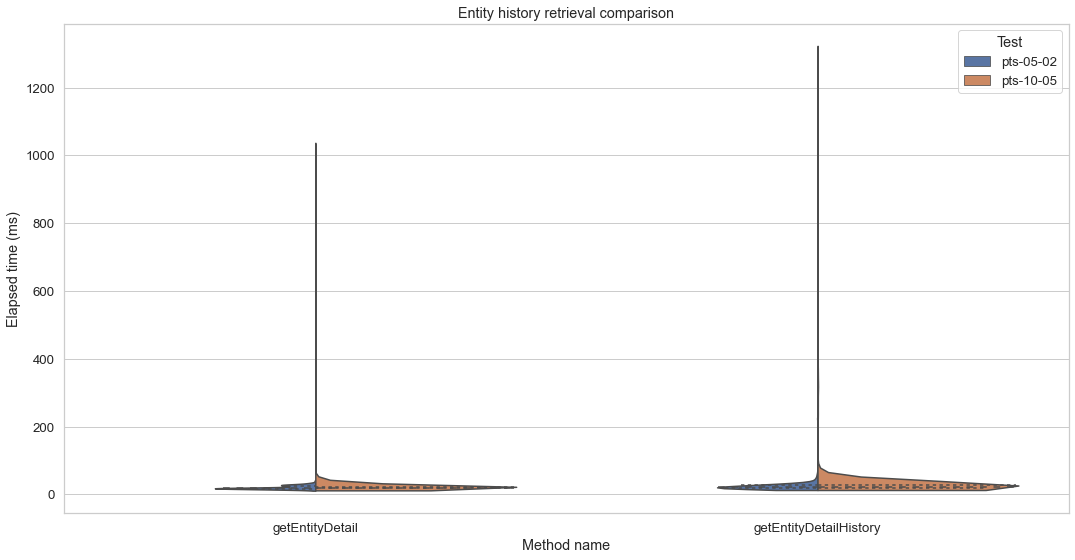

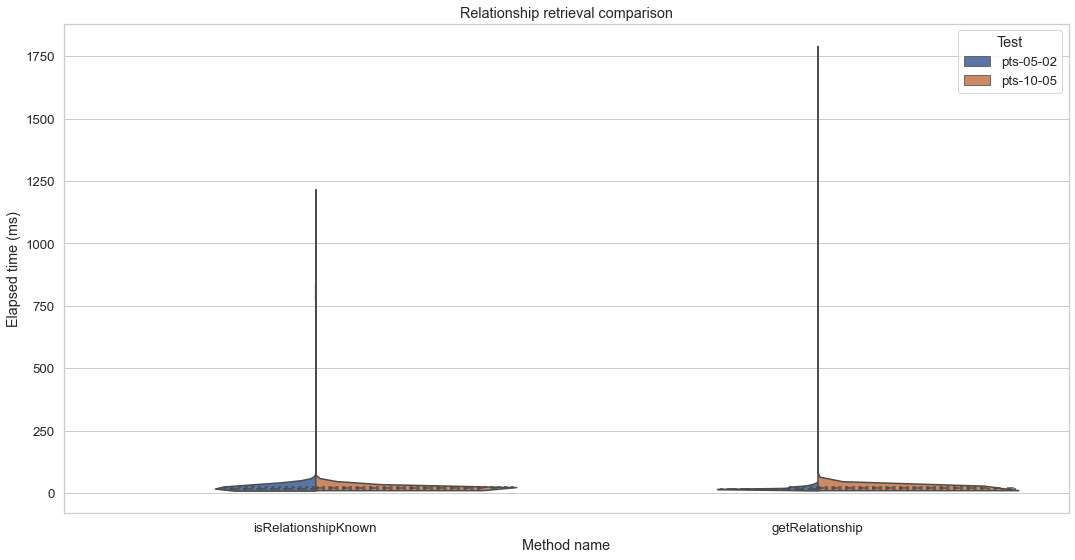

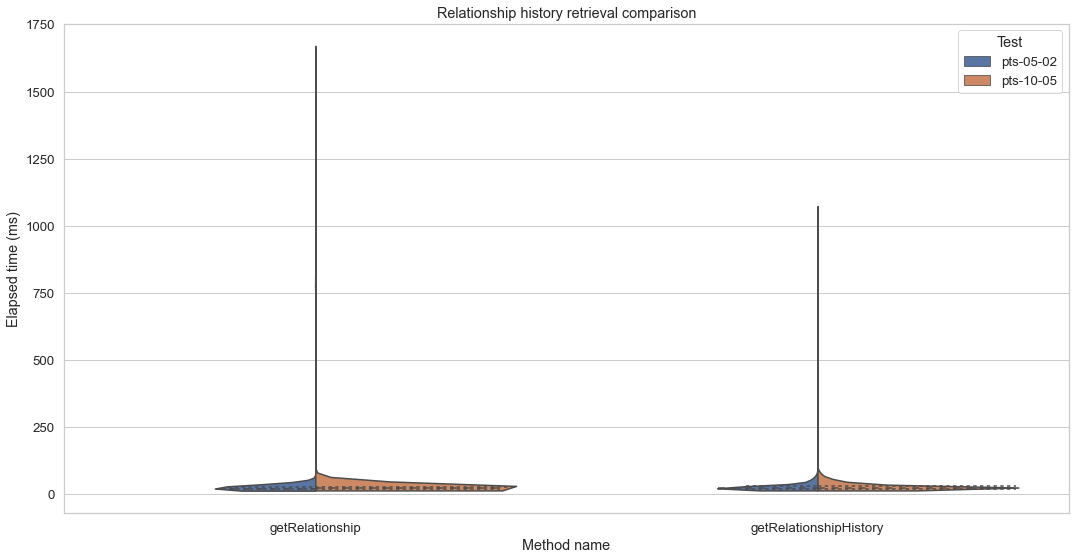

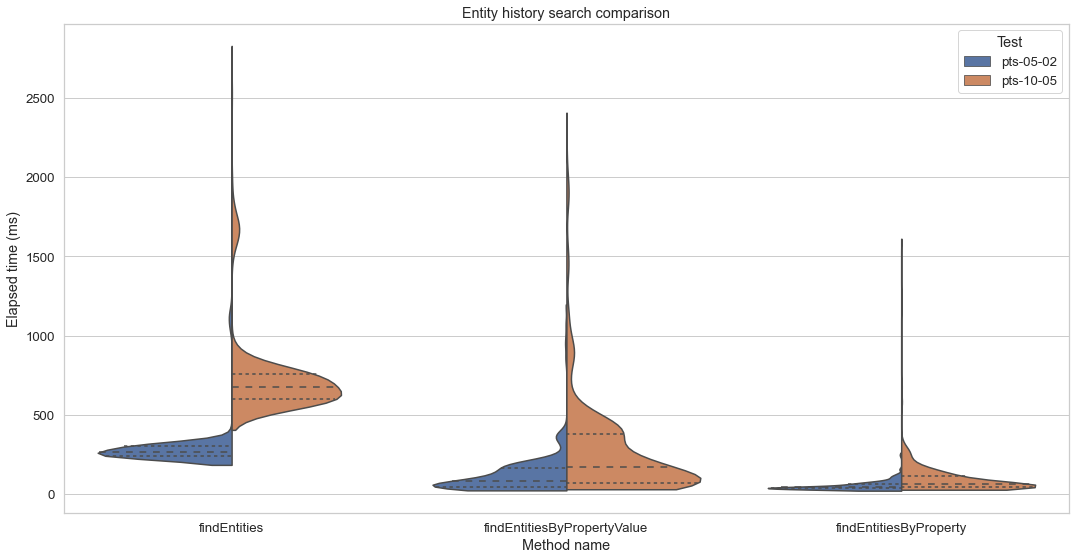

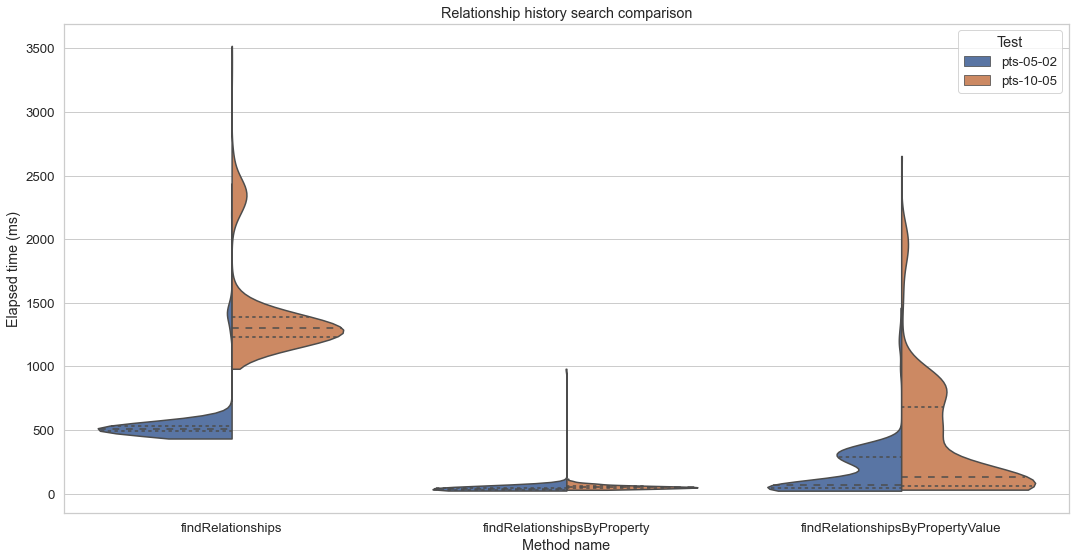

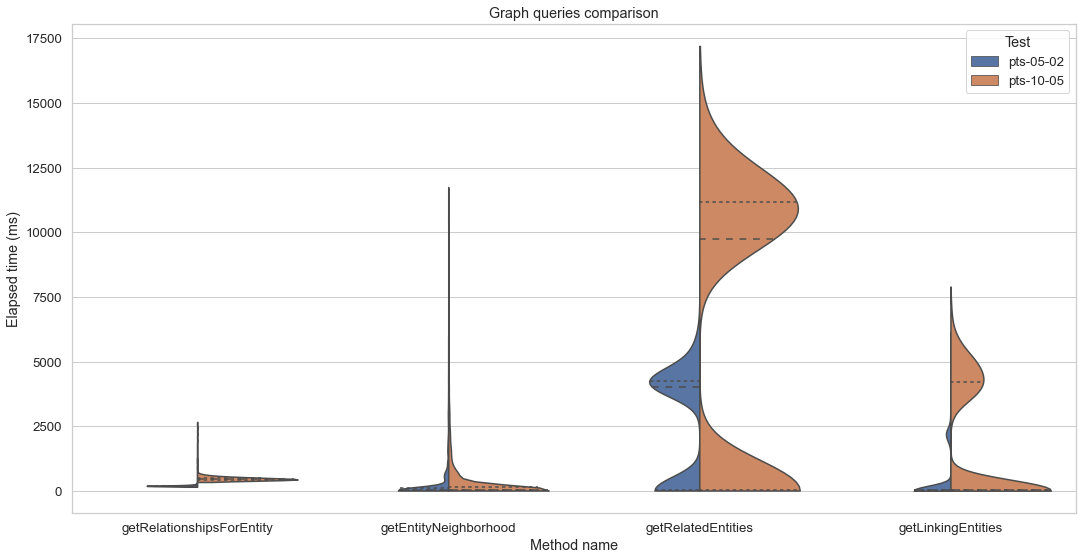

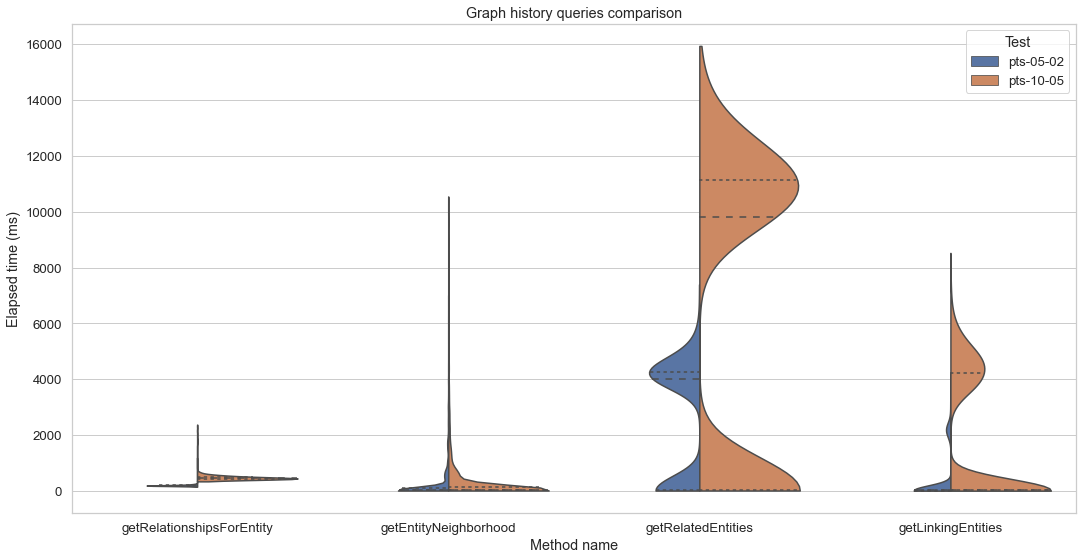

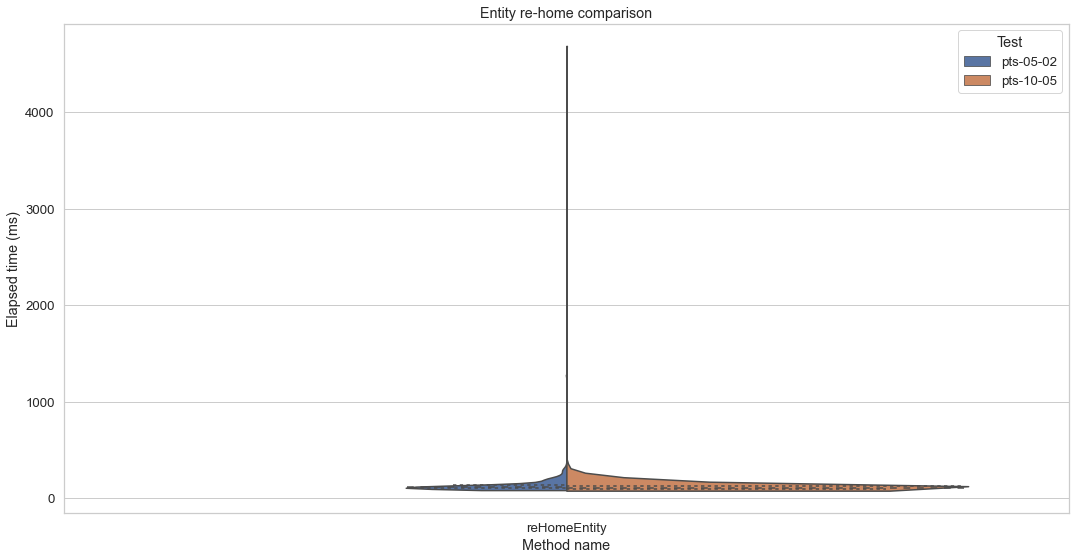

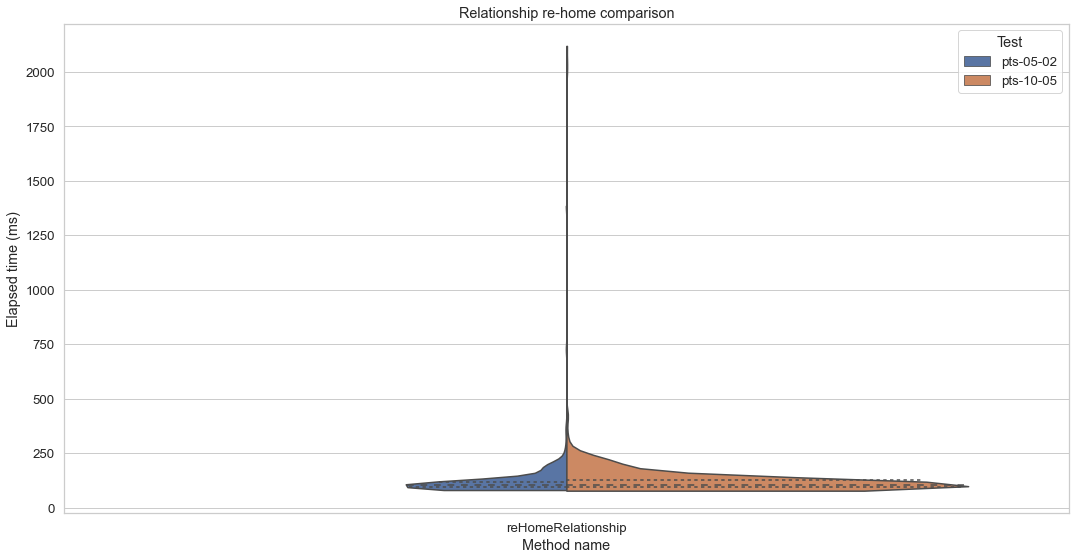

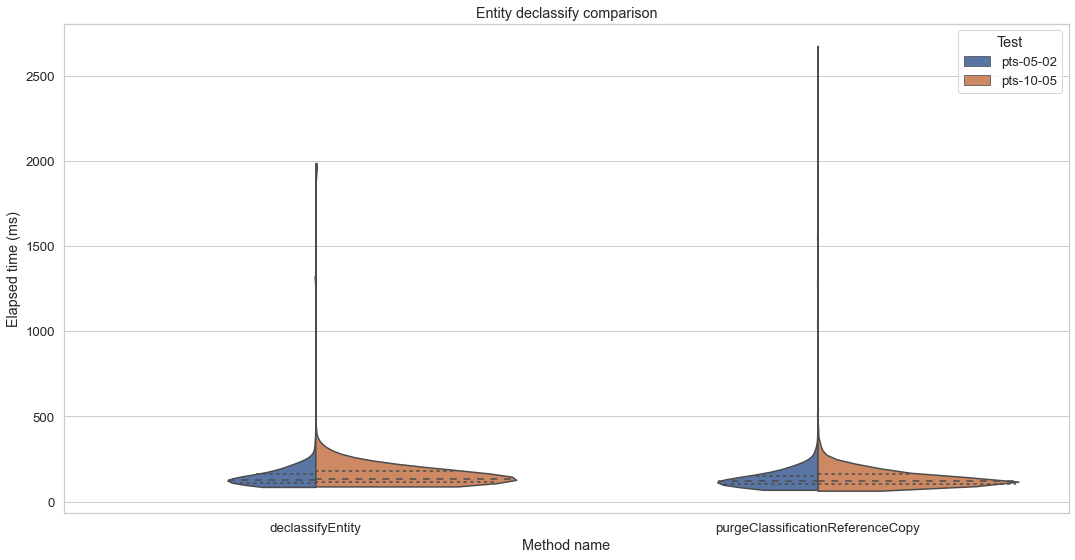

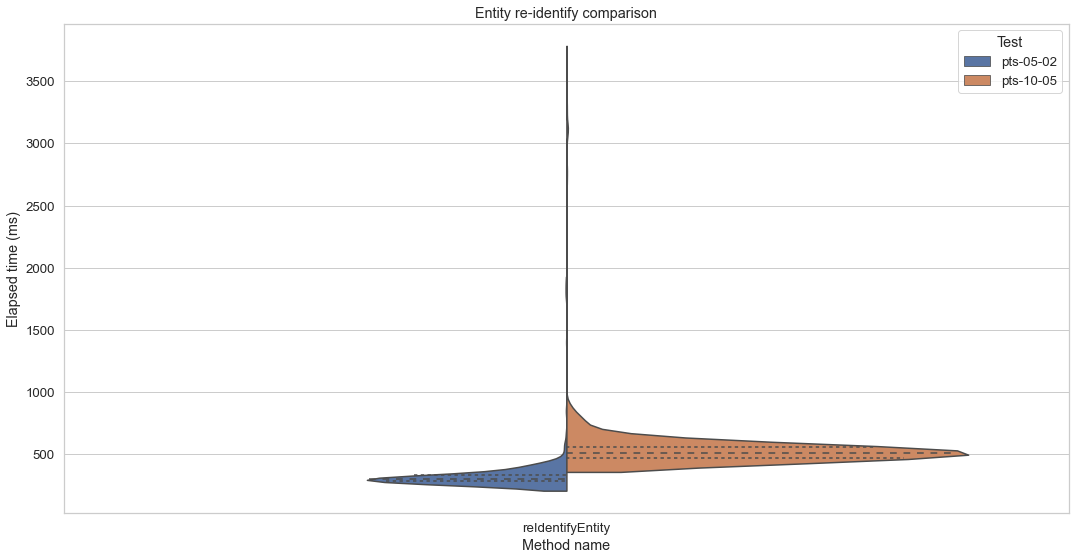

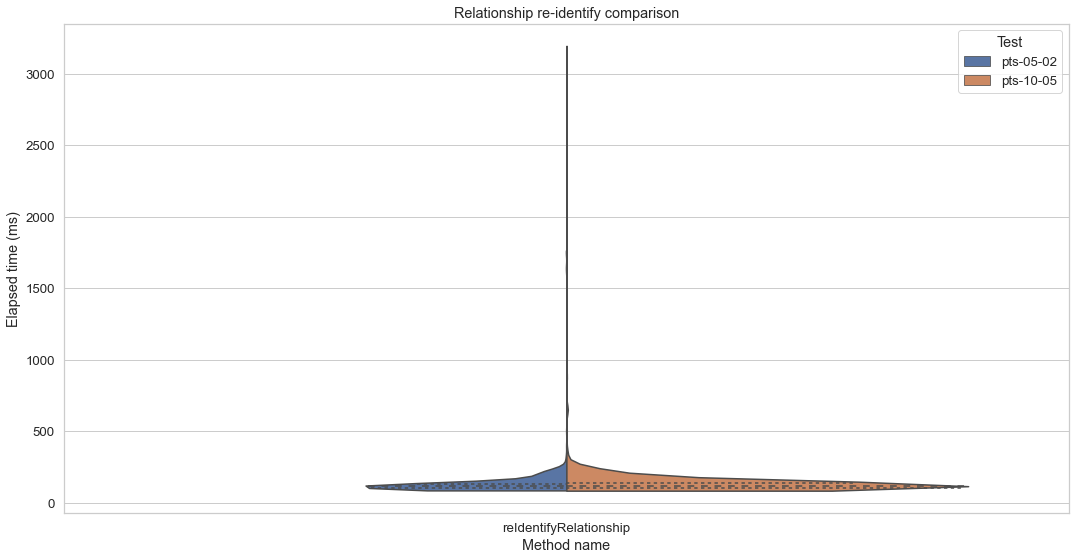

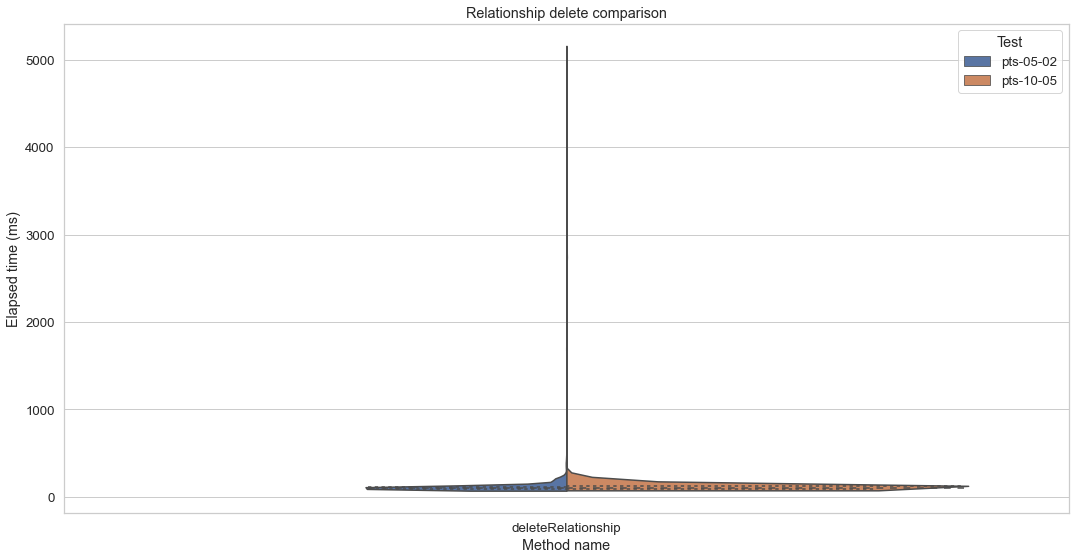

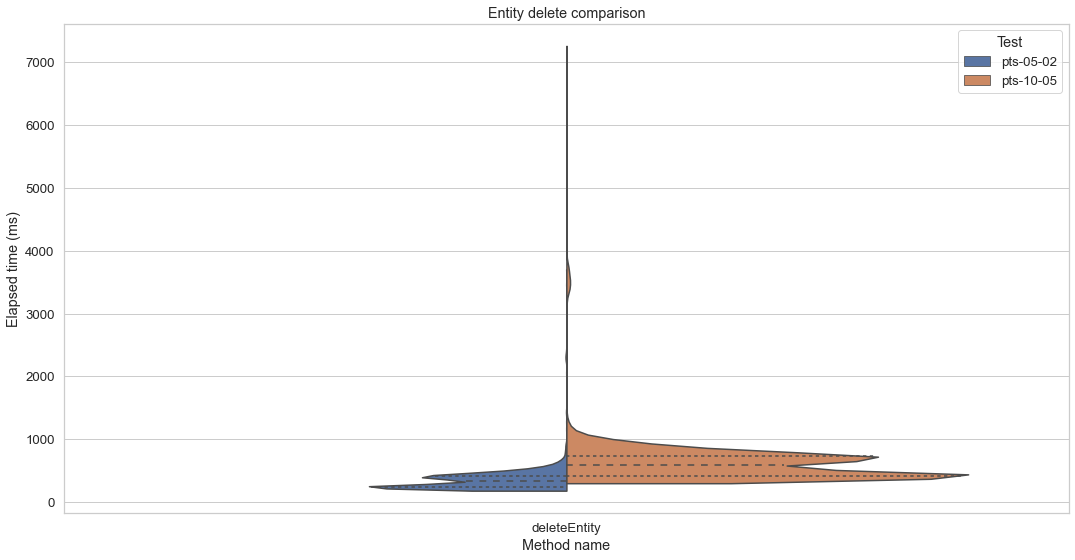

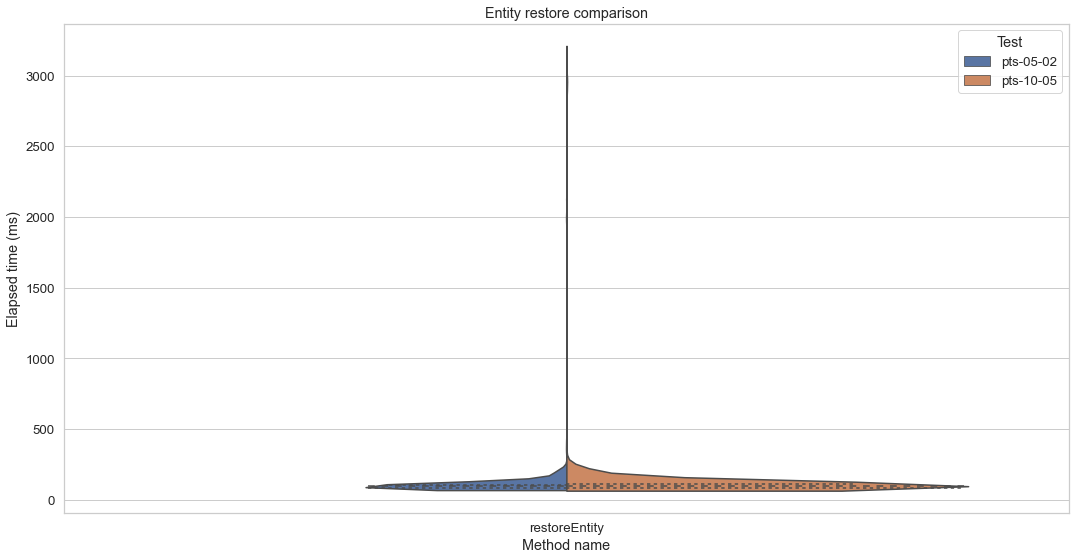

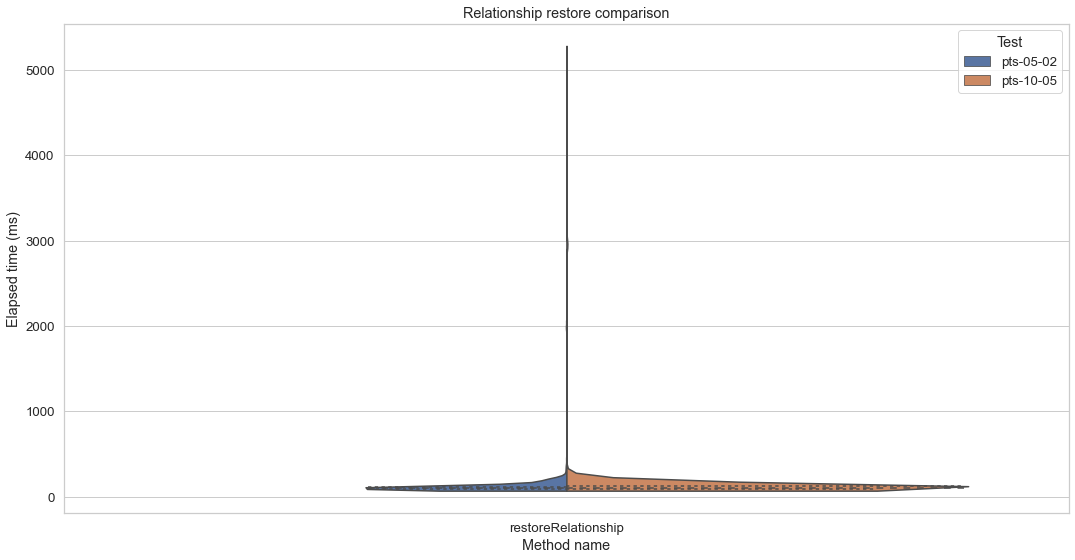

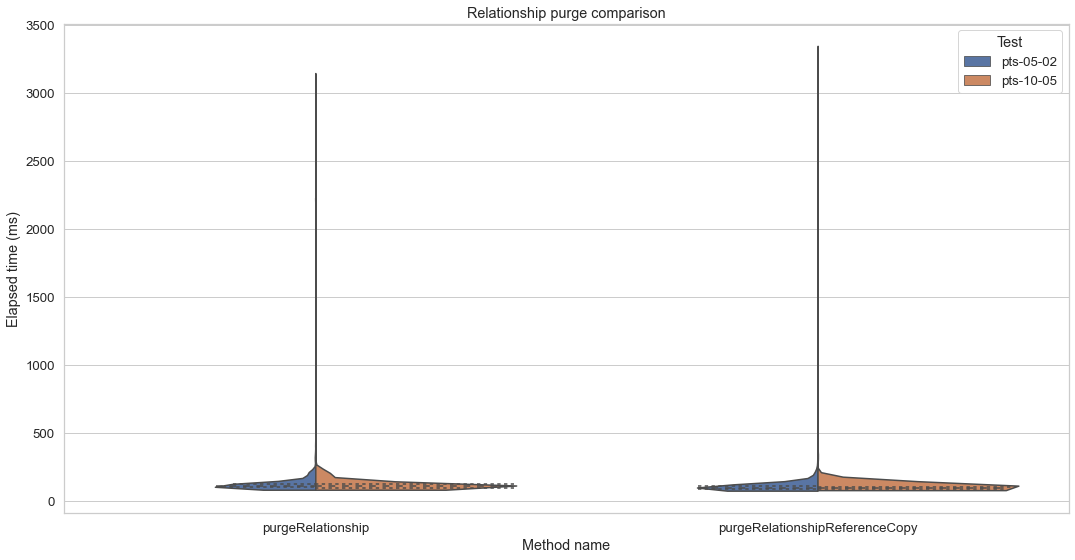

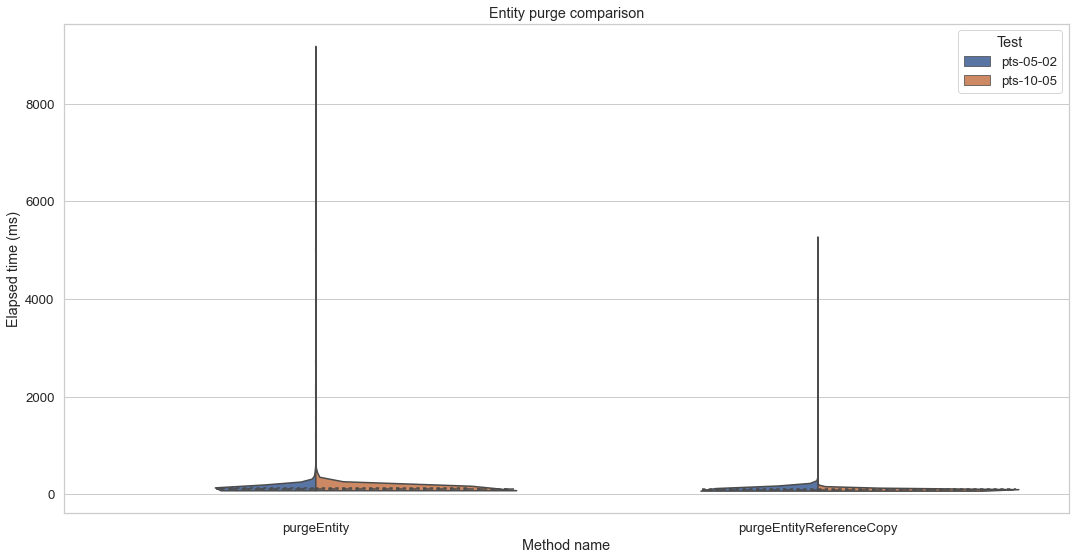

In [10]:
for profile in profile_order:
    compareProfiles(df1, profile, results0, results1)

#### Analysis

For the most part, the performance for each method is comparable -- even though we have doubled the number of instances involved (from 4410 to 8820) and the number of results returned by each page of a search (from 2 to 5).

The notable exceptions are the various search methods and the graph queries, in particular `getRelatedEntities` and `getLinkingEntities` which we can see have a significant additional peak. This may be understandable, given the additional number of instances is likely to equate to a significant increase in the number of relationships and linked entities that these methods will retrieve in the higher volume environment (since these methods do not page results, but retrieve all relationships and entities involved).

For those search queries that only retrieve pages of results, however, we may want to further investigate why their execution time has approximately doubled as a result of having twice as many instances of metadata in the environment. (For example, is it the query itself that is taking longer to run? Or the fact that we are instantiating twice as many results per page? Or some combination of the two?)

### Other repositories

We may also want to do some comparative analysis between repositories. The following looks at results from the JanusGraph repository at the same volume parameters to compare and contrast the relative performance of the two repositories.

In [11]:
results2 = results[2]

validateProfileResultsLocation(results2)
files = getAllProfiles(results2)

for profile_file in files:
    df1 = parseProfileDetailsIntoDF(df1, profile_file, results2)

Validating profile-details location: janus-05-02/profile-details
 ... directory exists.
Parsing evidence for: Relationship undo (janus-05-02)
Parsing evidence for: Relationship history search (janus-05-02)
Parsing evidence for: Classification update (janus-05-02)
Parsing evidence for: Entity update (janus-05-02)
Parsing evidence for: Relationship purge (janus-05-02)
Parsing evidence for: Entity re-identify (janus-05-02)
Parsing evidence for: Relationship update (janus-05-02)
Parsing evidence for: Entity creation (janus-05-02)
Parsing evidence for: Relationship creation (janus-05-02)
Parsing evidence for: Entity history search (janus-05-02)
Parsing evidence for: Entity classification (janus-05-02)
Parsing evidence for: Entity retrieval (janus-05-02)
Parsing evidence for: Relationship delete (janus-05-02)
Parsing evidence for: Relationship search (janus-05-02)
Parsing evidence for: Entity retype (janus-05-02)
Parsing evidence for: Relationship re-identify (janus-05-02)
Parsing evidence f

In [12]:
results2_env = getEnvironmentProfile(results2)
env2 = pd.DataFrame({'repo': [], 'property_name': [], 'property_value': []})
env2 = parseEnvironmentDetailsIntoDF(env2, results2_env, results1)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(env2)

Parsing properties for: Environment (pts-10-05)


repo                       property_name  \
0   pts-10-05                    instancesPerType   
1   pts-10-05                    maxSearchResults   
2   pts-10-05                waitBetweenScenarios   
3   pts-10-05                      profilesToSkip   
4   pts-10-05                totalEntitiesCreated   
5   pts-10-05                  totalEntitiesFound   
6   pts-10-05           totalRelationshipsCreated   
7   pts-10-05             totalRelationshipsFound   
8   pts-10-05                     operatingSystem   
9   pts-10-05         operatingSystemArchitecture   
10  pts-10-05  operatingSystemAvailableProcessors   
11  pts-10-05          operatingSystemLoadAverage   
12  pts-10-05                           heapUsage   
13  pts-10-05                        nonHeapUsage   
14  pts-10-05                             jvmSpec   
15  pts-10-05                   jvmImplementation   

                                              property_value  
0                                                          5  
1                                                          2  
2                                                          0  
3                     [Graph queries, Graph history queries]  
4                                                       2380  
5                                                       2380  
6                                                       2040  
7                                                       2040  
8                        Linux (3.10.0-1160.24.1.el7.x86_64)  
9                                                      amd64  
10                                                         4  
11                                                      1.56  
12                                      327178552/7635730432  
13                                      223084040/2390753280  
14  Java Virtual Machine Specification Oracle Corporation 11  
15      OpenJDK 64-Bit Server VM Red Hat, Inc. 11.0.10+9-LTS

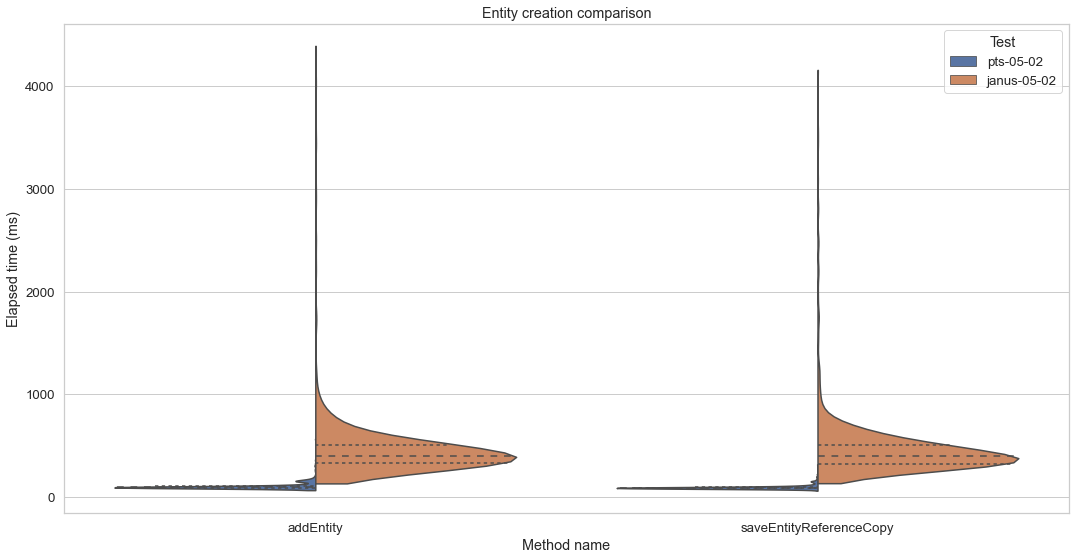

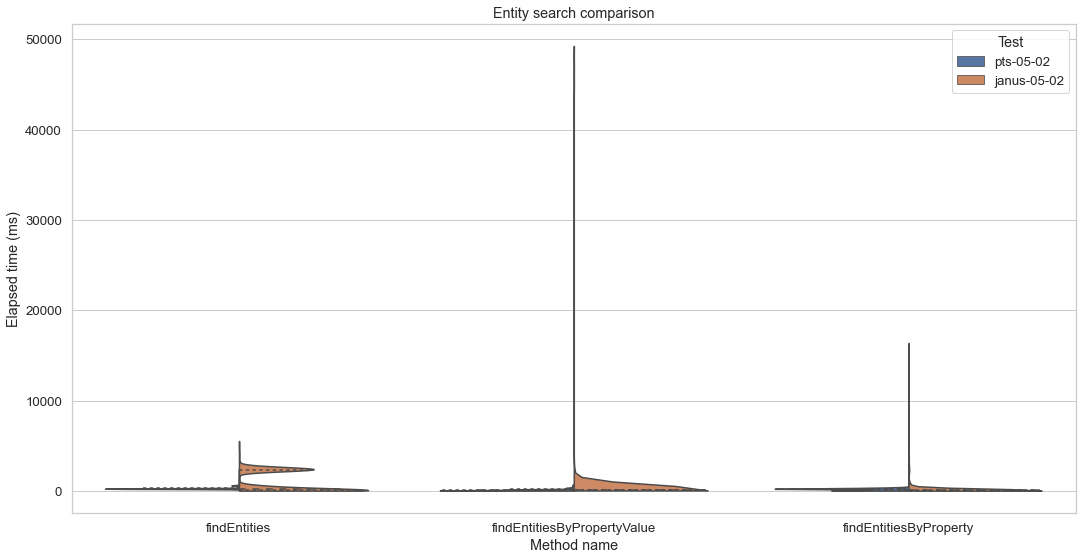

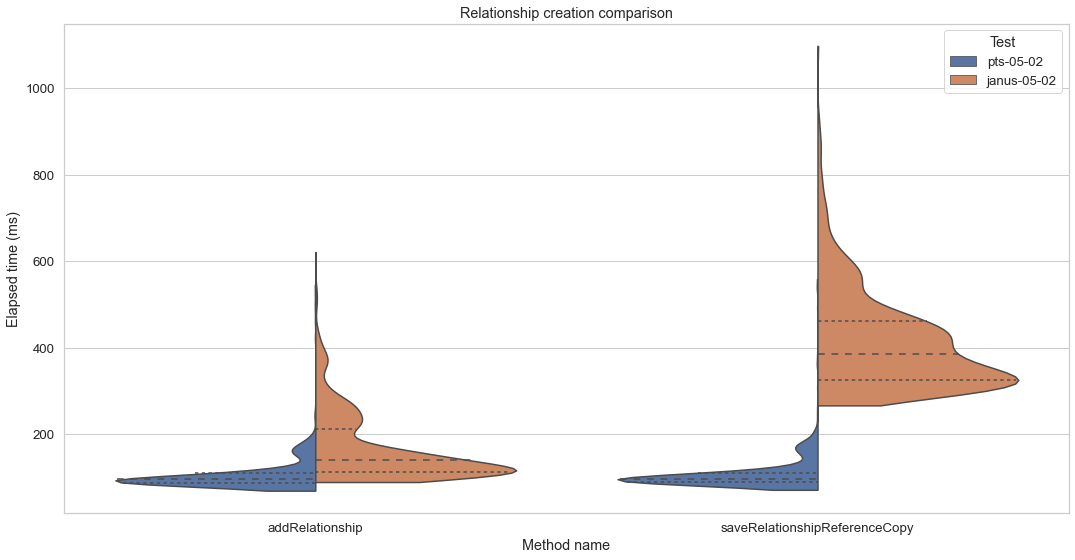

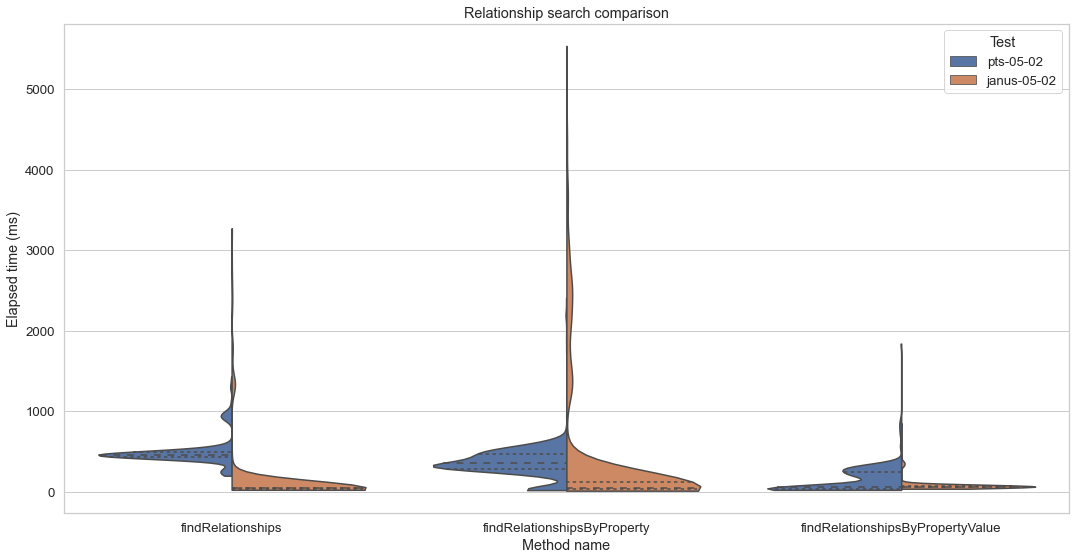

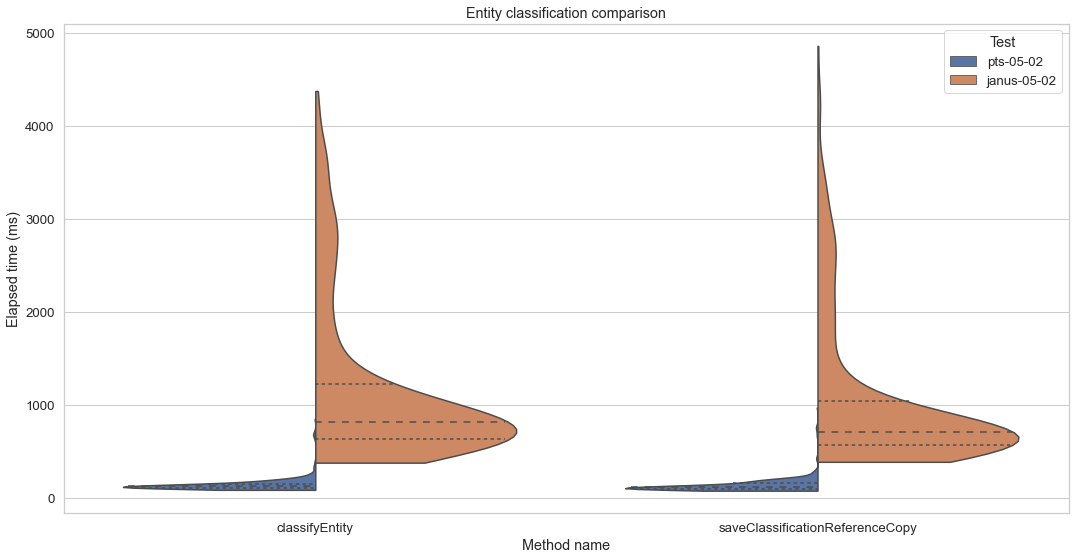

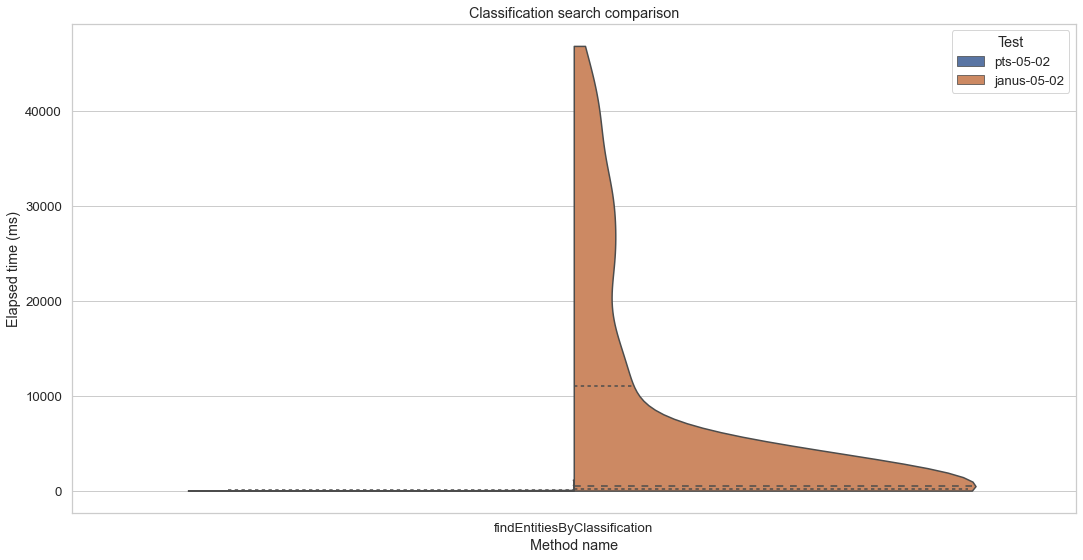

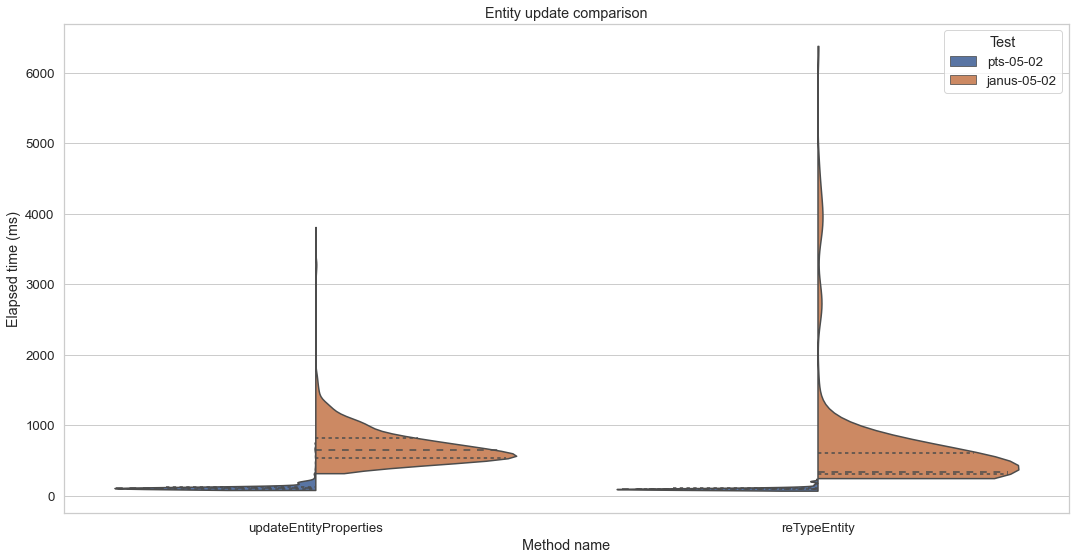

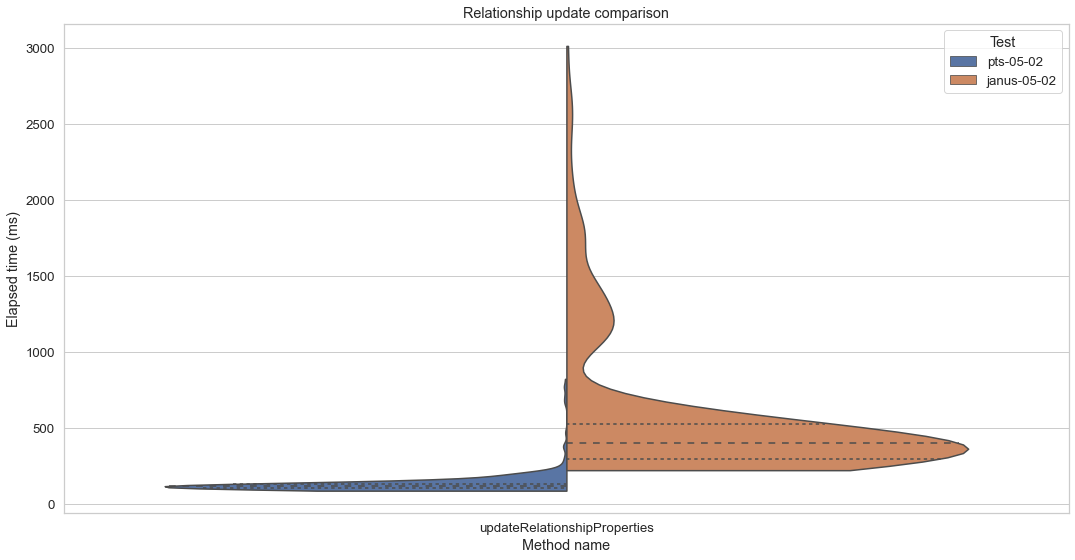

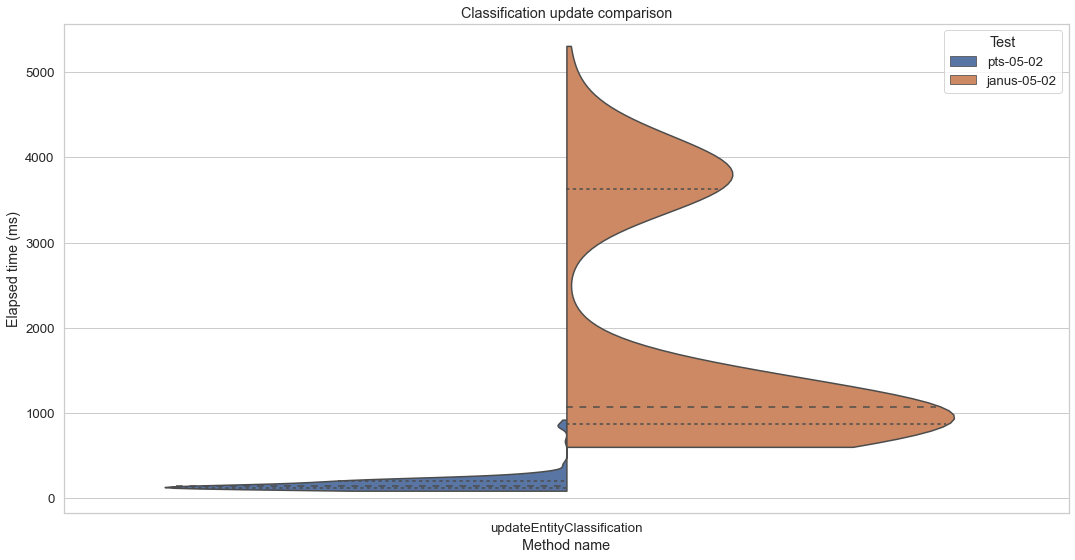

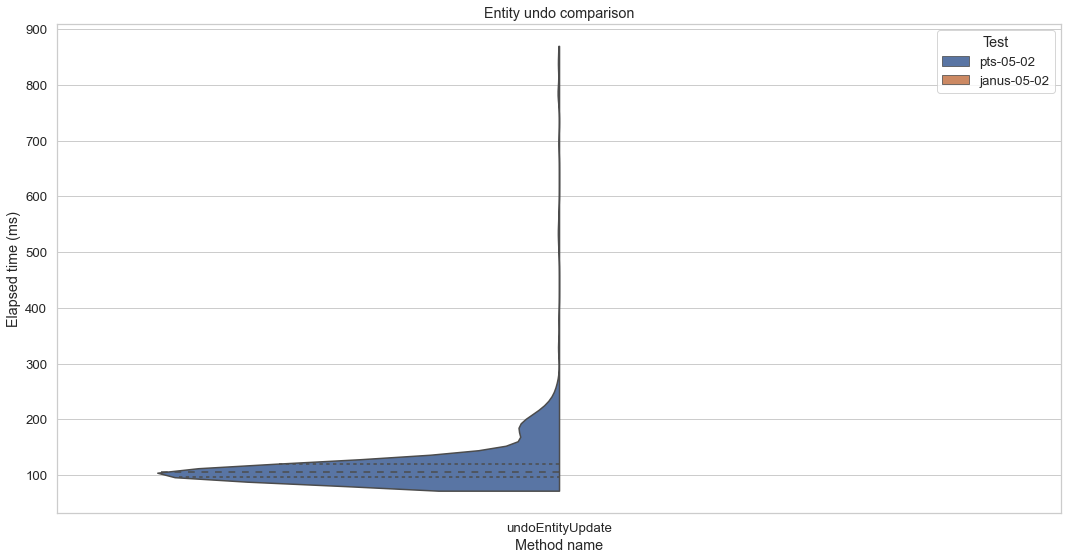

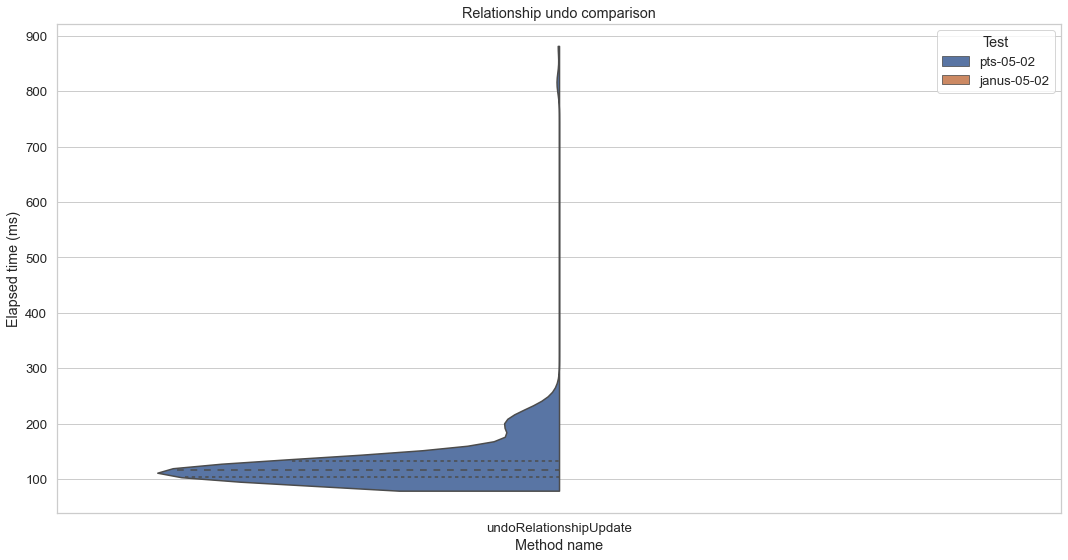

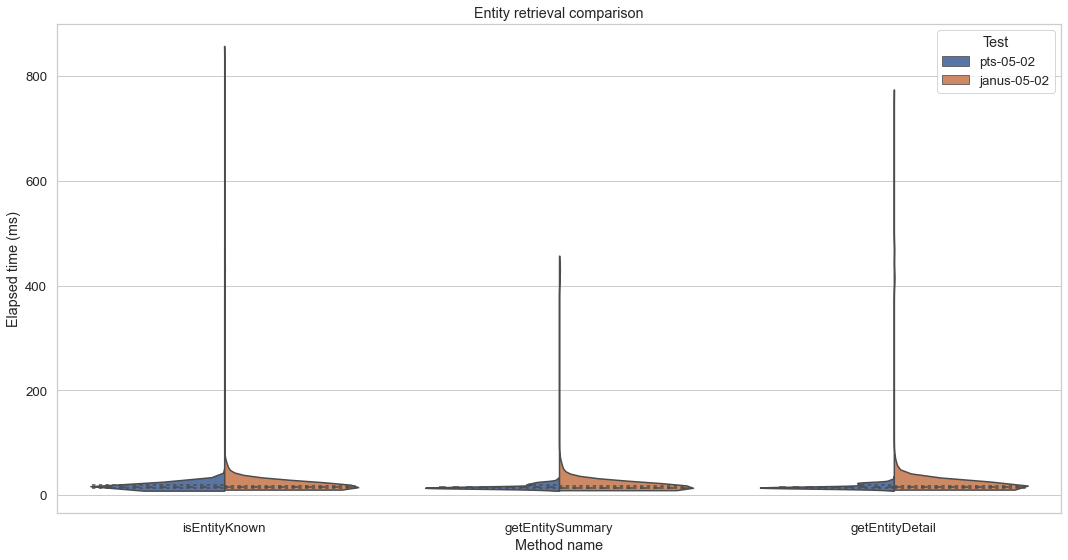

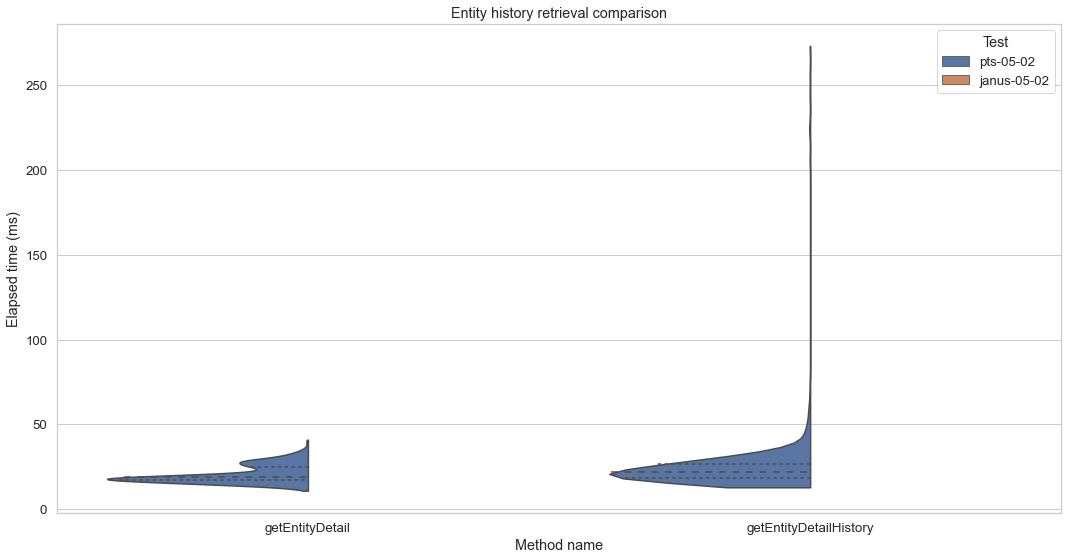

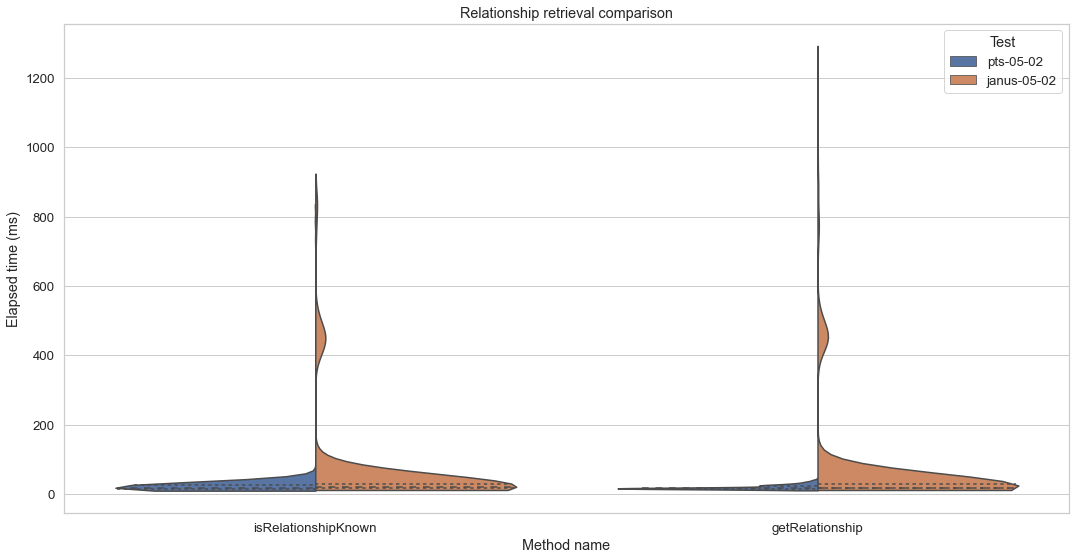

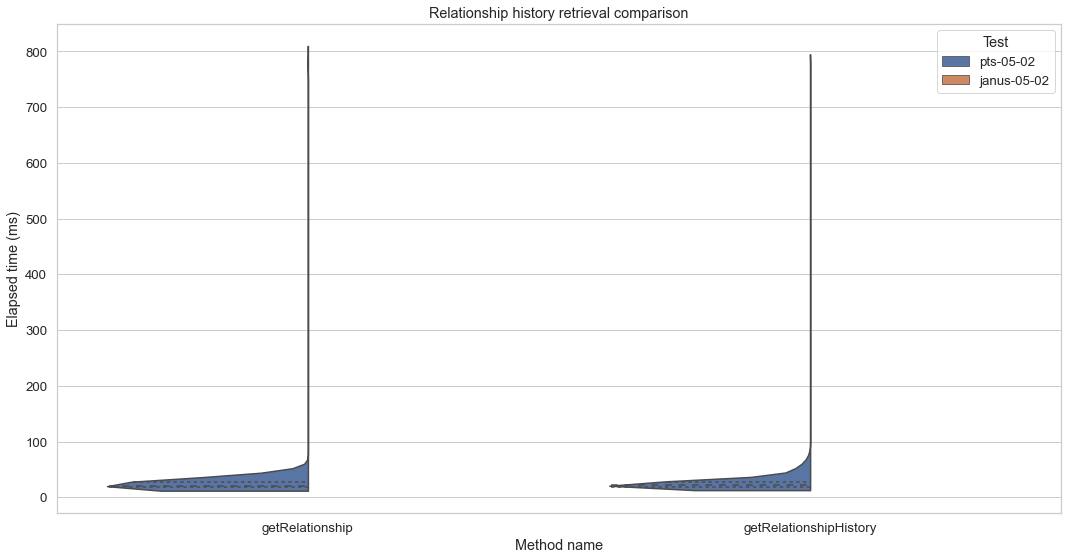

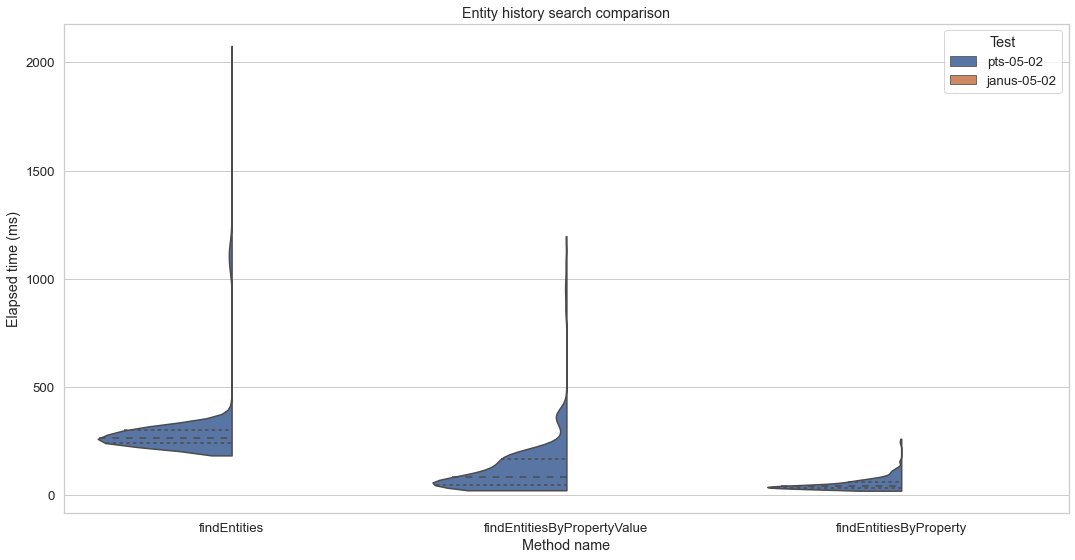

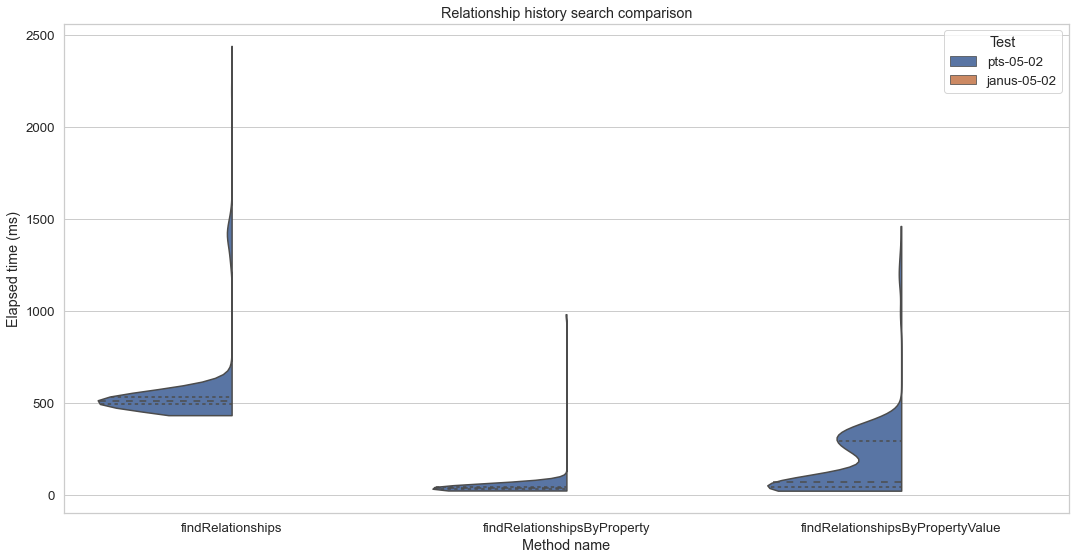

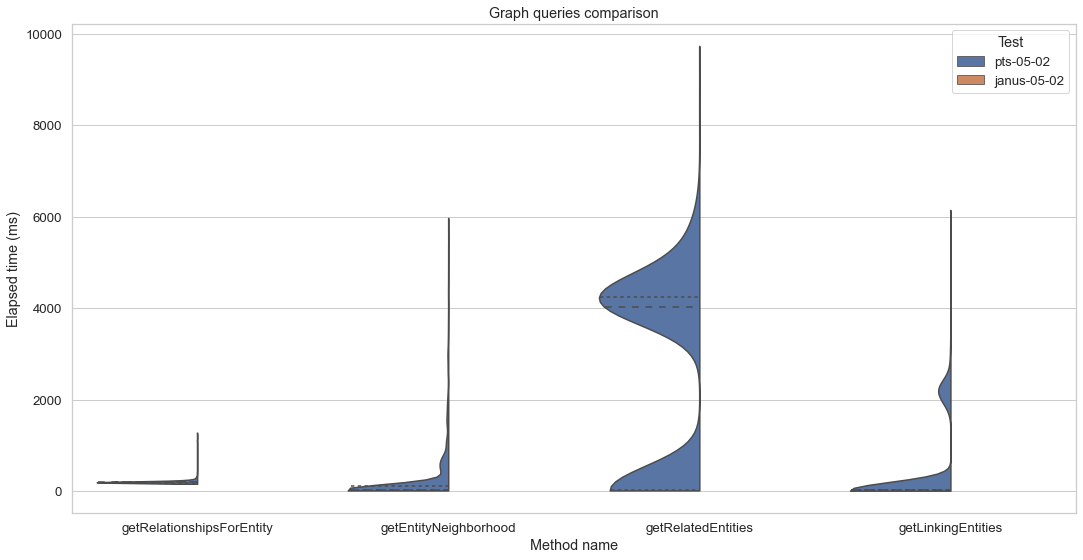

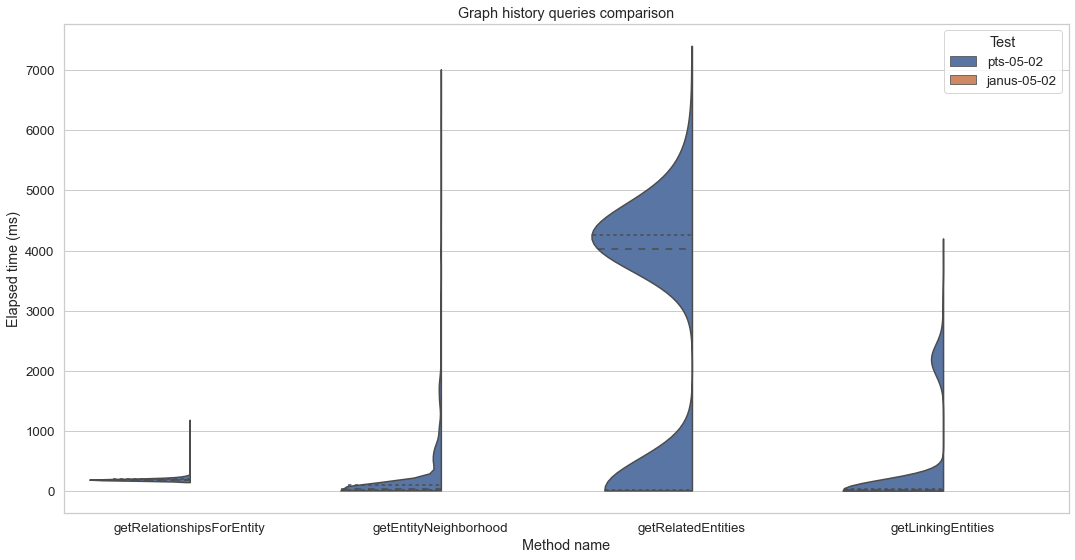

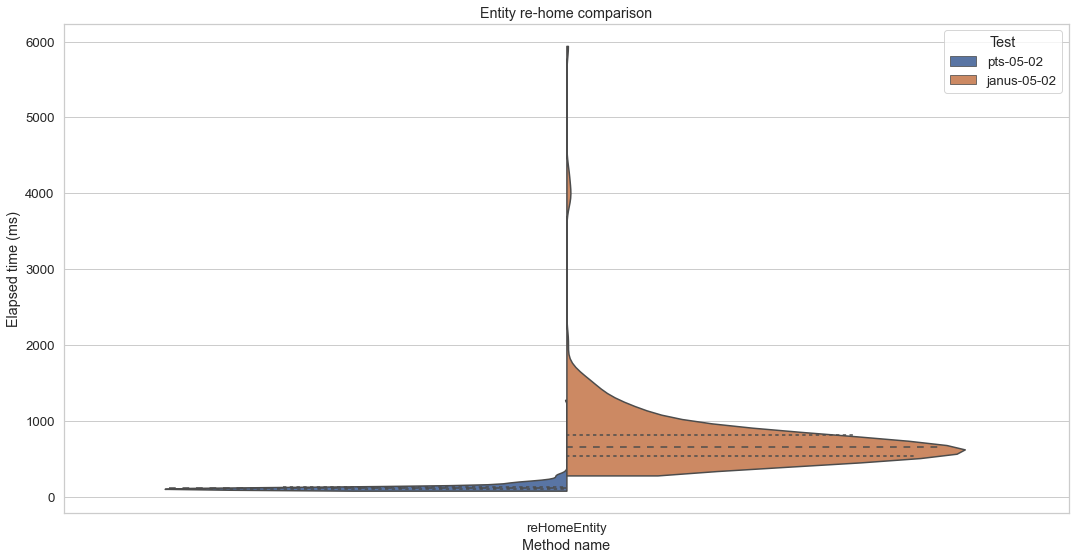

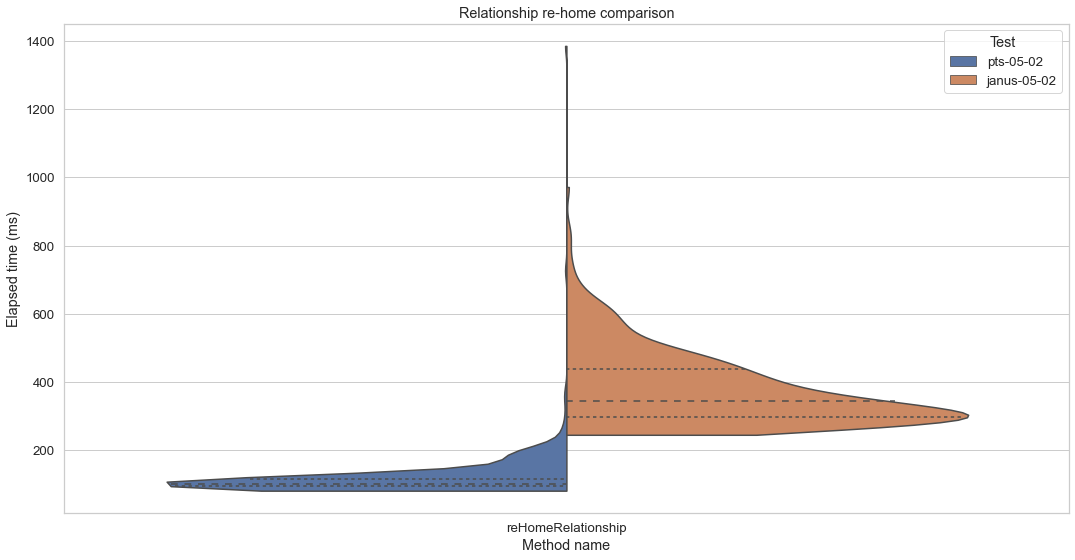

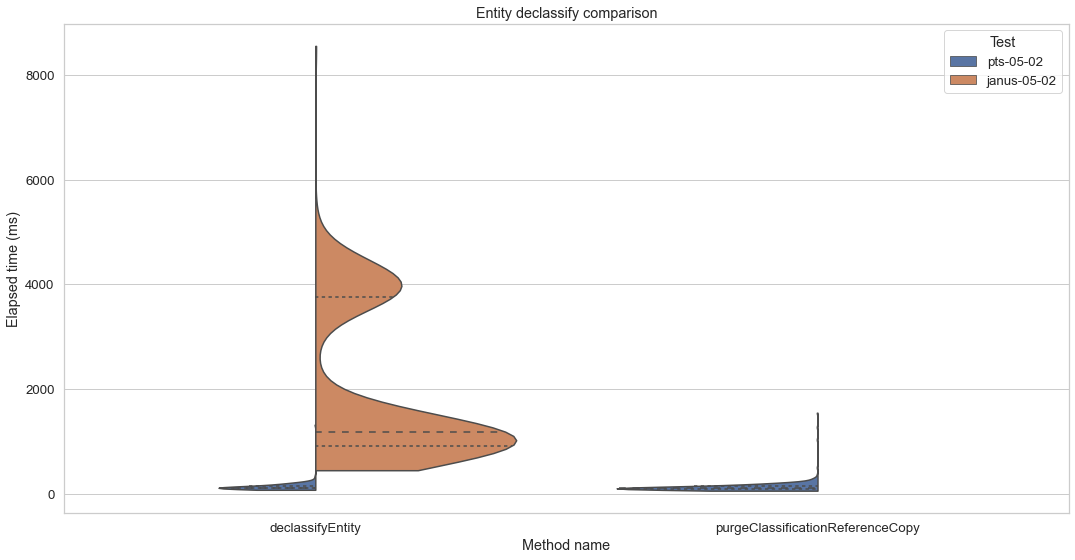

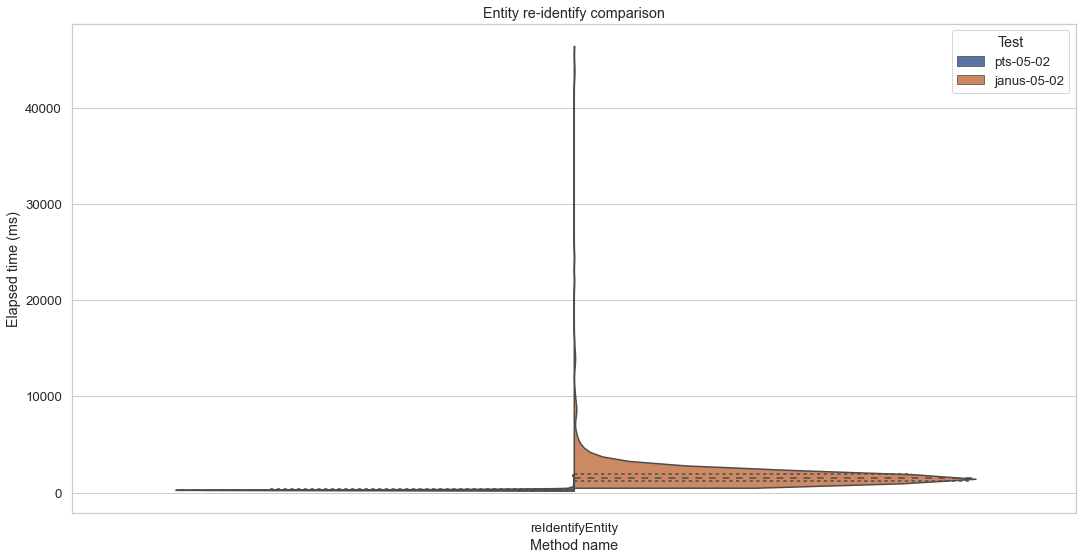

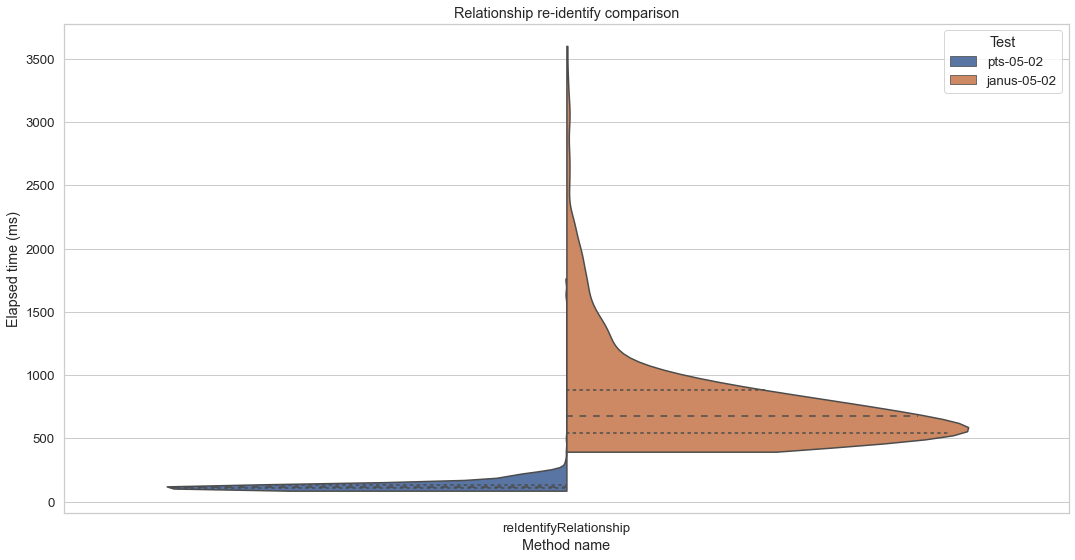

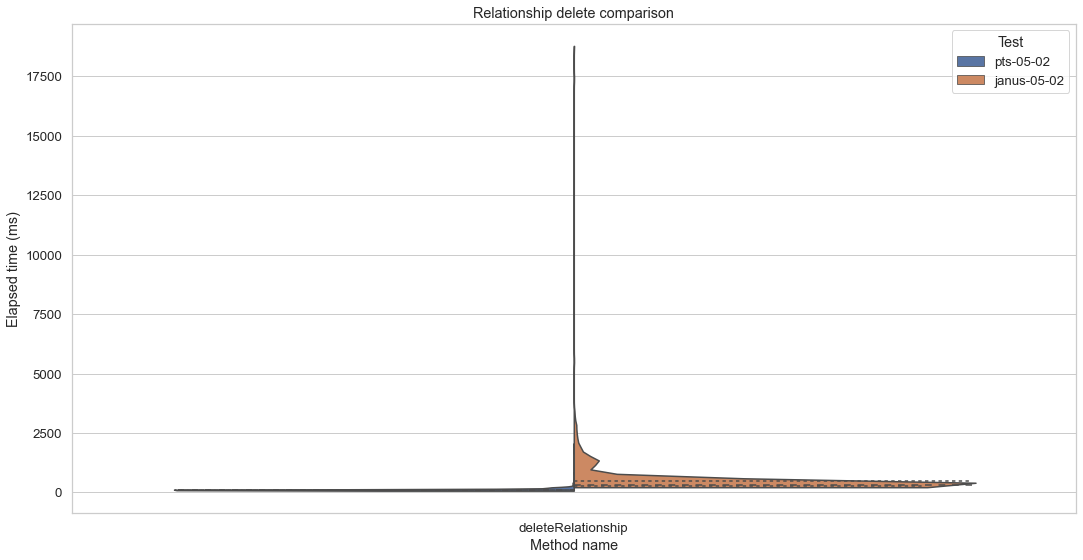

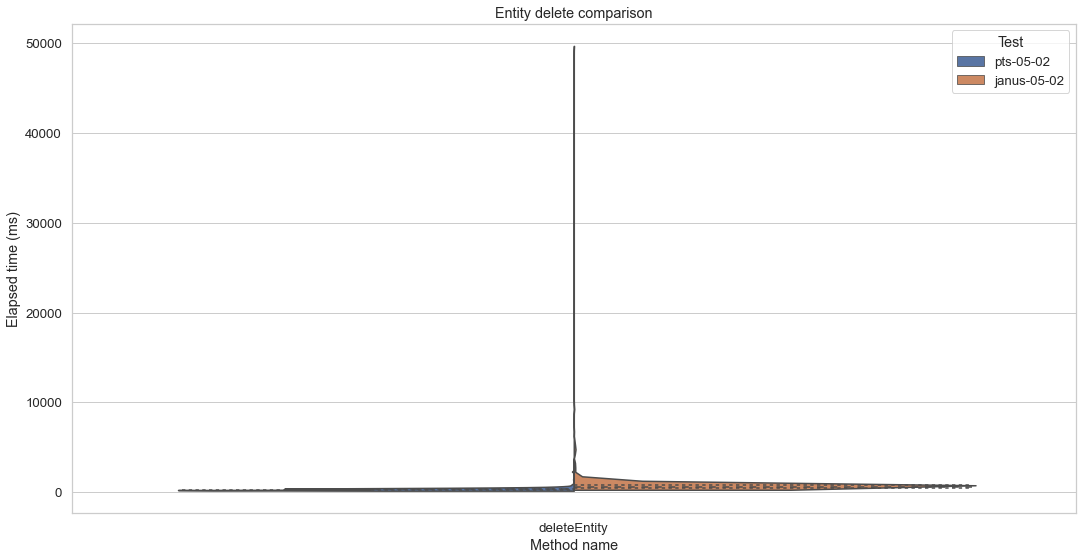

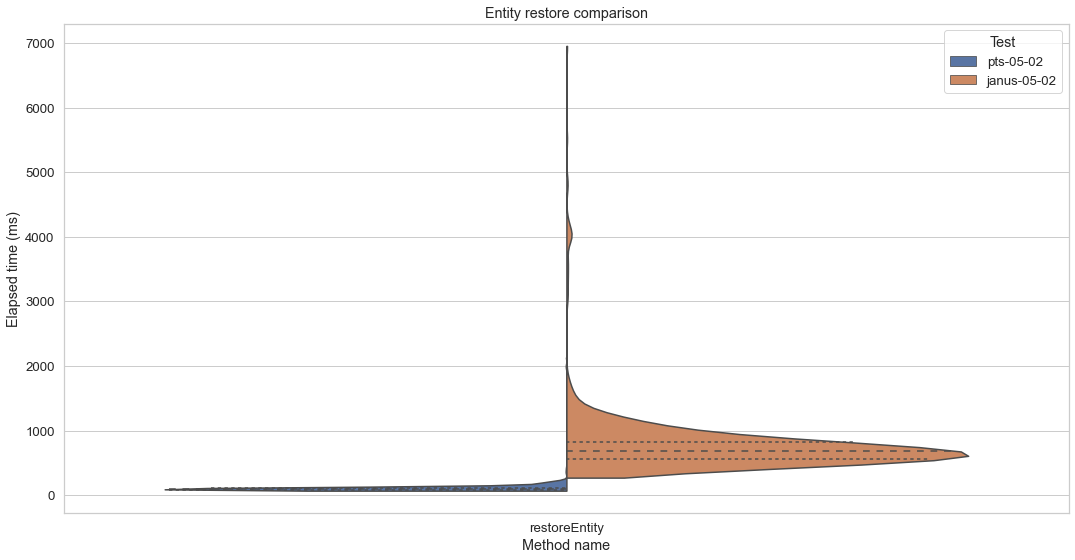

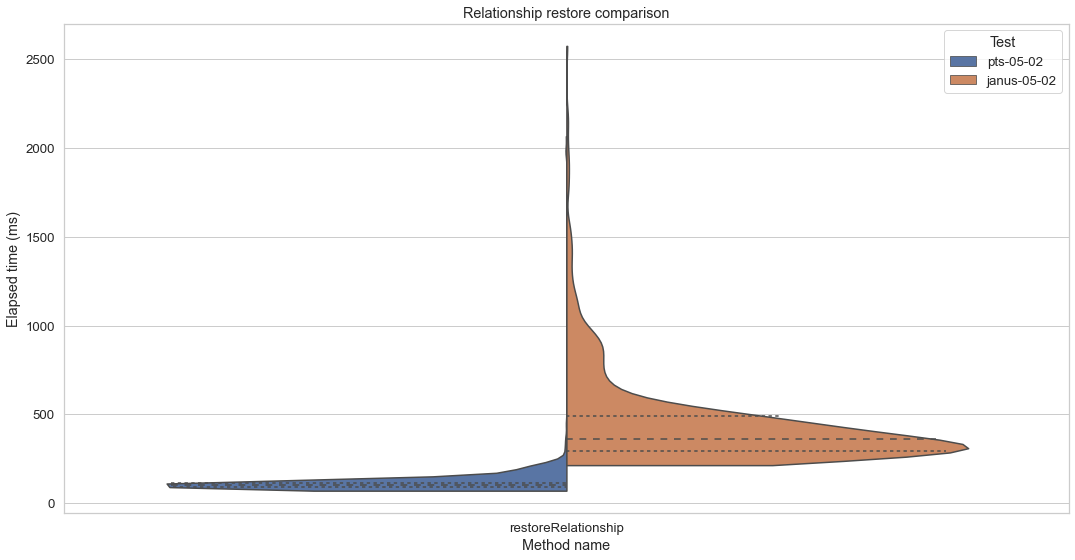

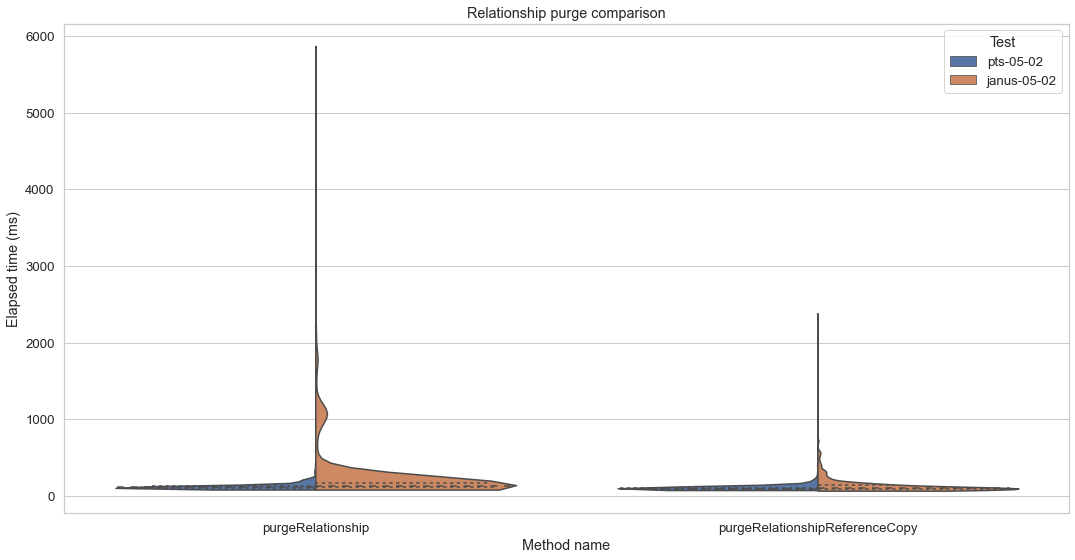

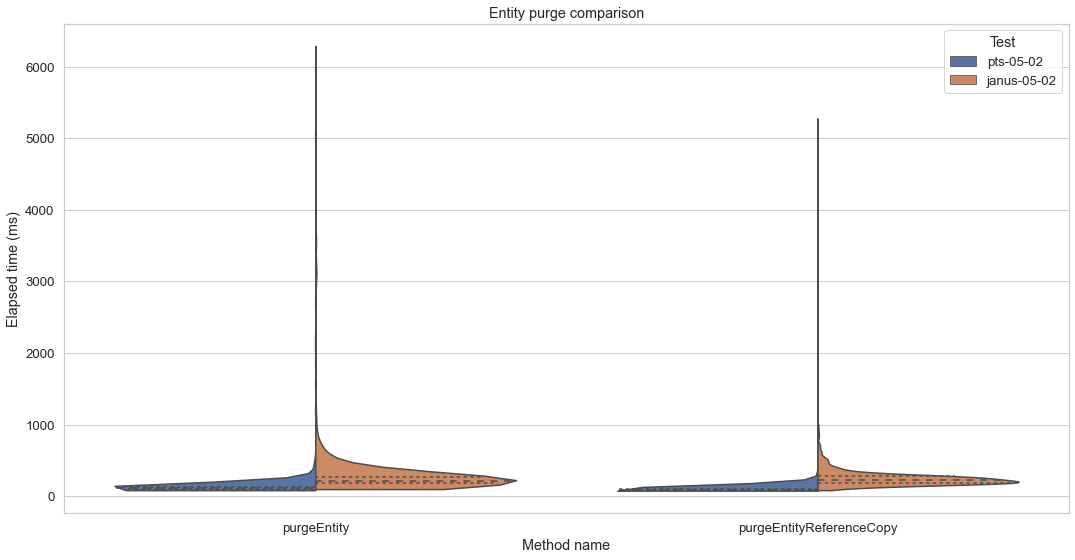

In [13]:
for profile in profile_order:
    compareProfiles(df1, profile, results0, results2)

#### Analysis

Here we can see more varied results:

- The retrieval methods are roughly equivalent between the two repositories
- The Crux connector appears to be significantly faster with write operations (create, update, delete, purge, restore, re-identify, etc)
- The JanusGraph connector appears to be generally faster with search operations, though also appears to have cases where it is significantly slower (the second peak in orange being well above the singular blue peak on `findEntities` for example).

This may warrant further investigation into which combination of parameters causes the JanusGraph repository to perform particularly slowly for this method.

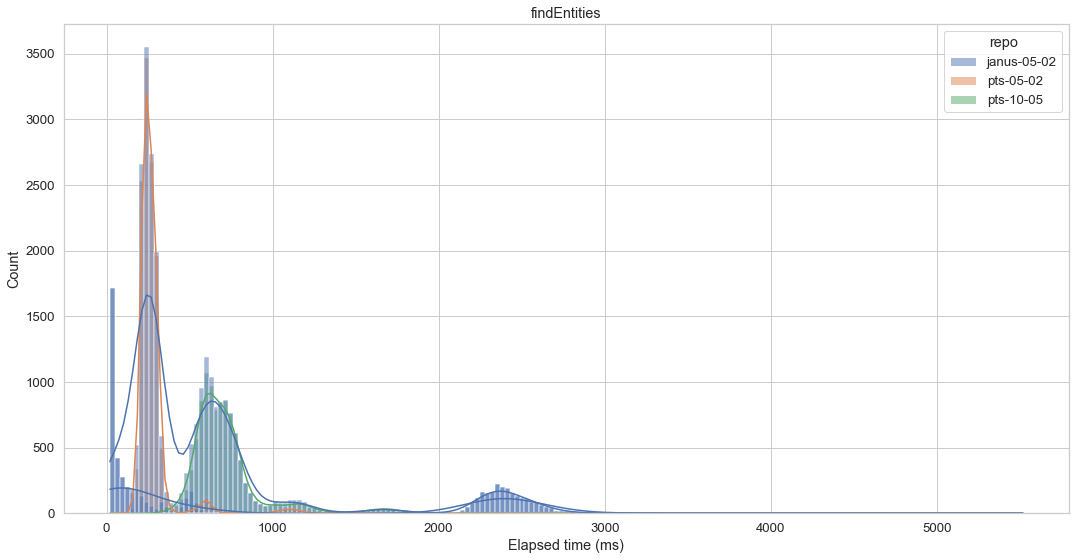

In [21]:
plotMethod(df1, "findEntities", by_repo=True)

In [19]:
slowestRunning(df1[df1['repo'] == 'janus-05-02'], num=10, methodName='findEntities')

repo   method_name  elapsed_time   profile_name  \
223679  janus-05-02  findEntities        5519.0  Entity search   
224347  janus-05-02  findEntities        5298.0  Entity search   
224328  janus-05-02  findEntities        5153.0  Entity search   
223677  janus-05-02  findEntities        5129.0  Entity search   
223681  janus-05-02  findEntities        5076.0  Entity search   
223639  janus-05-02  findEntities        4609.0  Entity search   
223619  janus-05-02  findEntities        4573.0  Entity search   
223629  janus-05-02  findEntities        4461.0  Entity search   
223673  janus-05-02  findEntities        4375.0  Entity search   
223627  janus-05-02  findEntities        4211.0  Entity search   

                                                                  test_case_id  \
223679         repository-entity-classification-performance-UserProfileManager   
224347                   repository-entity-retrieval-performance-Referenceable   
224328                repository-entity-retrieval-performance-OpenMetadataRoot   
223677        repository-entity-classification-performance-UserAccessDirectory   
223681          repository-entity-classification-performance-VerificationPoint   
223639                  repository-entity-classification-performance-PrimeWord   
223619                   repository-entity-classification-performance-Modifier   
223629        repository-entity-classification-performance-PolicyDecisionPoint   
223673                   repository-entity-classification-performance-Template   
223627  repository-entity-classification-performance-PolicyAdministrationPoint   

                                                     assertion_id  
223679  repository-entity-classification-performance-findEntities  
224347       repository-entity-retrieval-performance-findEntities  
224328       repository-entity-retrieval-performance-findEntities  
223677  repository-entity-classification-performance-findEntities  
223681  repository-entity-classification-performance-findEntities  
223639  repository-entity-classification-performance-findEntities  
223619  repository-entity-classification-performance-findEntities  
223629  repository-entity-classification-performance-findEntities  
223673  repository-entity-classification-performance-findEntities  
223627  repository-entity-classification-performance-findEntities

Interestingly we can see that some predicted suspects like `Referenceable` and `OpenMetadataRoot` are particularly slow-performing; however, these are not alone given `UserProfileManager`, `UserAccessDirectory` and `VerificationPoint` each also demonstrate response times that exceed 5 seconds.

Instead of the metadata type being the distinguishing factor, it appears it is the search parameters that are most important:

- For `Referenceable` and `OpenMetadataRoot` the slow-running examples come from the `repository-entity-retrieval-performance` set of tests: these run `findEntities` with only a type GUID as a filter.
- All of the other slowest-running examples come from the `repository-entity-classification-performance` set of tests: where `findEntities` is called with a classification criteria to retrieve a limited number of results.

It would therefore appear that the JanusGraph repository connector's ability to search based on classification and to search based only on a very abstract supertype is significantly slower than the Crux repository connector's ability to do the same searches.